<a href="https://colab.research.google.com/github/lfernandof/lfp_signals_analysis/blob/main/participation_ratio_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import json
import scipy
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def scored_state_probing(rat_id,day_id,session_data,state_type='NREMstate'):
  '''
  Find all intervals of a given type in a session and construct DataFrames with all events (spikes) comprising each period, alongside other relevant columns.

  Parameters
  ----------
  rat_id: int
          The chosen animal
  day_id: int
          The day in which the session happened
  state_type: string [default: "NREMstate"]
          The type of period which to probe. Options are: "NREMstate", "WAKEstate", "REMstate" and "events_pathologicalstate"

  Returns
  ----------
  session_staging_df: pandas DataFrame
          a pandas DataFrame with the following columns:
            - timestamp [float]: instant at which a given spike happened (in s)
            - region [string]: either 'PFC' or 'STR'
            - day [int]: either '1' or '2'
            - group [int]: only '2' for now, for we only have pre-trial spiking data from animals in group 2
            - rat [int]: each animal's ID
            - stage_type [string]: either {'WAKE','nREM','REM' or 'pathological'}
            - period_id [int]: period index for a given stage (e.g.: {stage_type = 'NREM',period_id = 0} is the first NREM period for that neuron in that session)
            - duration [float]: the length of a given period in s (e.g. {stage_type = 'NREM',period_id = 0, duration = 15} indicates that the first NREM period for that neuron in that session lasts 15 s)

  '''
  print(f'Beginning the stage segmentation of {state_type.removesuffix("state")} states from session:\n(Rat: {rat_id}, day: {day_id})')

  #Query for the desired session and find the first and last timestamp, corresponding to the beginning and end of the training protocol during this session
  training_begin = session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.min()
  training_end = session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.max()

  #Load the timestamps for each event (e.g. sleep, pathological states) as a list

  #We set up these conditionals just for rat 4, whose folders are differently named from the pattern
  if rat_id == 4 and day_id == 1:
    day_tag = '2017-05-06_09-58-35'
  elif rat_id == 4 and day_id == 2:
    day_tag = '2017-05-07_13-57-27'
  else:
    day_tag = f'Day{day_id}'

  state_scores_path = f'/content/drive/MyDrive/MSc/Rat{rat_id}/{day_tag}'

  #Load the state scoring timestamps proper
  data_states = sio.loadmat(state_scores_path+f'/{day_tag}.SleepState.states.mat')

  #Not all sessions have pathological states
  if state_type == 'events_pathologicalstate':
    try:
      event_timestamps = data_states['SleepState']['ints'][0][0][state_type][0][0]
    except:
      raise('There are no pathological (microseizure) states in this session.')
  #But all others are guaranteed
  else:
    event_timestamps = data_states['SleepState']['ints'][0][0][state_type][0][0]

  # Load the spike corresponding to this session
  data_path = f'drive/MyDrive/MSc/Rat{rat_id}/{day_tag}/'
  spikefile_tag = 'openephys'
  #exceptions to overwrite names because these folders/files are wrongly named and I do not have permission to change it
  if rat_id == 4 and day_id == 1:
    spikefile_tag = '2017-05-06_09-58-35'
  spikes_test = sio.loadmat(data_path+spikefile_tag+'.spikes.cellinfo.mat')

  #UID (unit id)
  uid = np.squeeze(spikes_test['spikes'][0][0]['UID'])

  #times (spike times)
  times = np.squeeze(spikes_test['spikes'][0][0]['times'])

  #the region each unit belongs to
  if rat_id == 4 and day_id == 1:
    #this animal does not have a "region" field, so we fill this using the electrode shank ID
    electrode_shank = np.squeeze(spikes_test['spikes'][0][0]['shankID'])
    region = ["PFC" if value == 1 else "STR" for value in electrode_shank]
  else:
    region = np.squeeze(spikes_test['spikes'][0][0]['region'])

  #shankID, cluID, rawWaveform, maxWaveformCh are also in this .mat file, but I will not be using any of these


  def create_or_append(dataframe,current_data):
    if dataframe is not None:
        return pd.concat([dataframe,pd.DataFrame(current_data)])
    else:
        return pd.DataFrame(current_data)

  session_df = pd.DataFrame(columns=['timestamp', 'region', 'day', 'group', 'rat','neuron','stage','stage_id','stage_duration']) #Not a good practice to create an empty df but it's the easiest

  #iterate over neurons
  for unit_id in np.squeeze(uid)-1: #uid is 1-indexed as per matlab, whereas python used 0-indexing
    current_spike_train = np.squeeze(times[unit_id])

    #same session being problematic again...
    if rat_id == 4 and day_id == 1:
      current_unit_region = region[unit_id]
    else:
      current_unit_region = np.squeeze(region)[unit_id][0]

    #for each neuron find which of its spikes fall within each period (stage) of a given type (e.g. sleep) and add each spike as a row in a pandas DataFrame
    for period_id,period_limits in enumerate(event_timestamps):
      period_timestamps = current_spike_train[np.where((current_spike_train > period_limits[0]) * (current_spike_train < period_limits[1]))]
      period_df = pd.DataFrame.from_dict({'timestamp':period_timestamps,'region':current_unit_region,'day':day_id,'group':2,'rat':rat_id,
                                          'neuron':unit_id,'stage':state_type,'stage_id':period_id,'stage_duration':np.diff(period_limits)[0]})
      session_df = create_or_append(session_df,period_df)

  print('Done')
  return session_df

In [3]:
session_data = pd.read_csv('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels//data/session_data-spikes.csv').copy()

rat_id = 3
day_id = 1
scored_NREM_spikes_df = scored_state_probing(rat_id,day_id,session_data,state_type='NREMstate')

Beginning the stage segmentation of NREM states from session:
(Rat: 3, day: 1)
Done


In [ ]:
session_data.query('day == 1 and rat == 3 and neuron == 0')

,Unnamed: 0,timestamp,quality,region,day,group,rat,neuron,trial,time,duration
953524,0,3836.759333,2.0,PFC,1,2,3,0,1.0,-0.459933,0.415767
953525,1,3837.589300,2.0,PFC,1,2,3,0,1.0,0.370033,0.415767
953526,2,3837.589300,2.0,PFC,1,2,3,0,2.0,-0.120400,0.124733
953527,3,3837.783533,2.0,PFC,1,2,3,0,2.0,0.073833,0.124733
953528,4,3850.097267,2.0,PFC,1,2,3,0,5.0,-0.486233,0.716233
...,...,...,...,...,...,...,...,...,...,...,...
957301,3777,8394.499867,2.0,PFC,1,2,3,0,542.0,0.038767,0.548333
957302,3778,8394.584967,2.0,PFC,1,2,3,0,542.0,0.123867,0.548333
957303,3779,8394.619400,2.0,PFC,1,2,3,0,542.0,0.158300,0.548333
957304,3780,8394.619400,2.0,PFC,1,2,3,0,543.0,-0.491667,0.465300


In [ ]:
scored_NREM_spikes_df

,timestamp,region,day,group,rat,neuron,stage,stage_id,stage_duration
0,2.322733,PFC,1,2,3,0,NREMstate,0,14
1,3.253733,PFC,1,2,3,0,NREMstate,0,14
2,3.277967,PFC,1,2,3,0,NREMstate,0,14
3,5.422900,PFC,1,2,3,0,NREMstate,0,14
4,5.617900,PFC,1,2,3,0,NREMstate,0,14
...,...,...,...,...,...,...,...,...,...
33,14569.299600,STR,1,2,3,15,NREMstate,46,112
34,14569.312000,STR,1,2,3,15,NREMstate,46,112
35,14569.322967,STR,1,2,3,15,NREMstate,46,112
36,14569.382833,STR,1,2,3,15,NREMstate,46,112


In [ ]:
def summary_dataframe(scored_states_dataframe,rat_id,day_id):

  spike_count_in_stage = len(scored_states_dataframe)
  num_events_in_stage = scored_states_dataframe.stage_id.nunique()

  spike_train_lens = [len(scored_states_dataframe.query(f'stage_id == {current_stage}')) for current_stage in scored_states_dataframe.stage_id.unique()]

  if spike_count_in_stage > 0:
    count_in_shortest_event = min(spike_train_lens)
    count_in_longest_event = max(spike_train_lens)
    median_in_events = int(np.median(spike_train_lens))
  else:
    count_in_shortest_event = count_in_longest_event = median_in_events = 0


  buffer_rat_summary = {'Rat':rat_id,'Day':day_id,
                        'Total # of spikes\nin stage':spike_count_in_stage,'Number of\nevents in stage':num_events_in_stage,
                        'Spike count in\nshortest event':count_in_shortest_event,'Spike count\nin longest event':count_in_longest_event,'Median spike count\nin stage':median_in_events}

  #summary_statistics_df = pd.DataFrame.from_dict(buffer_rat_summary)

  return buffer_rat_summary

In [ ]:
def stages_in_all_sessions(session_data,state_type='NREMstate'):
  summary_dicts = []
  #first session is rat = 3, day = 1. We do this one first so as not to create an empty dataframes, and simply append the next ones to this one
  all_scored_spikes_df = scored_state_probing(3,1,session_data,state_type=state_type)

  #additional info
  first_summary_dict = summary_dataframe(all_scored_spikes_df,rat_id = 3,day_id = 1)

  summary_dicts.append(first_summary_dict)

  for rat in range(3,7):
    for day in range(1,3):
      if rat == 3 and day == 1:
        #already done above
        pass
      else:
        scored_spikes_df = scored_state_probing(rat,day,session_data,state_type=state_type)
        all_scored_spikes_df = pd.concat([all_scored_spikes_df,scored_spikes_df])

        new_summary_dict = summary_dataframe(scored_spikes_df,rat_id = rat,day_id = day)
        summary_dicts.append(new_summary_dict)

  return all_scored_spikes_df,summary_dicts

In [ ]:
scored_NREM_spikes_df,scored_NREM_summary = stages_in_all_sessions(session_data,state_type='NREMstate');
scored_REM_spikes_df,scored_REM_summary = stages_in_all_sessions(session_data,state_type='REMstate');
scored_WAKE_spikes_df,scored_WAKE_summary = stages_in_all_sessions(session_data,state_type='WAKEstate');

Beginning the stage segmentation of NREM states from session:
(Rat: 3, day: 1)
Done
Beginning the stage segmentation of NREM states from session:
(Rat: 3, day: 2)
Done
Beginning the stage segmentation of NREM states from session:
(Rat: 4, day: 1)
Done
Beginning the stage segmentation of NREM states from session:
(Rat: 4, day: 2)
Done
Beginning the stage segmentation of NREM states from session:
(Rat: 5, day: 1)
Done
Beginning the stage segmentation of NREM states from session:
(Rat: 5, day: 2)
Done
Beginning the stage segmentation of NREM states from session:
(Rat: 6, day: 1)
Done
Beginning the stage segmentation of NREM states from session:
(Rat: 6, day: 2)
Done
Beginning the stage segmentation of REM states from session:
(Rat: 3, day: 1)
Done
Beginning the stage segmentation of REM states from session:
(Rat: 3, day: 2)
Done
Beginning the stage segmentation of REM states from session:
(Rat: 4, day: 1)
Done
Beginning the stage segmentation of REM states from session:
(Rat: 4, day: 2)
D

In [ ]:
scored_summary_of_interest = scored_WAKE_summary
df_copy = pd.DataFrame(scored_summary_of_interest).drop(columns=['Spike count in\nshortest event','Spike count\nin longest event'])

def make_pretty(styler):
    styler.set_caption('NREM Sleep')
    styler.format(precision=3, thousands=".", decimal=",").highlight_min(subset=list(df_copy.keys())[4])
    styler.format_index(lambda v: "")
    return styler

df_copy.style.pipe(make_pretty)

,Rat,Day,Total # of spikes in stage,Number of events in stage,Median spike count in stage
,3,1,691.596,55,946
,3,2,737.188,42,5.301
,4,1,2.129.399,47,11.474
,4,2,1.338.688,26,12.693
,5,1,597.110,38,1.640
,5,2,1.278.130,57,1.745
,6,1,411.559,51,1.474
,6,2,191.599,37,321


In [ ]:
#uncomment to export the DataFrame to LaTeX

#print(df_copy.to_latex(index=False,
#                  formatters={"name": str.upper},
#                  float_format="{:.1f}".format,
#))

In [ ]:
all_scored_states = pd.concat([scored_NREM_spikes_df,scored_REM_spikes_df,scored_WAKE_spikes_df])

In [ ]:
all_scored_states

,timestamp,region,day,group,rat,neuron,stage,stage_id,stage_duration
0,2.322733,PFC,1,2,3,0,NREMstate,0,14
1,3.253733,PFC,1,2,3,0,NREMstate,0,14
2,3.277967,PFC,1,2,3,0,NREMstate,0,14
3,5.422900,PFC,1,2,3,0,NREMstate,0,14
4,5.617900,PFC,1,2,3,0,NREMstate,0,14
...,...,...,...,...,...,...,...,...,...
112,11543.591133,PFC,2,2,6,7,WAKEstate,36,78
113,11543.893033,PFC,2,2,6,7,WAKEstate,36,78
114,11544.411267,PFC,2,2,6,7,WAKEstate,36,78
115,11547.298400,PFC,2,2,6,7,WAKEstate,36,78


In [ ]:
all_scored_states.to_csv('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels//data/all_scored_states.csv')

## so that we do not need to run it every time, load the df from the formerly saved file

In [4]:
all_scored_states = pd.read_csv('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels//data/all_scored_states.csv',index_col='Unnamed: 0')

In [5]:
all_scored_states

,timestamp,region,day,group,rat,neuron,stage,stage_id,stage_duration
0,2.322733,PFC,1,2,3,0,NREMstate,0,14
1,3.253733,PFC,1,2,3,0,NREMstate,0,14
2,3.277967,PFC,1,2,3,0,NREMstate,0,14
3,5.422900,PFC,1,2,3,0,NREMstate,0,14
4,5.617900,PFC,1,2,3,0,NREMstate,0,14
...,...,...,...,...,...,...,...,...,...
112,11543.591133,PFC,2,2,6,7,WAKEstate,36,78
113,11543.893033,PFC,2,2,6,7,WAKEstate,36,78
114,11544.411267,PFC,2,2,6,7,WAKEstate,36,78
115,11547.298400,PFC,2,2,6,7,WAKEstate,36,78


# Visualizing the pipeline in a single interval
Below I will estimate the participation ratio (PR) early and late in session for a single session (rat 3, day 1, 2nd NREM sleep period, all neurons [PFC & STR]) and plot every step throughout.

In [ ]:
def time_binning(spikes_df,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('stage_id').copy()

  num_stages = dataset.stage_id.nunique()
  num_neurons = dataset.neuron.nunique()

  duration = timespan[1] - timespan[0]
  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_stages,num_neurons,num_timebins])

  for stage_id,stage in enumerate(dataset.stage_id.unique()):
    stage_beginning = dataset.loc[dataset['stage_id'] == stage_id].timestamp.min()
    for neuron_id,neuron in enumerate(dataset.neuron.unique()):
      spike_train = dataset.loc[(dataset['stage_id'] == stage_id) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.timestamp - stage_beginning,bins = np.linspace(timespan[0],timespan[1],num_timebins+1,endpoint=True))
      binned_spikes_matrix[stage_id,neuron_id,:] = discretized_spike_train

  return binned_spikes_matrix

In [ ]:
binned_spikes_matrix = time_binning(all_scored_states.query('rat == 3 and day == 1 and stage == "NREMstate"'))

Text(0, 0.5, 'Neuron (#)')

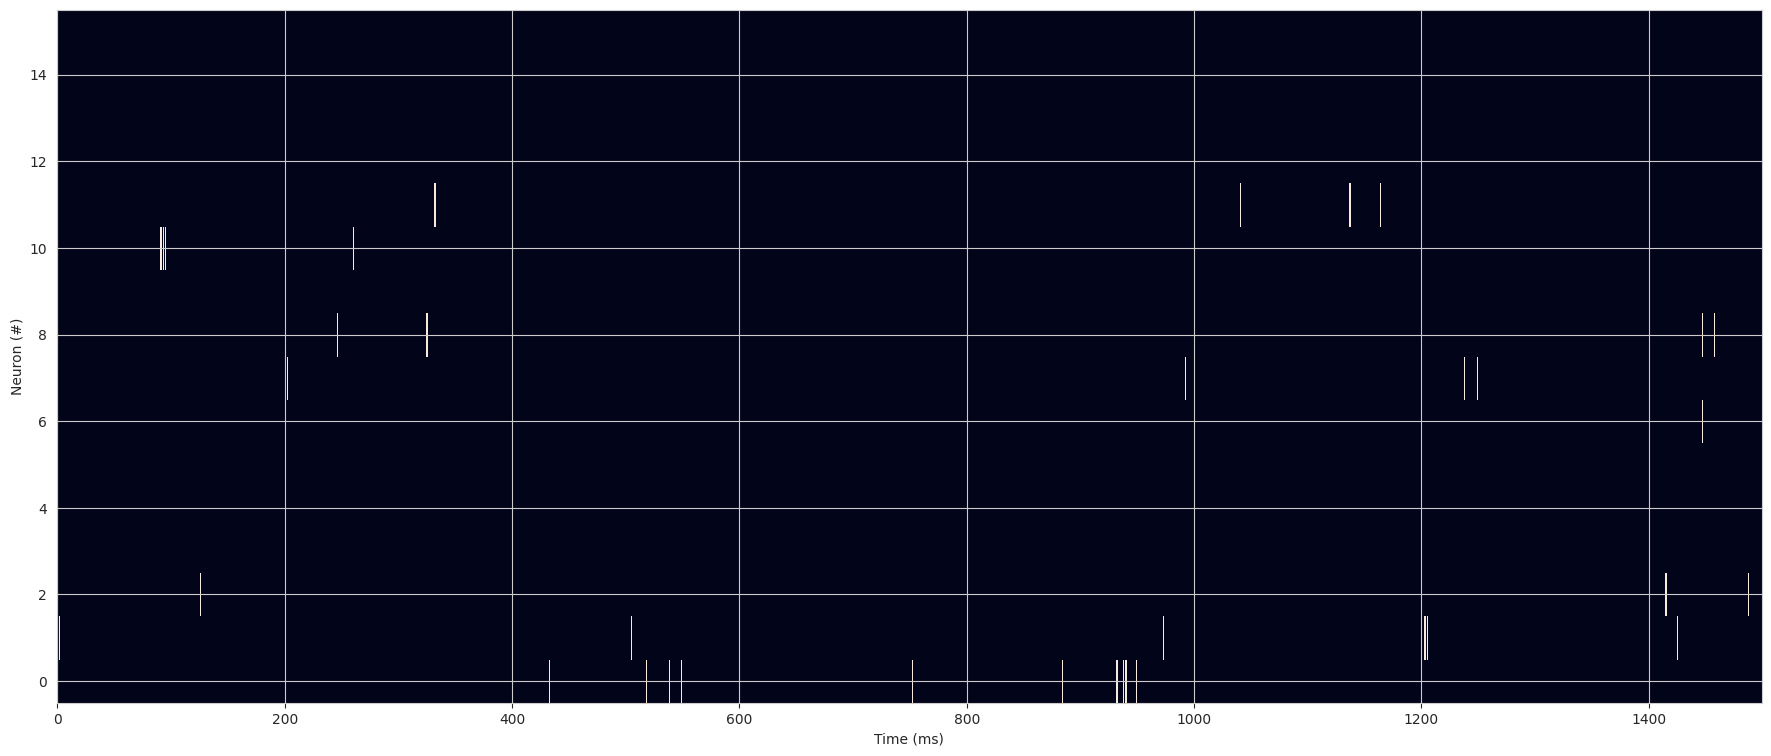

In [ ]:
fig, ax = plt.subplots(figsize=(22, 9))

rates = ax.matshow(binned_spikes_matrix[1,:,:],aspect="auto",origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron (#)')

In [ ]:
def convolve_raster(binned_spikes):
    #Convolve a matrix containing the raster plots (time histogram of spikes) for all neurons in all trials

    #INPUT:
    # - binned_spikes: a trials x neurons x timebins matrix
    # - width: the kernel width, in ms
    # - sd: I haven't figured it out exactly yet: lower values widen the kernel shape and larger ones sharpen it
    #the authors didn't call it SD, I am extrapolating from my knowledge on gaussian filtering (might be wrong)

    #OUTPUT:
    # - convolved [np.ndarray(int,int,float)]: a trials x neurons x timebins matrix of convolved spiking activity

    x = np.linspace(0,750,750) #750 ms in 750 points

    kernel = np.exp(-x/100)
    kernel = np.pad(kernel,(750,0),'constant') #center the kernel at 0

    #uncomment these to plot the kernel
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)

    #uncomment these to plot evidence that the kernel drops to 1/e over the course of 100ms
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)


    #create a matrix with the same dimensions as the binned rasters' to accommodate the convolved rasters
    all_neurons_convolved = np.zeros(np.shape(binned_spikes))
    print(np.shape(all_neurons_convolved))

    #the # of trials, neurons and timebins are given by:
    trials,neurons,timebins = np.shape(binned_spikes)

    for trial in range(trials):
        for neuron in range(neurons):
            all_neurons_convolved[trial,neuron,:] = np.convolve(kernel,binned_spikes[trial,neuron,:]
                                                            ,mode='full')[750:-749]

    return all_neurons_convolved

In [ ]:
firing_rates = convolve_raster(binned_spikes_matrix)

(47, 16, 1500)


Text(0, 0.5, 'Neuron (#)')

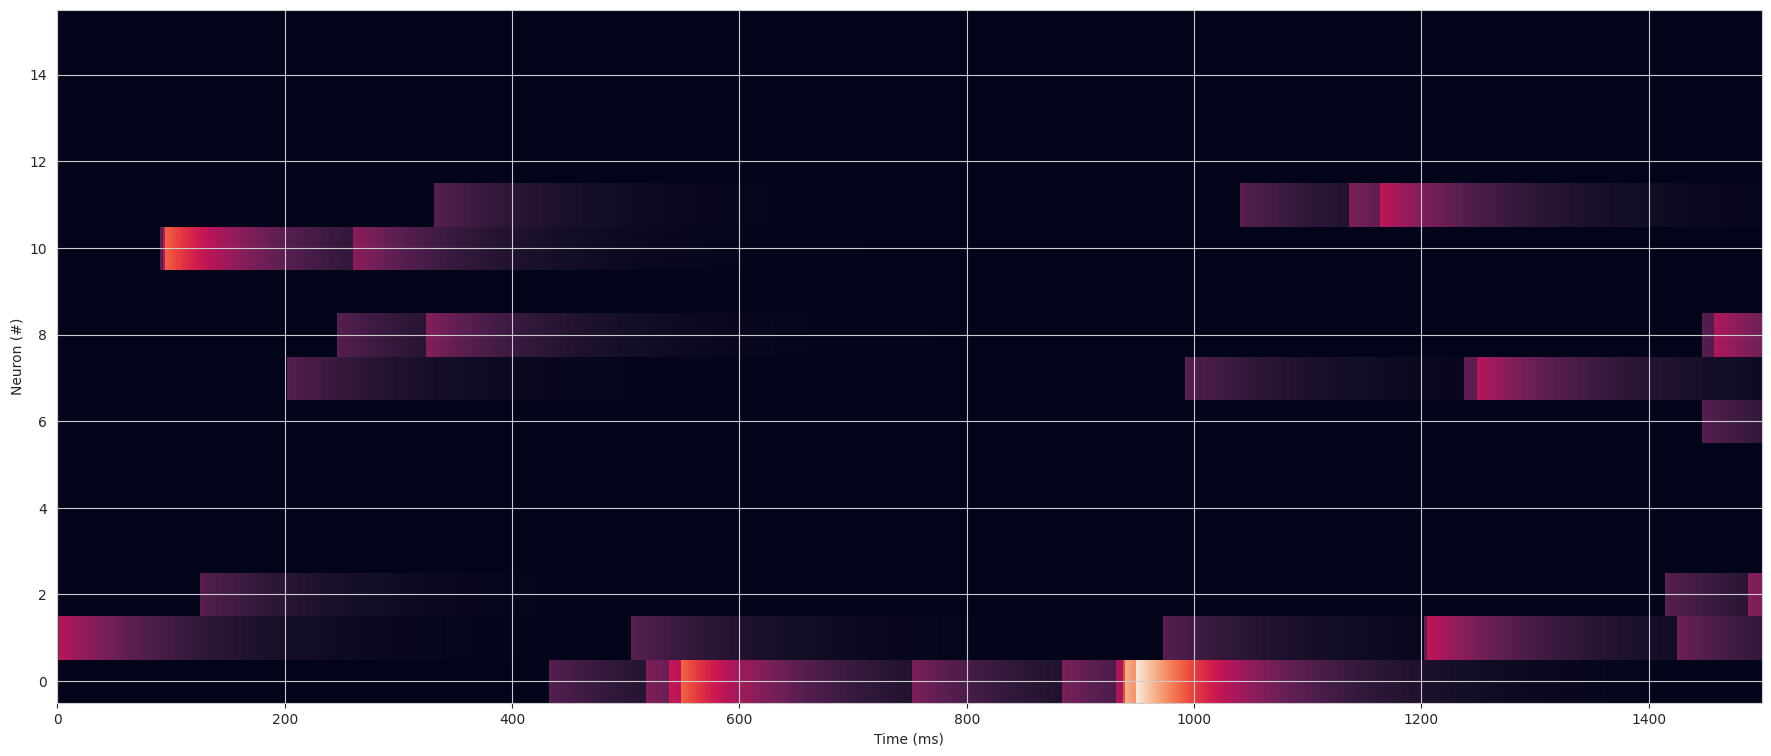

In [ ]:
fig, ax = plt.subplots(figsize=(22, 9))

rates = ax.matshow(firing_rates[1,:,:],aspect="auto",origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron (#)')

In [ ]:
np.shape(firing_rates)

(47, 16, 1500)

In [ ]:
(num_events,num_neurons,num_timebins) = np.shape(firing_rates)

In [ ]:
third_of_events = int(num_events/3)

lowres_timebin_size = 100 #in ms

lowres_timebins = int(num_timebins/lowres_timebin_size)

In [ ]:
early = firing_rates[0:third_of_events,:,:]
late = firing_rates[-third_of_events:,:,:]

In [ ]:
averaged_early = np.mean(early,axis=0)
averaged_late = np.mean(late,axis=0)

In [ ]:
def lower_firing_rate_resolution(spike_activity_matrix,time_window_size=100):

  '''
  Lower the resolution of a firing rate matrix with dimensions neurons x time bins by averaging over a window

  INPUT:
  - spike_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x time, in which each element (i,j) of the matrix represents the firing rate of neuron i at the j-th time bin
  - time_window_size [int]: time window over which the firing rates will be averaged (in ms)

  OUTPUT:
  - lowres_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x low_restime_bins, in which each element (i,j) of the matrix
                                            represents the firing rate of neuron i at the j-th low resolution time bin (by default of 100 ms width)
  '''

  (num_neurons,num_timebins) = np.shape(spike_activity_matrix)

  lowres_timebins = int(num_timebins/time_window_size)

  lowres_activity_matrix = np.zeros([num_neurons,lowres_timebins])

  for time_bin in range(lowres_timebins):
    lowres_activity_matrix[:,time_bin] = np.mean(spike_activity_matrix[:,time_bin*100:(time_bin+1)*100],axis=1)

  return lowres_activity_matrix

In [ ]:
lowres_averaged_early = lower_firing_rate_resolution(averaged_early)
lowres_averaged_late = lower_firing_rate_resolution(averaged_late)

Text(0, 0.5, 'Neuron (#)')

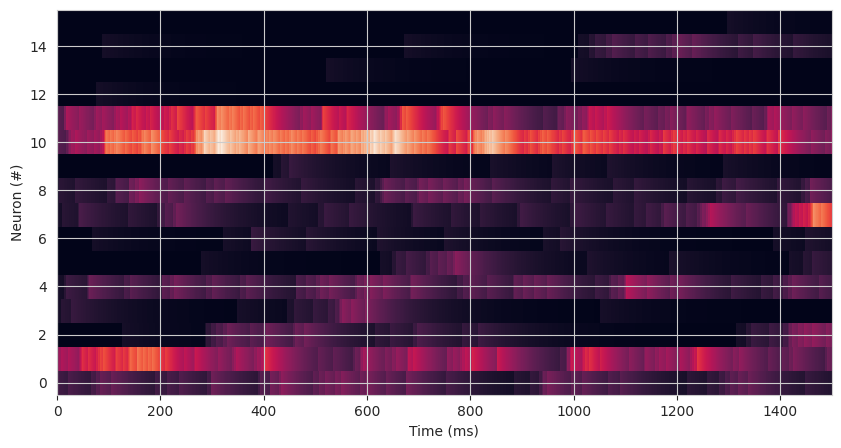

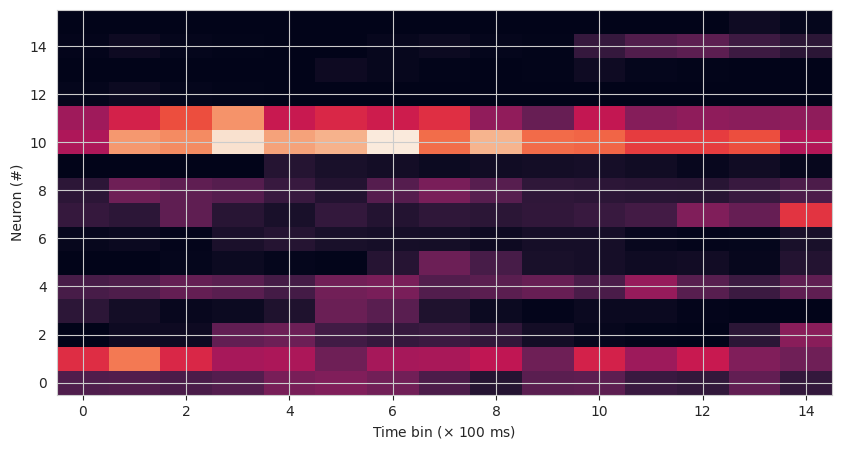

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

rates = ax.matshow(averaged_early,aspect="auto",origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron (#)')


fig, ax = plt.subplots(figsize=(10, 5))

rates = ax.matshow(lowres_averaged_early,aspect="auto",origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(r'Time bin ($\times$ 100 ms)')
ax.set_ylabel('Neuron (#)')

[ 1.38777878e-16  2.49800181e-16 -2.77555756e-16 -4.16333634e-16
 -2.22044605e-16  1.66533454e-16 -2.22044605e-16  8.32667268e-17
  5.82867088e-16  2.77555756e-16 -1.94289029e-16  1.66533454e-16
  4.71844785e-16 -3.05311332e-16 -8.32667268e-17]


Text(0, 0.5, 'Neuron (#)')

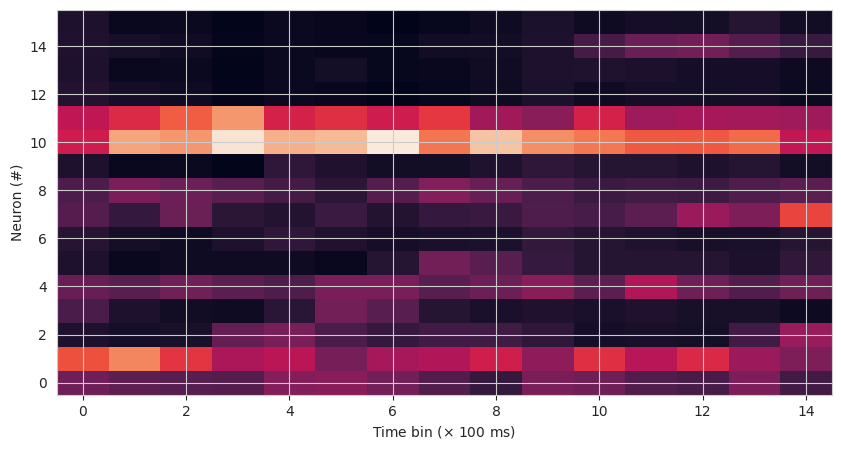

In [ ]:
#Z-scoring so each column sums up to 0
Z_lowres_avg_early = lowres_averaged_early - lowres_averaged_early.mean(axis=0, keepdims=True)

print(np.sum(Z_lowres_avg_early,axis=0)) #attesting to that: almost all are near zero up to the numerical precision


fig, ax = plt.subplots(figsize=(10, 5))

rates = ax.matshow(Z_lowres_avg_early,aspect="auto",origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(r'Time bin ($\times$ 100 ms)')
ax.set_ylabel('Neuron (#)')

In [ ]:
def participation_ratio(spike_activity_matrix):
  '''
  Obtain the participation ratio of neurons (see Ganguli et al., 2017, https://doi.org/10.1101/214262) from a Z-scored activity matrix with its firing rates over time

  INPUT:
  - spike_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x time, in which each element (i,j) of the matrix represents the firing rate of neuron i at the j-th time bin
  OUTPUT:
  - participation_ratio [float]: a real value bound beetween [1,M] (M is the number of neurons) describing the number of dimensions required to describe the population activity
  '''

  #if the matrix has been normalized (the sum over columns differ from zero) then normalize it by subtracting the average of each neuron from all of its time bins
  if not np.isclose(np.sum(spike_activity_matrix,axis=0),np.zeros(len(np.sum(spike_activity_matrix,axis=0)))).all():
    #Z-scoring so each column sums up to 0
    spike_activity_matrix = spike_activity_matrix - spike_activity_matrix.mean(axis=0, keepdims=True)

  #Estimate the covariance
  #cov = spike_activity_matrix.T @ spike_activity_matrix / len(spike_activity_matrix)
  cov = np.cov(spike_activity_matrix)

  (L, P) = np.linalg.eigh(cov) #(eigenvalues, eigenvectors) of the covariance matrix yield the directions of most variance (e.g. firing patterns encompassing multiple neurons)

  #estimate the dimensionality
  participation_ratio = (np.sum(L))**2/np.sum([eigenvalue**2 for eigenvalue in L])

  return participation_ratio

In [ ]:
participation_ratio(lowres_averaged_early),participation_ratio(lowres_averaged_late)

(4.098801317444441, 3.5008175721820423)

Text(0, 0.5, 'Participation ration (a.u.)')

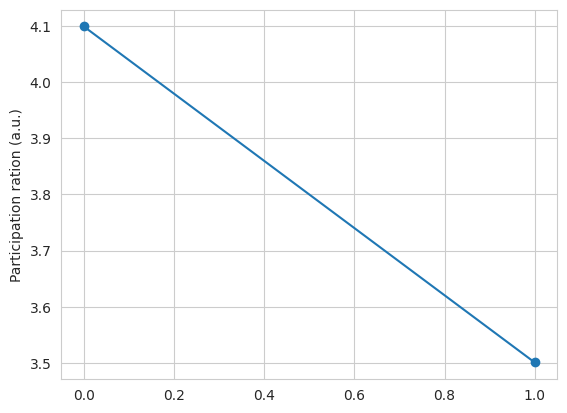

In [ ]:
plt.plot([0,1],[participation_ratio(lowres_averaged_early),participation_ratio(lowres_averaged_late)],marker='o')
plt.ylabel('Participation ration (a.u.)')

# Participation ratio early and late in session (using trials' data)
Spikes from each trial are convolved and then averaged over 1/3 of trials. This average spiking activity is time windowed, z-scored and therefrom a covariance matrix is built. The participation ratio is estimated from the eigenvalues of this covariance matrix.

In [6]:
def time_binning(spikes_df,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('trial').copy()

  num_trials = dataset.trial.nunique()
  num_neurons = dataset.neuron.nunique()

  duration = timespan[1] - timespan[0]
  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_trials,num_neurons,num_timebins])

  for trial_id,trial in enumerate(dataset.trial.unique()):
    for neuron_id,neuron in enumerate(dataset.neuron.unique()):
      spike_train = dataset.loc[(dataset['trial'] == trial) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.time,bins = np.linspace(timespan[0],timespan[1],num_timebins+1,endpoint=True))
      binned_spikes_matrix[trial_id,neuron_id,:] = discretized_spike_train

  return binned_spikes_matrix

def convolve_raster(binned_spikes):
    #Convolve a matrix containing the raster plots (time histogram of spikes) for all neurons in all trials

    #INPUT:
    # - binned_spikes: a trials x neurons x timebins matrix
    # - width: the kernel width, in ms
    # - sd: I haven't figured it out exactly yet: lower values widen the kernel shape and larger ones sharpen it
    #the authors didn't call it SD, I am extrapolating from my knowledge on gaussian filtering (might be wrong)

    #OUTPUT:
    # - convolved [np.ndarray(int,int,float)]: a trials x neurons x timebins matrix of convolved spiking activity

    x = np.linspace(0,750,750) #750 ms in 750 points

    kernel = np.exp(-x/100)
    kernel = np.pad(kernel,(750,0),'constant') #center the kernel at 0

    #uncomment these to plot the kernel
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)

    #uncomment these to plot evidence that the kernel drops to 1/e over the course of 100ms
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)


    #create a matrix with the same dimensions as the binned rasters' to accommodate the convolved rasters
    all_neurons_convolved = np.zeros(np.shape(binned_spikes))
    print(np.shape(all_neurons_convolved))

    #the # of trials, neurons and timebins are given by:
    trials,neurons,timebins = np.shape(binned_spikes)

    for trial in range(trials):
        for neuron in range(neurons):
            all_neurons_convolved[trial,neuron,:] = np.convolve(kernel,binned_spikes[trial,neuron,:]
                                                            ,mode='full')[750:-749]

    return all_neurons_convolved


In [7]:
def separate_rats(dataframe,check_num_neurons=True,min_num_neurons = 2):
    #Separate the dataframe by rat, and store each part as an entry in a list

    # INPUT:
    # - dataframe
    # - check_num_neurons: check whether a rat in this dataframe has less than min_num_neurons (default: True)
    # - min_num_neurons: the least amount of neurons an animal has to have in order to be included (default: 2)

    # OUTPUT:
    # - rats: a list of DataFrames, each entry being the subset of the main DataFrame with the spikes from one rat

    rats = []
    for rat in dataframe['rat'].unique():

        #Check whether a rat has only one registered neuron in the dataset
        if check_num_neurons:
            if dataframe.loc[dataframe['rat']==rat].neuron.nunique() < min_num_neurons:
                #If it's less than min_num_neurons, skip to the next animal
                continue
            #If one's not checking (check_num_neurons = False) or the animal has sufficient neurons, save it
        rats.append(dataframe.loc[dataframe['rat'] == rat])
    return rats #an array of dataframes (!)

def least_amount_neurons(dataset,num_cells_threshold = 4):
    #Drop trials with less than a given amount of neurons out of the dataset and find the least amount of units among all remaining trials that is not below this threshold

    #INPUT:
    # - dataset: pandas DataFrame [pd.df] (for columns and descriptions: see _specifications_)
    # - num_cells_threshold: the least amount of neurons required for inclusion of that trial

    #OUTPUT:
    # - pruned_dataset: the dataset (pd.df) cleared of the data pertaining to trials with less neurons than needed
    # - min_num_units: the minimum number of neurons all the remaining cells possess

    #Make a copy, so it'll not alter the given dataset
    pruned_dataset = dataset.copy()

    #Set the minimum amount of neurons to a high initial value
    min_num_units = 10_000 #a ludicrous amount of neurons

    #Check each trial for their number of neurons
    for trial in dataset.trial.unique():
        #if it falls below the threshold, remove it from the pruned_dataset
        if dataset.loc[dataset['trial'] == trial].neuron.nunique() < num_cells_threshold:
            pruned_dataset.drop(pruned_dataset.loc[pruned_dataset['trial']==trial].index,inplace=True)
            pass #skip to the next trial, so not to alter min_num_units with this trial

        #if it is not lower than this least amount, check if it is less than what was set to be the minimum so far
        elif dataset.loc[dataset['trial'] == trial].neuron.nunique() < min_num_units:
            min_num_units = dataset.loc[dataset['trial'] == trial].neuron.nunique()

    return pruned_dataset,min_num_units

def least_amount_spikes(dataset,num_spikes_threshold = 4):
    #Drop trials with less than a given amount of spikes out of the dataset

    #INPUT:
    # - dataset: pandas DataFrame [pd.df] (for columns and descriptions: see _specifications_)
    # - num_spikes_threshold: the least amount of neurons required for inclusion of that trial

    #OUTPUT:
    # - pruned_dataset: the dataset (pd.df) cleared of the data pertaining to trials with less spikes than required

    #Make a copy, so it'll not alter the given dataset
    pruned_dataset = dataset.copy()

    #Check each trial for their number of neurons
    for trial in dataset.trial.unique():
        #if it falls below the threshold, remove it from the pruned_dataset
        if len(dataset.loc[dataset['trial'] == trial]) < num_spikes_threshold:
            pruned_dataset.drop(pruned_dataset.loc[pruned_dataset['trial']==trial].index,inplace=True)

    return pruned_dataset

In [8]:
def lower_firing_rate_resolution(spike_activity_matrix,time_window_size=100):

  '''
  Lower the resolution of a firing rate matrix with dimensions neurons x time bins by averaging over a window

  INPUT:
  - spike_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x time, in which each element (i,j) of the matrix represents the firing rate of neuron i at the j-th time bin
  - time_window_size [int]: time window over which the firing rates will be averaged (in ms)

  OUTPUT:
  - lowres_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x low_restime_bins, in which each element (i,j) of the matrix
                                            represents the firing rate of neuron i at the j-th low resolution time bin (by default of 100 ms width)
  '''

  (num_neurons,num_timebins) = np.shape(spike_activity_matrix)

  lowres_timebins = int(num_timebins/time_window_size)

  lowres_activity_matrix = np.zeros([num_neurons,lowres_timebins])

  for time_bin in range(lowres_timebins):
    lowres_activity_matrix[:,time_bin] = np.mean(spike_activity_matrix[:,time_bin*100:(time_bin+1)*100],axis=1)

  return lowres_activity_matrix

def participation_ratio(spike_activity_matrix):
  '''
  Obtain the participation ratio of neurons (see Ganguli et al., 2017, https://doi.org/10.1101/214262) from a Z-scored activity matrix with its firing rates over time

  INPUT:
  - spike_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x time, in which each element (i,j) of the matrix represents the firing rate of neuron i at the j-th time bin
  OUTPUT:
  - participation_ratio [float]: a real value bound beetween [1,M] (M is the number of neurons) describing the number of dimensions required to describe the population activity
  '''

  #if the matrix has been normalized (the sum over columns differ from zero) then normalize it by subtracting the average of each neuron from all of its time bins
  if not np.isclose(np.sum(spike_activity_matrix,axis=0),np.zeros(len(np.sum(spike_activity_matrix,axis=0)))).all():
    #Z-scoring so each column sums up to 0
    spike_activity_matrix = spike_activity_matrix - spike_activity_matrix.mean(axis=0, keepdims=True)

  #Estimate the covariance
  #cov = spike_activity_matrix.T @ spike_activity_matrix / len(spike_activity_matrix)
  cov = np.cov(spike_activity_matrix)

  (L, P) = np.linalg.eigh(cov) #(eigenvalues, eigenvectors) of the covariance matrix yield the directions of most variance (e.g. firing patterns encompassing multiple neurons)

  #estimate the dimensionality
  participation_ratio = (np.sum(L))**2/np.sum([eigenvalue**2 for eigenvalue in L])

  return participation_ratio

def z_scored_participation_ratio(spike_activity_matrix):
  '''
  Obtain the participation ratio of neurons (see Ganguli et al., 2017, https://doi.org/10.1101/214262) from a Z-scored activity matrix with its firing rates over time

  INPUT:
  - spike_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x time, in which each element (i,j) of the matrix represents the firing rate of neuron i at the j-th time bin
  OUTPUT:
  - participation_ratio [float]: a real value bound beetween [1,M] (M is the number of neurons) describing the number of dimensions required to describe the population activity
  '''

  #if the matrix has been normalized (the sum over columns differ from zero) then normalize it by subtracting the average of each neuron from all of its time bins
  if not np.isclose(np.sum(spike_activity_matrix,axis=0),np.zeros(len(np.sum(spike_activity_matrix,axis=0)))).all():
    #Z-scoring so each column sums up to 0
    spike_activity_matrix = scipy.stats.zscore(spike_activity_matrix,axis=0) # - spike_activity_matrix.mean(axis=0, keepdims=True)

  #Estimate the covariance
  #cov = spike_activity_matrix.T @ spike_activity_matrix / len(spike_activity_matrix)
  cov = np.cov(spike_activity_matrix)

  (L, P) = np.linalg.eigh(cov) #(eigenvalues, eigenvectors) of the covariance matrix yield the directions of most variance (e.g. firing patterns encompassing multiple neurons)

  #estimate the dimensionality
  participation_ratio = (np.sum(L))**2/np.sum([eigenvalue**2 for eigenvalue in L])

  return participation_ratio

In [9]:
def early_late_dimensionality_per_rat(separated_rats,group,day,region,num_bins = 15):
  dimensionality_results_early = []
  dimensionality_results_late = []
  rats_ids = []

  least_amount_of_trials = min([animal.trial.nunique() for animal in separated_rats])
  trials_in_thirds = int(least_amount_of_trials/3)

  for animal in separated_rats:
      #Get the animal's label to later identify it in the DataFrame
      animal_label = animal.rat.unique()[0]
      print('Beginning the analyses for the rat: ',animal_label)

      animal_pruned = least_amount_spikes(animal,num_spikes_threshold=5)
      current_num_neurons = animal_pruned.neuron.nunique()

      print(animal_pruned.trial.nunique())

      binned_spikes = time_binning(animal_pruned)
      convolved_spikes = convolve_raster(binned_spikes)

      #average over the first and last third of trials
      averaged_early = np.mean(convolved_spikes[0:trials_in_thirds,:,:],axis=0)
      averaged_late = np.mean(convolved_spikes[-trials_in_thirds:,:,:],axis=0)

      #lower the time resolution (from 1 ms resolution to 100 ms resolution by averaging over this 100 ms window)
      lowres_averaged_early = lower_firing_rate_resolution(averaged_early)
      lowres_averaged_late = lower_firing_rate_resolution(averaged_late)

      participation_ratio_early = participation_ratio(lowres_averaged_early)
      participation_ratio_late = participation_ratio(lowres_averaged_late)

      print(participation_ratio_early)
      print(participation_ratio_late)

      dimensionality_results_early.append(participation_ratio_early)
      dimensionality_results_late.append(participation_ratio_late)

      rats_ids.append(animal_label)

  early_tags = ['early' for i in range(len(separated_rats))]
  late_tags = ['late' for i in range(len(separated_rats))]

  all_tags = early_tags+late_tags

  df = pd.DataFrame({'participation_ratio':dimensionality_results_early+dimensionality_results_late,'animal_id':rats_ids*2,'session_part':all_tags,'group':group,'day':day,'region':region})

  return df

In [ ]:
def query_session(spikes_dataframe,group,day,region,filter_trials_between=[1.5,3.5],peri_trial_interval=-0.5):
  data_subset = spikes_dataframe.query(f'group == {group} and day == {day} and region == "{region}" and duration >= {filter_trials_between[0]} and duration <= {filter_trials_between[1]}' +
                                       f'and time >= {peri_trial_interval} and time <= {filter_trials_between[0]}').copy()

  return data_subset

data = session_data.copy()

######## Group 1, day 1 ###########

separated_rats = separate_rats(query_session(data,group=1,day=1,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g1d1_PFC = early_late_dimensionality_per_rat(separated_rats,group=1,region='PFC',day=1)

######## Group 2, day 1 ###########
separated_rats = separate_rats(query_session(data,group=2,day=1,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g2d1_PFC = early_late_dimensionality_per_rat(separated_rats,group=2,region='PFC',day=1)

separated_rats = separate_rats(query_session(data,group=2,day=1,region='STR'),check_num_neurons=True,min_num_neurons = 4)
g2d1_STR = early_late_dimensionality_per_rat(separated_rats,group=2,region='STR',day=1)


######## Group 2, day 2 ###########
separated_rats = separate_rats(query_session(data,group=2,day=2,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g2d2_PFC = early_late_dimensionality_per_rat(separated_rats,group=2,region='PFC',day=2)

separated_rats = separate_rats(query_session(data,group=2,day=2,region='STR'),check_num_neurons=True,min_num_neurons = 4)
g2d2_STR = early_late_dimensionality_per_rat(separated_rats,group=2,region='STR',day=2)

both_days_both_regions_df = pd.concat([g1d1_PFC,g2d1_PFC,g2d1_STR,g2d2_PFC,g2d2_STR])

Beginning the analyses for the rat:  7
603


KeyboardInterrupt: ignored

In [ ]:
both_days_both_regions_df

,participation_ratio,animal_id,session_part,group,day,region
0,1.136552,7,early,1,1,PFC
1,1.462781,8,early,1,1,PFC
2,1.598648,9,early,1,1,PFC
3,1.351227,10,early,1,1,PFC
4,1.642134,7,late,1,1,PFC
5,1.420207,8,late,1,1,PFC
6,1.794154,9,late,1,1,PFC
7,2.076368,10,late,1,1,PFC
0,1.689521,3,early,2,1,PFC
1,2.963670,4,early,2,1,PFC


TtestResult(statistic=-0.07947784223731516, pvalue=0.943889218073727, df=2)


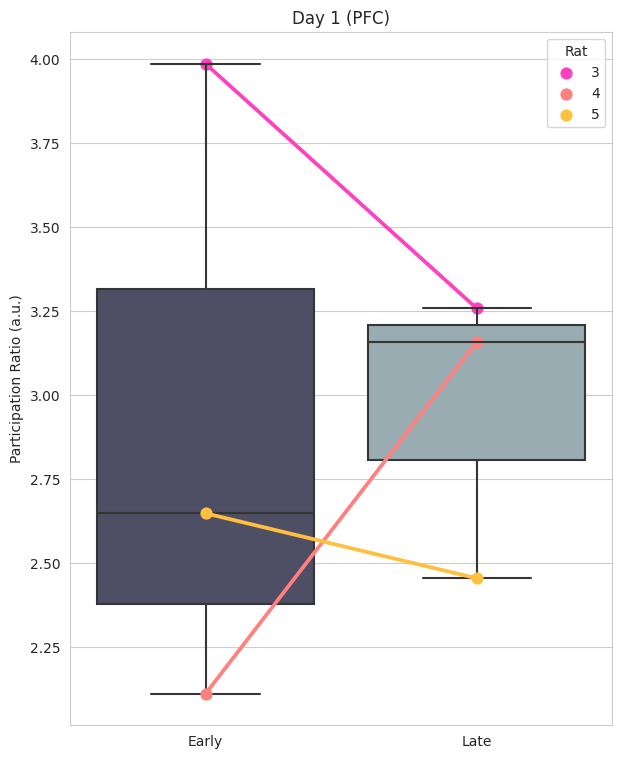

In [ ]:
#column name, plot name for column, color scheme
variable_of_interest = ['participation_ratio','Participation Ratio','spring']

#plots:
#PFC day 1 (early, late)
current = both_days_both_regions_df.query('region == "PFC" and day == 2')

plt.figure(figsize=(7,9))
#sns.set_style("darkgrid")
sns.set_style("whitegrid")
sns.boxplot(data = current,x=current['session_part'].values,y=current[variable_of_interest[0]].values,palette = 'bone')
sns.pointplot(data = current,x=current['session_part'].values,y=current[variable_of_interest[0]].values,hue=current['animal_id'].values,palette = variable_of_interest[2])
plt.title('Day 1 (PFC)')
plt.xticks(plt.xticks()[0],['Early','Late'])
plt.ylabel(f'{variable_of_interest[1]} (a.u.)')
plt.legend(title='Rat')

import scipy.stats as stats

pre = current.query('session_part == "early"')[variable_of_interest[0]].values
post = current.query('session_part == "late"')[variable_of_interest[0]].values

# Performing the paired sample t-test
print(stats.ttest_rel(pre, post))

TtestResult(statistic=1.530364108778922, pvalue=0.26557213390931905, df=2)


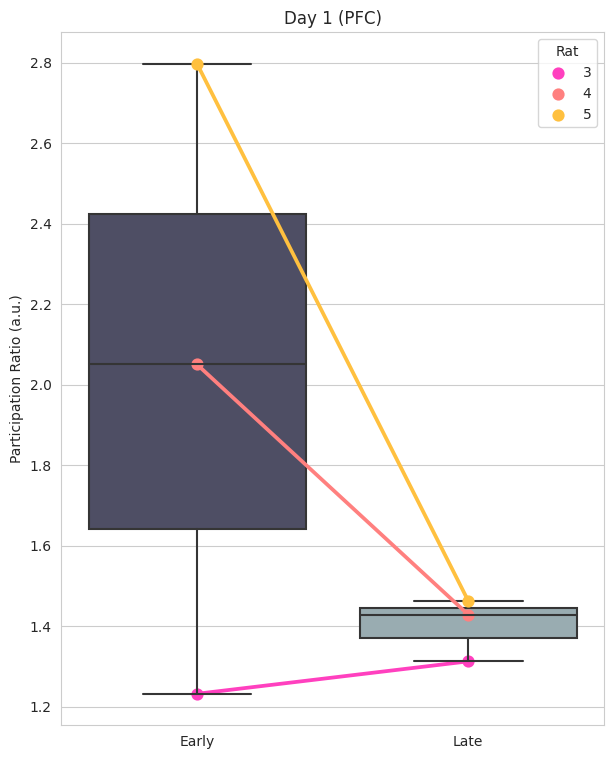

In [ ]:
#column name, plot name for column, color scheme
variable_of_interest = ['participation_ratio','Participation Ratio','spring']

#plots:
#PFC day 1 (early, late)
current = both_days_both_regions_df.query('region == "STR" and day == 1')

plt.figure(figsize=(7,9))
#sns.set_style("darkgrid")
sns.set_style("whitegrid")
sns.boxplot(data = current,x=current['session_part'].values,y=current[variable_of_interest[0]].values,palette = 'bone')
sns.pointplot(data = current,x=current['session_part'].values,y=current[variable_of_interest[0]].values,hue=current['animal_id'].values,palette = variable_of_interest[2])
plt.title('Day 1 (PFC)')
plt.xticks(plt.xticks()[0],['Early','Late'])
plt.ylabel(f'{variable_of_interest[1]} (a.u.)')
plt.legend(title='Rat')

import scipy.stats as stats

pre = current.query('session_part == "early"')[variable_of_interest[0]].values
post = current.query('session_part == "late"')[variable_of_interest[0]].values

# Performing the paired sample t-test
print(stats.ttest_rel(pre, post))

# Pooling neurons from all animals

We can only pool neurons with clipped session segments of equal duration, so we can stack the neurons x timebins matrix from each animal.

**Approach 1:** (that was the chosen one)
Only use pooling early/late only during session and discard the awake pre- and post-session periods altogether because they have different periods

Approach 2:
Clipping segments of equal length in the pre- and post-session awake periods and pool over them as well

In [10]:
def pooled_neurons_participation_ratio_comparison(separated_rats_list,binning_timespan = [-0.5,1.5],lowres_binning_span=100):

  '''
  Clip each trial within the temporal range specified by "binning_timespan", binarize in a 1-ms-resolution, convolve with an exponential kernel with a 100 ms smoothing window, lower the temporal resolution
  to 100 ms bins and store this in a matrix with dimensions trial x neuron x time bin for each animal. Then average trials over the early/late periods from each rat and pool the neurons across animals
  to yield two matrices (early, late) with dimensions neurons x time bin, which represents activity from all neurons (i.e. from all animals) recorded in that day/region.

  Estimate the participation ratio in each of these two matrices (early and late in session) and compare their significance with a jackknife procedure if required.

  INPUT:
  - separated_rats: a list of DataFrames, each entry being the subset of the main DataFrame with the spikes from one rat. See separate_rats() above for more information.
  - binning_timespan [list[float]]: the timespan in which to trim each trial (e.g. the first 1s, from [0,1]) (given in seconds, default: from -0.5 s to 1.5 s, [-0.5,1.5])
  - lowres_binning_span [int]: length (in time) of each bin for lowering the resolution of the firing rate (given in ms, default: 100)

  OUTPUT:
  - lowres_pooled_activity_matrices [NumPy ndarray]: two matrices (early, late) with dimensions neurons x time bin, which represents activity from all neurons recorded in that day/region
  - participation_ratios [float]: dimensionality of early and late session activity, as estimated from the participation ratio (see also the participation_ratio() function)
  - jack_corrected_t-score, jack_corrected_pvalue [float]: corrected t-score between resamples in a Jackknife procedure and its associated p-value
  '''

  #Find the session with the least trials and truncate all other sessions at this count, so that early/late comparisons across animals make sense
  #P.S.: If we only got the first/last third of trials (or the first/last N trials) from each animal we would be comparing extremely different distributions
  #e.g. fetching the first and last ones from the animal that made ~200 trials is way different than the same and last from the animal with more than a 1000 attempts
  #Our chosen (and rather conservative) approach is to truncate all sessions at the amount of rewarded trials from the animal with the least
  least_amount_of_trials = min([animal.trial.nunique() for animal in separated_rats_list])
  trials_in_thirds = int(least_amount_of_trials/3)
  print(f'Trial count in the shortest session: {least_amount_of_trials}. Trials in early/late session (thirds of this shortest trial count): {trials_in_thirds}')

  #the number of unique neurons is less than the total number of neurons because some of different rat's neurons have the same numeric value corresponding to them:
  neurons_count = 0

  rats_dfs = []
  for rat in separated_rats_list:
    #pruned_df = least_amount_spikes(rat,10)

    print('rat',rat.rat.unique()[0],' has ', rat.neuron.nunique(),' different neurons')
    neurons_count+= rat.neuron.nunique()

    rats_dfs.append(rat)

  print('number of "unique" neurons according to pandas: ',data_subset.neuron.nunique(),' \nActual count of unique neurons: ',neurons_count)

  #make a recipient for all of a region's neurons;after convolving and taking the mean, this will be the number of bins we will reduce our series to
  num_timebins = int(1000*(binning_timespan[1] - binning_timespan[0])/lowres_binning_span) #multiply the numerator by 1000 because it is in seconds and the denominator is in miliseconds

  first_trials_activty_matrix = np.empty([neurons_count,num_timebins])
  last_trials_activty_matrix = np.empty([neurons_count,num_timebins])

  session_slice = trials_in_thirds #number of trials we avereage over

  #Binarize, convolve and lower the resolution of the activity for each rat, then aggregate them into a pooled activity matrix
  neuron_count = 0

  for current_rat_df in rats_dfs:
    current_num_neurons = current_rat_df.neuron.nunique()

    #bin in time
    binned = time_binning(current_rat_df,timespan = [-0.5,1.5])
    #convolve and trim the matrix up to the maximum number of trials in the rat with least trials
    convolved = convolve_raster(binned)[0:least_amount_of_trials,:,:]

    #average over N trials (N first, N last)
    first_mean_convolved = np.expand_dims(np.mean(convolved[0:session_slice,:,:],axis=0),axis=0)
    last_mean_convolved = np.expand_dims(np.mean(convolved[-session_slice:,:,:],axis=0),axis=0)

    #lower the resolution and store in the pooled activity matrix for each segment (early or late in session)
    for i in range(num_timebins):
      first_trials_activty_matrix[neuron_count:neuron_count+current_num_neurons,i] = np.mean(first_mean_convolved[0,:,i*100:(i+1)*100],axis=1)
      last_trials_activty_matrix[neuron_count:neuron_count+current_num_neurons,i] = np.mean(last_mean_convolved[0,:,i*100:(i+1)*100],axis=1)

    neuron_count+= current_num_neurons

  pr_early = participation_ratio(first_trials_activty_matrix)
  pr_late = participation_ratio(last_trials_activty_matrix)

  #jackknife procedure
  jack_resamples_early = []
  jack_resamples_late = []

  #each resample will remove one of them from the pool; number of resamples = number of neurons (which is the same early and late in session)
  N = np.shape(first_trials_activty_matrix)[0]

  for line in range(N):
    def resample(matrix,line):
      return np.delete(matrix,(line),axis=0)

    jack_resamples_early.append(participation_ratio(resample(first_trials_activty_matrix,line)))
    jack_resamples_late.append(participation_ratio(resample(last_trials_activty_matrix,line)))


  t_statistic,p_value=scipy.stats.ttest_rel(jack_resamples_early,jack_resamples_late)

  corrected_t_statistic = t_statistic/(N-1)
  corrected_p_value = scipy.stats.t.sf(abs(t_statistic/(N-1)),df=(N-1))

  results_dict = {'first_trials_activity':first_trials_activty_matrix,'last_trials_activity':last_trials_activty_matrix,
                  'jackknife_t_score':corrected_t_statistic,'jackknife_p_value':corrected_p_value}
  return results_dict

In [ ]:
data = session_data.copy()

#select group/region/day/eligible trials (duration criteria [1.5,3.5])/eligible spikes (time-in-trial criteria, [-0.5,1.5])
filter_trials_between = [1.5,3.5]

data_subset = data.loc[(data['day']== 2) & (data['region']== 'PFC')
                    & (data['duration']>=filter_trials_between[0]) & (data['duration']<=filter_trials_between[1])
                    & (data['time']>=-0.5) & (data['time']<=filter_trials_between[0])]

separated_rats = separate_rats(data_subset,check_num_neurons=False)

In [ ]:
results_dict = pooled_neurons_participation_ratio_comparison(separated_rats)

Trial count in the shortest session: 175. Trials in early/late session (thirds of this shortest trial count): 58
rat 3  has  14  different neurons
rat 4  has  28  different neurons
rat 5  has  5  different neurons
rat 6  has  3  different neurons
number of "unique" neurons according to pandas:  38  
Actual count of unique neurons:  50
(398, 14, 2000)
(175, 28, 2000)
(192, 5, 2000)
(366, 3, 2000)


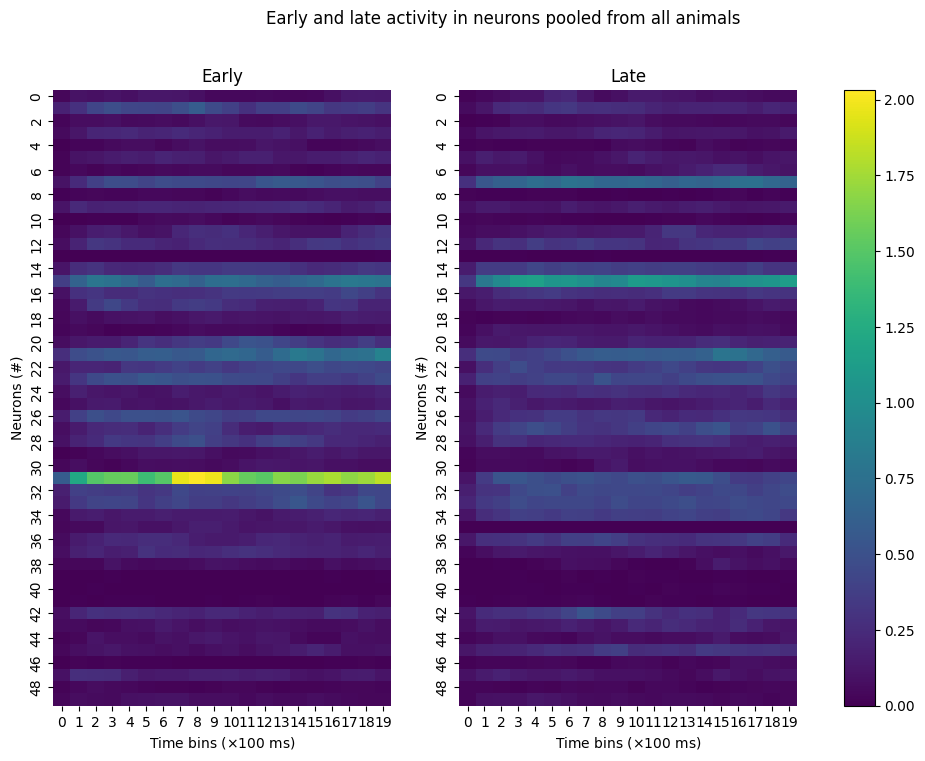

In [ ]:
import matplotlib
from matplotlib.colors import Normalize
import matplotlib.cm as cm

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,8))

cmap = matplotlib.colormaps['viridis']
normalizer=Normalize(0,max(results_dict['first_trials_activity'].max(),results_dict['last_trials_activity'].max()))
im = cm.ScalarMappable(norm=normalizer)

sns.heatmap(results_dict['first_trials_activity'][:,:],cmap='viridis',norm=normalizer,ax=axes[0],cbar=False)
sns.heatmap(results_dict['last_trials_activity'][:,:],cmap='viridis',norm=normalizer,ax=axes[1],cbar=False)

fig.colorbar(im, ax=axes.ravel().tolist())

fig.suptitle('Early and late activity in neurons pooled from all animals')
axes[0].set_title('Early')
axes[1].set_title('Late')

axes[0].set_ylabel('Neurons (#)')
axes[1].set_ylabel('Neurons (#)')

axes[0].set_xlabel(r'Time bins ($\times 100$ ms)')
axes[1].set_xlabel(r'Time bins ($\times 100$ ms)')

plt.show()

0.318968815020058


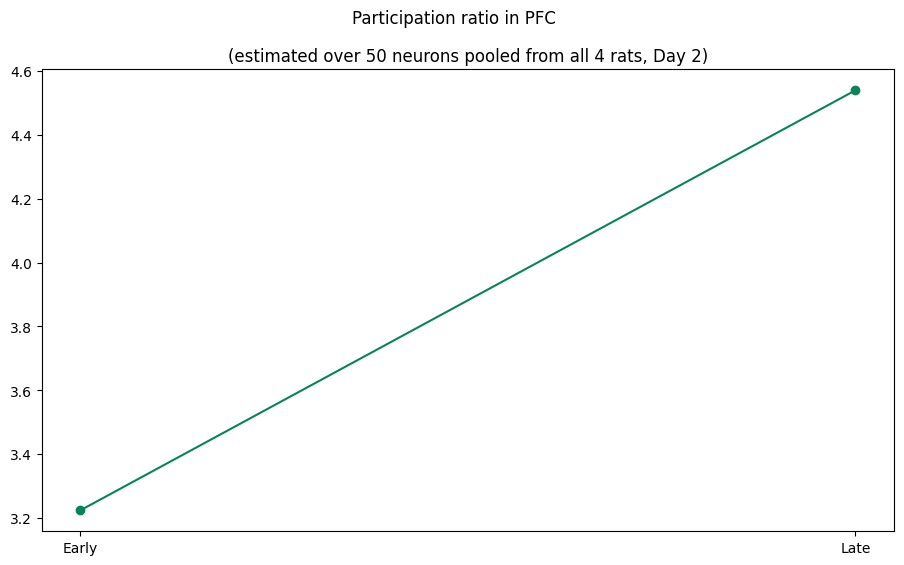

In [ ]:
region = 'PFC'
day_id = 2

pr_early = participation_ratio(results_dict['first_trials_activity'])
pr_late = participation_ratio(results_dict['last_trials_activity'])

plt.figure(figsize=(11,6))
plt.plot(['Early','Late'],[pr_early,pr_late],marker='o',color='#09835A')
plt.suptitle(f'Participation ratio in {region}')
plt.title(f'(estimated over {len(results_dict["first_trials_activity"])} neurons pooled from all {len(separated_rats)} rats, Day {day_id})');

print(results_dict['jackknife_p_value'])

# Comparing pooled results from distinct regions/sessions

In [11]:
def pooled_neurons_early_late(separated_rats_list,binning_timespan = [-0.5,1.5],lowres_binning_span=100):

  '''
  Clip each trial within the temporal range specified by "binning_timespan", binarize in a 1-ms-resolution, convolve with an exponential kernel with a 100 ms smoothing window, lower the temporal resolution
  to 100 ms bins and store this in a matrix with dimensions trial x neuron x time bin for each animal. Then average trials over the early/late periods from each rat and pool the neurons across animals
  to yield two matrices (early, late) with dimensions neurons x time bin, which represents activity from all neurons (i.e. from all animals) recorded in that day/region.

  INPUT:
  - separated_rats: a list of DataFrames, each entry being the subset of the main DataFrame with the spikes from one rat. See separate_rats() above for more information.
  - binning_timespan [list[float]]: the timespan in which to trim each trial (e.g. the first 1s, from [0,1]) (given in seconds, default: from -0.5 s to 1.5 s, [-0.5,1.5])
  - lowres_binning_span [int]: length (in time) of each bin for lowering the resolution of the firing rate (given in ms, default: 100)

  OUTPUT:
  - lowres_pooled_activity_matrices [NumPy ndarray]: two matrices (early, late) with dimensions neurons x time bin, which represents activity from all neurons recorded in that day/region
  '''

  #Find the session with the least trials and truncate all other sessions at this count, so that early/late comparisons across animals make sense
  #P.S.: If we only got the first/last third of trials (or the first/last N trials) from each animal we would be comparing extremely different distributions
  #e.g. fetching the first and last ones from the animal that made ~200 trials is way different than the same and last from the animal with more than a 1000 attempts
  #Our chosen (and rather conservative) approach is to truncate all sessions at the amount of rewarded trials from the animal with the least
  least_amount_of_trials = min([animal.trial.nunique() for animal in separated_rats_list])
  trials_in_thirds = int(least_amount_of_trials/3)
  print(f'Trial count in the shortest session: {least_amount_of_trials}. Trials in early/late session (thirds of this shortest trial count): {trials_in_thirds}')

  #the number of unique neurons is less than the total number of neurons because some of different rat's neurons have the same numeric value corresponding to them:
  neurons_count = 0

  rats_dfs = []
  for rat in separated_rats_list:
    #pruned_df = least_amount_spikes(rat,10)

    print('rat',rat.rat.unique()[0],' has ', rat.neuron.nunique(),' different neurons')
    neurons_count+= rat.neuron.nunique()

    rats_dfs.append(rat)

  print('number of "unique" neurons according to pandas: ',data_subset.neuron.nunique(),' \nActual count of unique neurons: ',neurons_count)

  #make a recipient for all of a region's neurons;after convolving and taking the mean, this will be the number of bins we will reduce our series to
  num_timebins = int(1000*(binning_timespan[1] - binning_timespan[0])/lowres_binning_span) #multiply the numerator by 1000 because it is in seconds and the denominator is in miliseconds

  first_trials_activty_matrix = np.empty([neurons_count,num_timebins])
  last_trials_activty_matrix = np.empty([neurons_count,num_timebins])

  session_slice = trials_in_thirds #number of trials we avereage over

  #Binarize, convolve and lower the resolution of the activity for each rat, then aggregate them into a pooled activity matrix
  neuron_count = 0

  for current_rat_df in rats_dfs:
    current_num_neurons = current_rat_df.neuron.nunique()

    #bin in time
    binned = time_binning(current_rat_df,timespan = [-0.5,1.5])
    #convolve and trim the matrix up to the maximum number of trials in the rat with least trials
    convolved = convolve_raster(binned)[0:least_amount_of_trials,:,:]

    #average over N trials (N first, N last)
    first_mean_convolved = np.expand_dims(np.mean(convolved[0:session_slice,:,:],axis=0),axis=0)
    last_mean_convolved = np.expand_dims(np.mean(convolved[-session_slice:,:,:],axis=0),axis=0)

    #lower the resolution and store in the pooled activity matrix for each segment (early or late in session)
    for i in range(num_timebins):
      first_trials_activty_matrix[neuron_count:neuron_count+current_num_neurons,i] = np.mean(first_mean_convolved[0,:,i*100:(i+1)*100],axis=1)
      last_trials_activty_matrix[neuron_count:neuron_count+current_num_neurons,i] = np.mean(last_mean_convolved[0,:,i*100:(i+1)*100],axis=1)

    neuron_count+= current_num_neurons

  return first_trials_activty_matrix,last_trials_activty_matrix

In [19]:
#select group/region/day/eligible trials (duration criteria [1.5,3.5])/eligible spikes (time-in-trial criteria, [-0.5,1.5])
filter_trials_between = [1.5,3.5]
data = session_data.copy()


#PFC
data_subset = data.loc[(data['day']== 1) & (data['region']== 'PFC')
                    & (data['duration']>=filter_trials_between[0]) & (data['duration']<=filter_trials_between[1])
                    & (data['time']>=-0.5) & (data['time']<=filter_trials_between[0])]

separated_rats_PFC = separate_rats(data_subset,check_num_neurons=False)


#STR
data_subset = data.loc[(data['day']== 1) & (data['region']== 'STR')
                    & (data['duration']>=filter_trials_between[0]) & (data['duration']<=filter_trials_between[1])
                    & (data['time']>=-0.5) & (data['time']<=filter_trials_between[0])]

separated_rats_STR = separate_rats(data_subset,check_num_neurons=False)

In [ ]:
early_PFC_g2d1,late_PFC_g2d1 = pooled_neurons_early_late(separated_rats_PFC)

early_STR_g2d1,late_STR_g2d1 = pooled_neurons_early_late(separated_rats_STR)

early_STR_g2d2,late_STR_g2d2 = pooled_neurons_early_late(separated_rats_STR)

Trial count in the shortest session: 147. Trials in early/late session (thirds of this shortest trial count): 49
rat 7  has  17  different neurons
rat 8  has  35  different neurons
rat 9  has  10  different neurons
rat 10  has  9  different neurons
rat 3  has  4  different neurons
rat 4  has  33  different neurons
rat 5  has  5  different neurons
rat 6  has  4  different neurons
number of "unique" neurons according to pandas:  33  
Actual count of unique neurons:  117
(604, 17, 2000)
(407, 35, 2000)
(362, 10, 2000)
(907, 9, 2000)
(262, 4, 2000)
(182, 33, 2000)
(147, 5, 2000)
(385, 4, 2000)
Trial count in the shortest session: 147. Trials in early/late session (thirds of this shortest trial count): 49
rat 3  has  12  different neurons
rat 4  has  26  different neurons
rat 5  has  16  different neurons
rat 6  has  1  different neurons
number of "unique" neurons according to pandas:  33  
Actual count of unique neurons:  55
(262, 12, 2000)
(182, 26, 2000)
(147, 16, 2000)
(234, 1, 2000)
Tr

In [24]:
def loc_and_separate(data,day_id,region_id,trial_duration_criteria,spike_time_criteria,check_num_neurons=False):
  data_subset = data.loc[(data['day']== day_id) & (data['region']== region_id)
                    & (data['duration']>=trial_duration_criteria[0]) & (data['duration']<=trial_duration_criteria[1])
                    & (data['time']>=spike_time_criteria[0]) & (data['time']<=spike_time_criteria[1])]
  return separate_rats(data_subset,check_num_neurons)

PFC_d1 = loc_and_separate(data,day_id = 1, region_id = 'PFC', trial_duration_criteria=[1.5,3.5], spike_time_criteria = [-0.5,1.5])
PFC_d2 = loc_and_separate(data,day_id = 2, region_id = 'PFC', trial_duration_criteria=[1.5,3.5], spike_time_criteria = [-0.5,1.5])

STR_d1 = loc_and_separate(data,day_id = 1, region_id = 'STR', trial_duration_criteria=[1.5,3.5], spike_time_criteria = [-0.5,1.5])
STR_d2 = loc_and_separate(data,day_id = 2, region_id = 'STR', trial_duration_criteria=[1.5,3.5], spike_time_criteria = [-0.5,1.5])

early_PFC_g2d1,late_PFC_g2d1 = pooled_neurons_early_late(PFC_d1)
early_STR_g2d1,late_STR_g2d1 = pooled_neurons_early_late(STR_d1)
early_PFC_g2d2,late_PFC_g2d2 = pooled_neurons_early_late(PFC_d2)
early_STR_g2d2,late_STR_g2d2 = pooled_neurons_early_late(STR_d2)

Trial count in the shortest session: 147. Trials in early/late session (thirds of this shortest trial count): 49
rat 7  has  17  different neurons
rat 8  has  35  different neurons
rat 9  has  10  different neurons
rat 10  has  9  different neurons
rat 3  has  4  different neurons
rat 4  has  33  different neurons
rat 5  has  5  different neurons
rat 6  has  4  different neurons
number of "unique" neurons according to pandas:  33  
Actual count of unique neurons:  117
(604, 17, 2000)
(407, 35, 2000)
(362, 10, 2000)
(907, 9, 2000)
(262, 4, 2000)
(182, 33, 2000)
(147, 5, 2000)
(385, 4, 2000)
Trial count in the shortest session: 147. Trials in early/late session (thirds of this shortest trial count): 49
rat 3  has  12  different neurons
rat 4  has  26  different neurons
rat 5  has  16  different neurons
rat 6  has  1  different neurons
number of "unique" neurons according to pandas:  33  
Actual count of unique neurons:  55
(262, 12, 2000)
(182, 26, 2000)
(147, 16, 2000)
(234, 1, 2000)
Tr

In [12]:
'Activity in neurons pooled from either region in all animals'

def pool_comparison_plot(pool1_data,pool2_data,plot_title='',individual_heatmap_titles=['','']):
  '''
  Plot two heatmaps side by side, colored with the same colormap and scale.

  INPUT:
  - pool_data: a 2D matrix (neurons x timebins)
  '''

  import matplotlib
  from matplotlib.colors import Normalize
  import matplotlib.cm as cm

  fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,8))

  cmap = matplotlib.colormaps['viridis']
  normalizer=Normalize(0,max(pool1_data.max(),pool2_data.max())) #find the maximum firing rate and normalize from 0 up to it
  im = cm.ScalarMappable(norm=normalizer)

  sns.heatmap(pool1_data[:,:],cmap='viridis',norm=normalizer,ax=axes[0],cbar=False)
  sns.heatmap(pool2_data[:,:],cmap='viridis',norm=normalizer,ax=axes[1],cbar=False)

  fig.colorbar(im, ax=axes.ravel().tolist())

  fig.suptitle(plot_title)
  axes[0].set_title(individual_heatmap_titles[0])
  axes[1].set_title(individual_heatmap_titles[1])

  axes[0].set_ylabel('Neurons (#)')
  axes[1].set_ylabel('Neurons (#)')

  axes[0].set_xlabel(r'Time bins ($\times 100$ ms)')
  axes[1].set_xlabel(r'Time bins ($\times 100$ ms)')

  plt.show()

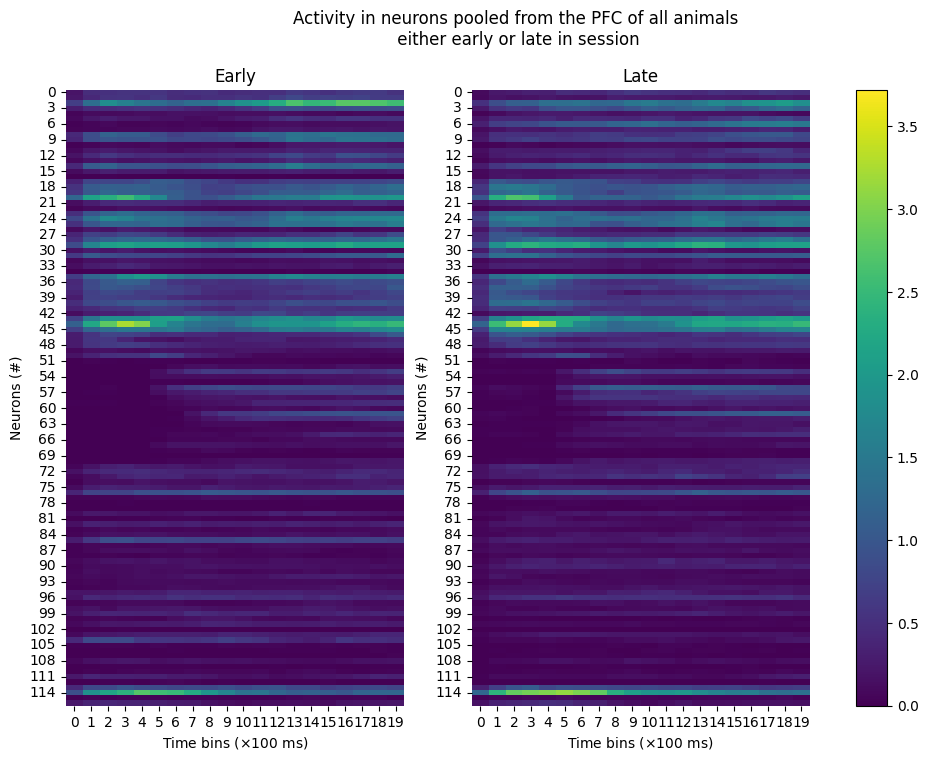

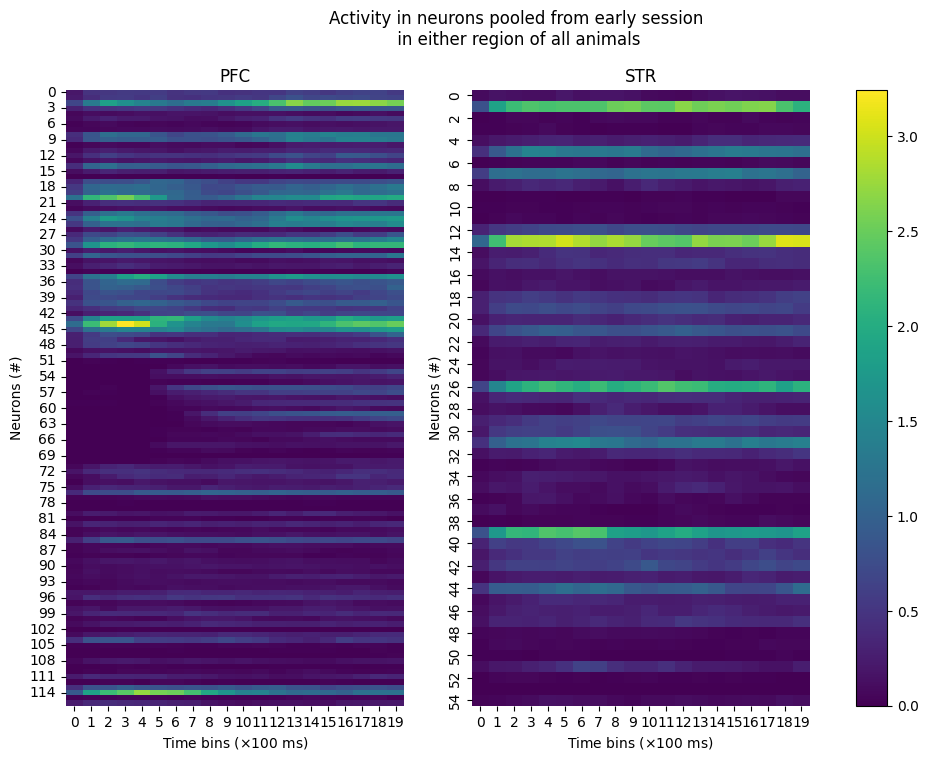

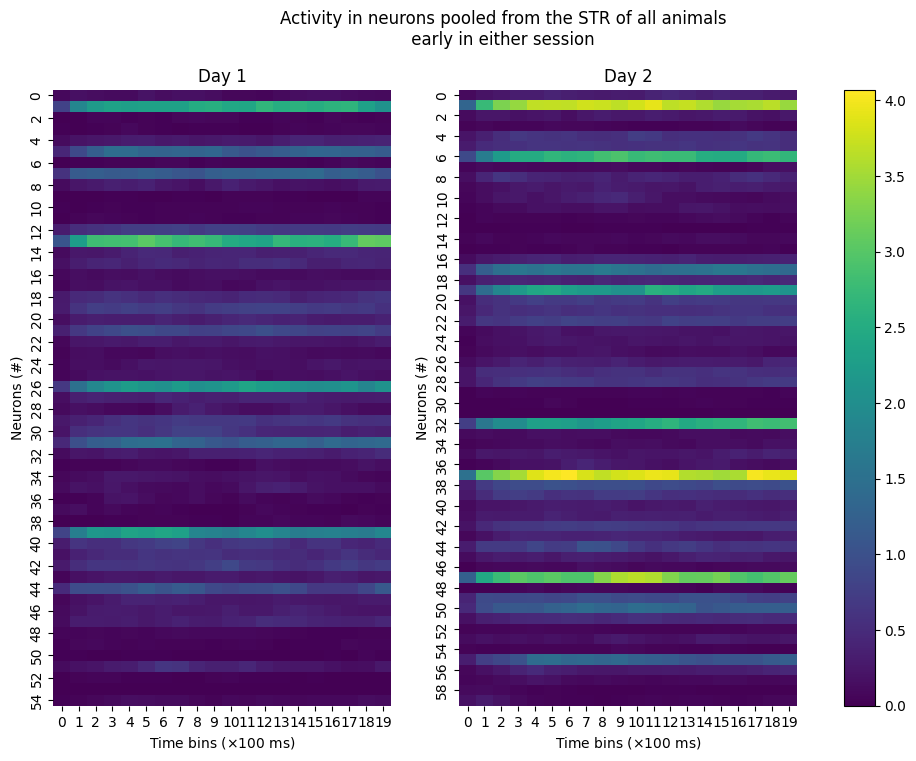

In [ ]:
#Example usages

#comparing session stages in the same region
pool_comparison_plot(early_PFC_g2d1,late_PFC_g2d1,'Activity in neurons pooled from the PFC of all animals\n either early or late in session',individual_heatmap_titles=['Early','Late'])

#comparing both regions
pool_comparison_plot(early_PFC_g2d1,early_STR_g2d1,'Activity in neurons pooled from early session\n in either region of all animals',individual_heatmap_titles=['PFC','STR'])

#comparing both days
pool_comparison_plot(early_STR_g2d1,early_STR_g2d2,'Activity in neurons pooled from the STR of all animals\n early in either session ',individual_heatmap_titles=['Day 1','Day 2'])

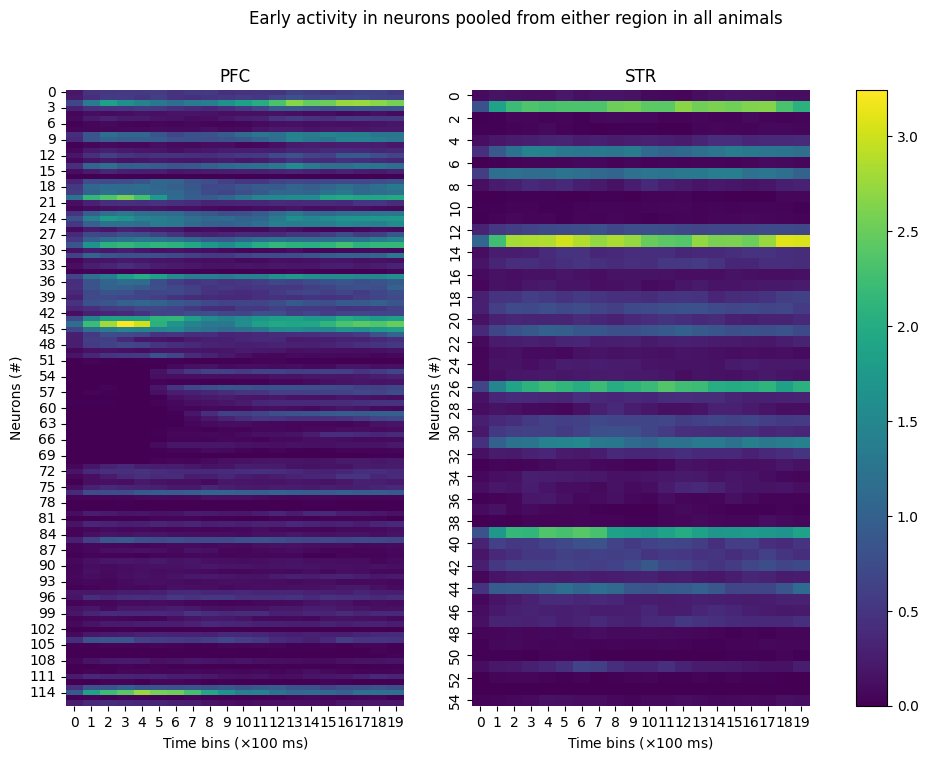

In [ ]:
import matplotlib
from matplotlib.colors import Normalize
import matplotlib.cm as cm

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,8))

cmap = matplotlib.colormaps['viridis']
normalizer=Normalize(0,max(early_PFC_g2d1.max(),early_STR_g2d1.max()))
im = cm.ScalarMappable(norm=normalizer)

sns.heatmap(early_PFC_g2d1[:,:],cmap='viridis',norm=normalizer,ax=axes[0],cbar=False)
sns.heatmap(early_STR_g2d1[:,:],cmap='viridis',norm=normalizer,ax=axes[1],cbar=False)

fig.colorbar(im, ax=axes.ravel().tolist())

fig.suptitle('Early activity in neurons pooled from either region in all animals')
axes[0].set_title('PFC')
axes[1].set_title('STR')

axes[0].set_ylabel('Neurons (#)')
axes[1].set_ylabel('Neurons (#)')

axes[0].set_xlabel(r'Time bins ($\times 100$ ms)')
axes[1].set_xlabel(r'Time bins ($\times 100$ ms)')

plt.show()

<Axes: >

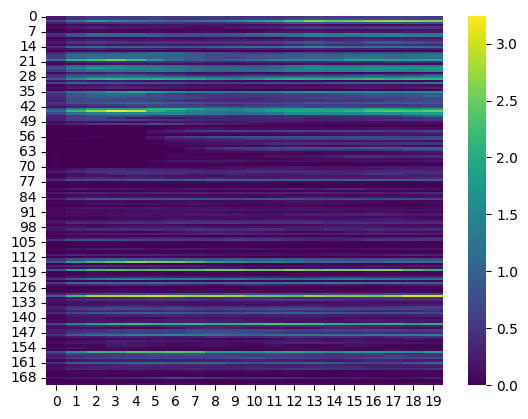

In [ ]:
new_matrix = np.vstack((early_PFC_g2d1,early_STR_g2d1))

sns.heatmap(new_matrix[:,:],cmap='viridis')

In [13]:
def bootstrapped_pools_participation_ratio_comparison(pool1_data,pool2_data,nruns=1000,alpha=0.95,two_tailed=True,figlabel=None):
  '''
  Create new neuron pool samples by sampling with replacement from a matrix stacking activity in both pools. Estimate the
  '''

  combined_samples = np.vstack((pool1_data,pool2_data))

  diffs = []
  abs = []

  for _ in range(nruns):
    #create two random samples by resampling with replacement the combined neuron pool from both conditions; the number of sampled neurons is the same as the least in both conditions
    #(ex: the region with least neurons has 50 neurons, all samples will have this number)
    sample1 = np.random.choice(np.shape(combined_samples)[0],np.shape(pool1_data)[0],replace=False)
    sample2 = np.random.choice(np.shape(combined_samples)[0],np.shape(pool2_data)[0],replace=False)

    #estimate the difference in participation ratios from matrices with neurons corresponding to each sample and store this in a distribution of participation ratio differences
    abs.append(participation_ratio(combined_samples[sample1,:]))
    abs.append(participation_ratio(combined_samples[sample2,:]))
    diffs.append(participation_ratio(combined_samples[sample1,:]) - participation_ratio(combined_samples[sample2,:]))

  original_diff = participation_ratio(pool1_data) - participation_ratio(pool2_data)


  # confidence intervals
  if two_tailed:
    lower = np.percentile(diffs,((1-alpha)/2)*100) #e.g. at 95% confidence: 0.05/2 * 100 => 2.5%
    upper = np.percentile(diffs,((alpha+(1-alpha)/2))*100) #e.g. at 95% confidence: (0.95 + 0.025) * 100 => 97.5%
  else:
    lower =  np.percentile(diffs, (1-alpha)*100)
    upper =  np.percentile(diffs, alpha*100)

  print(lower,upper)

  #check for significance
  significant = (original_diff > upper) or (original_diff < lower)

  #plot the histogram of differences in bootstrapped matrices and the line corresponding to the difference between the original neuron pools' matrices
  plt.figure(figsize=(10,8))
  counts,bins,patches = plt.hist(diffs,color='#EE6123',density=True)
  plt.title(figlabel)
  plt.xlabel('Difference between participation ratios (a.u.)')
  plt.ylabel('Probability of occurrence')
  plt.fill_betweenx([0, plt.gca().get_ylim()[1]], lower, upper, color='#FA003F', alpha=0.1, label='Difference range\nconsistent with the null hypothesis')
  plt.axvline(original_diff, color='#254441', linestyle='--',label='Difference in the original matrices')

  plt.legend()
  plt.show()

  return original_diff,diffs,upper,lower,significant,abs
    #plt.axvline([lower,upper], color='orange', linestyle='--',label=r'95\% range')
    #plt.axvline(lower, color='orange', linestyle='--',label=r'95\% range')
  #sns.heatmap(new_matrix[sampled_neurons,:],cmap='viridis')
  #plt.show()

-0.496324861180561 1.272038678972869


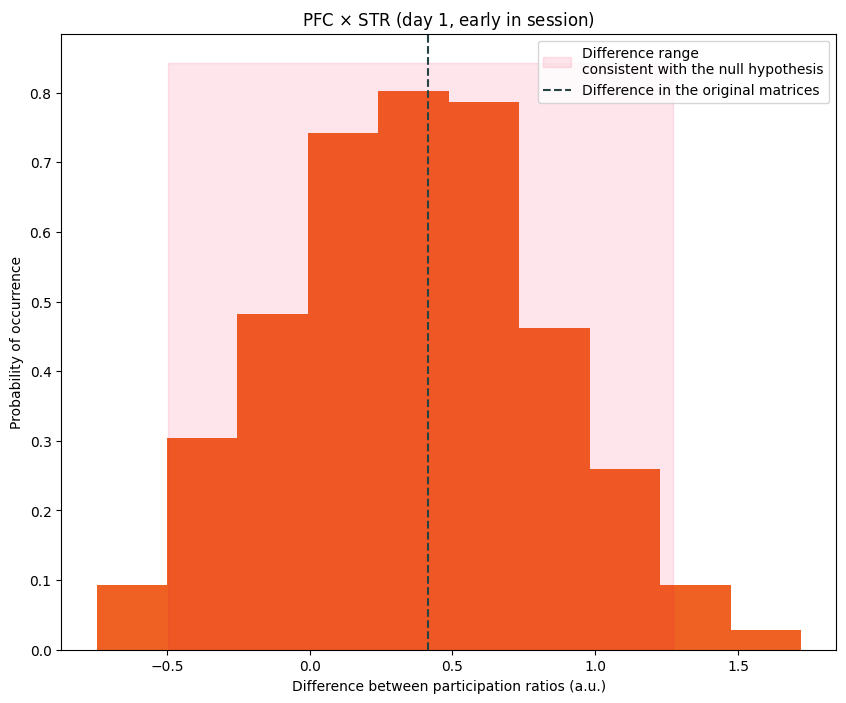

-0.6579880647631224 0.6714432816484097


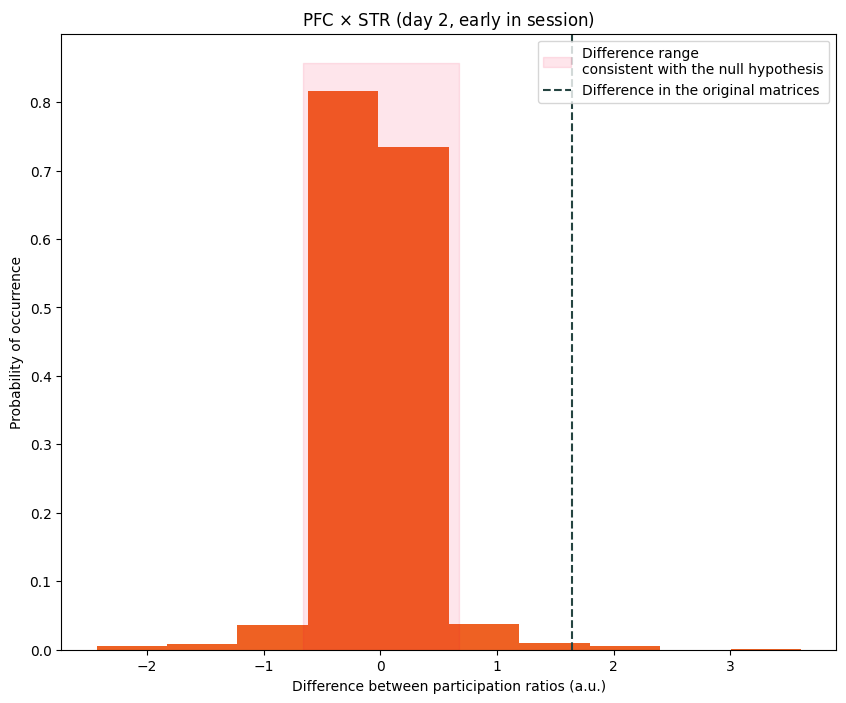

-0.4801144838225691 1.0044549491380852


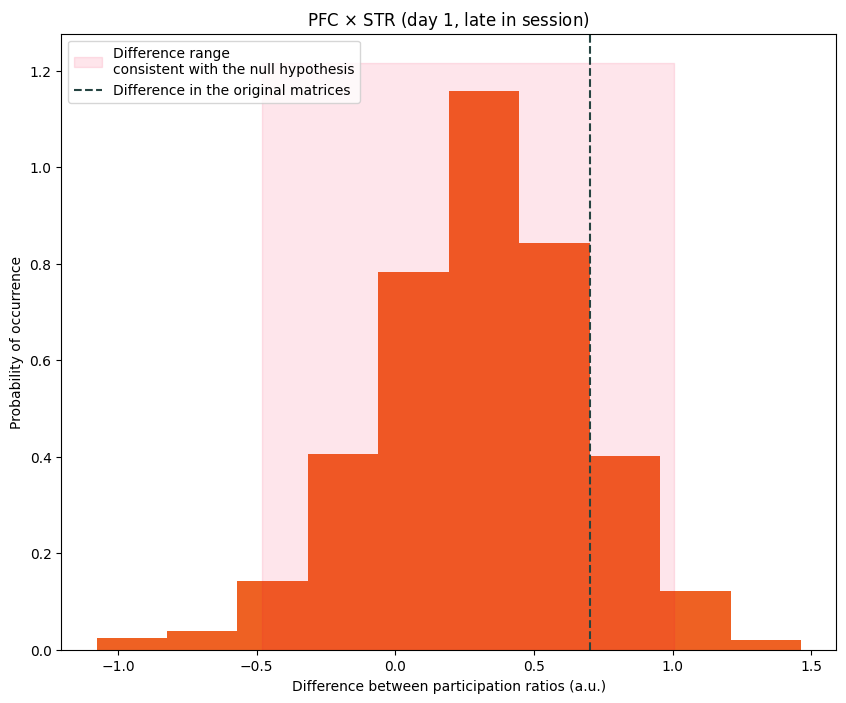

-1.034137864927092 1.0394234239030335


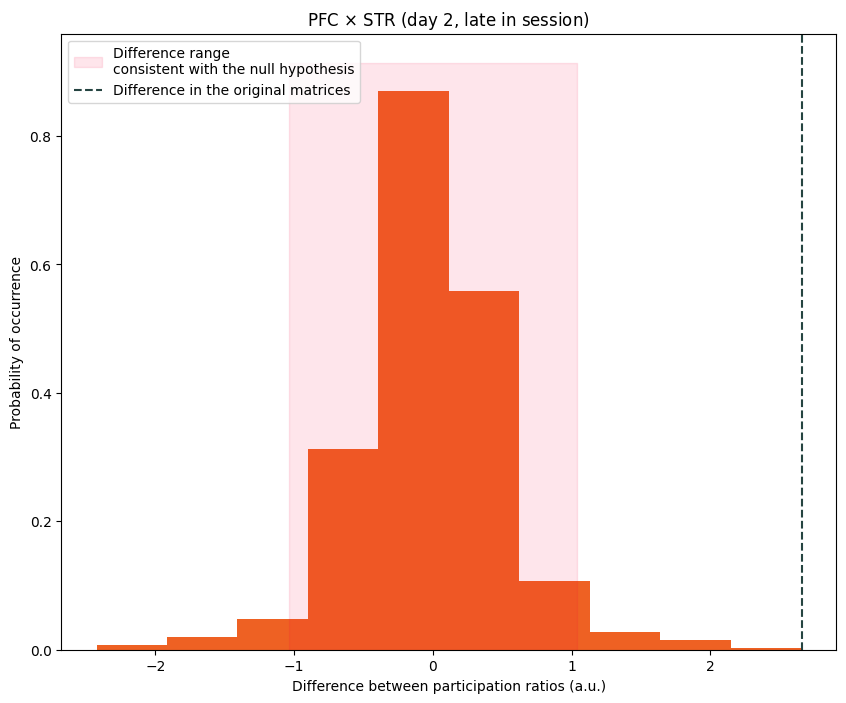

In [ ]:
#PFC vs. STR comparison (in the same day/session period)
pfc_str_d1_early = bootstrapped_pools_participation_ratio_comparison(early_PFC_g2d1,early_STR_g2d1,nruns=1000,two_tailed=True,figlabel=r'PFC $\times$ STR (day 1, early in session)')
pfc_str_d2_early = bootstrapped_pools_participation_ratio_comparison(early_PFC_g2d2,early_STR_g2d2,nruns=1000,two_tailed=True,figlabel=r'PFC $\times$ STR (day 2, early in session)')

pfc_str_d1_late = bootstrapped_pools_participation_ratio_comparison(late_PFC_g2d1,late_STR_g2d1,nruns=1000,two_tailed=True,figlabel=r'PFC $\times$ STR (day 1, late in session)')
pfc_str_d2_late = bootstrapped_pools_participation_ratio_comparison(late_PFC_g2d2,late_STR_g2d2,nruns=1000,two_tailed=True,figlabel=r'PFC $\times$ STR (day 2, late in session)')

-0.6603273973397591 1.1750388340545181


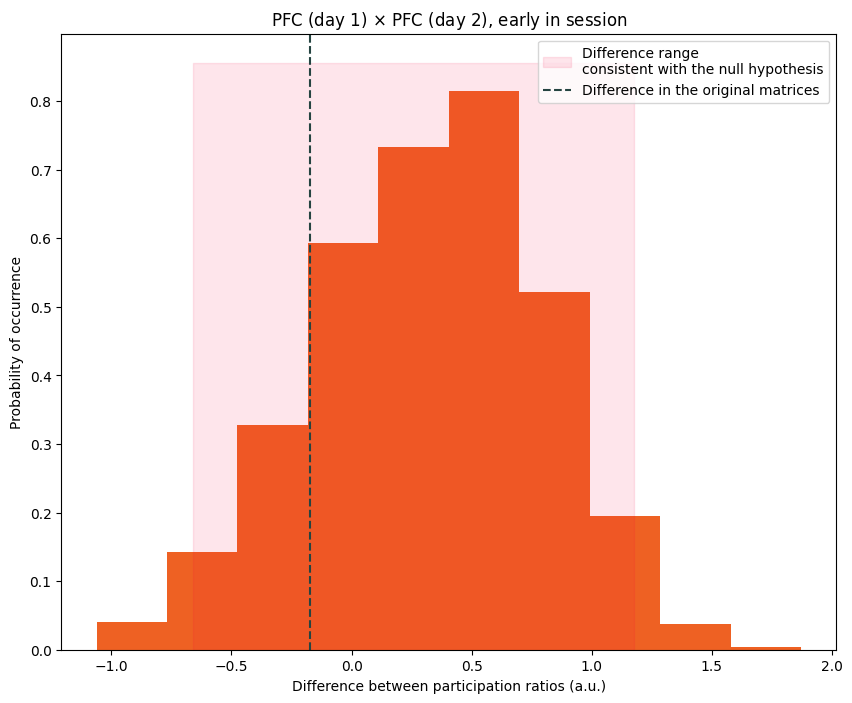

-0.5097028190023036 1.0766105372040708


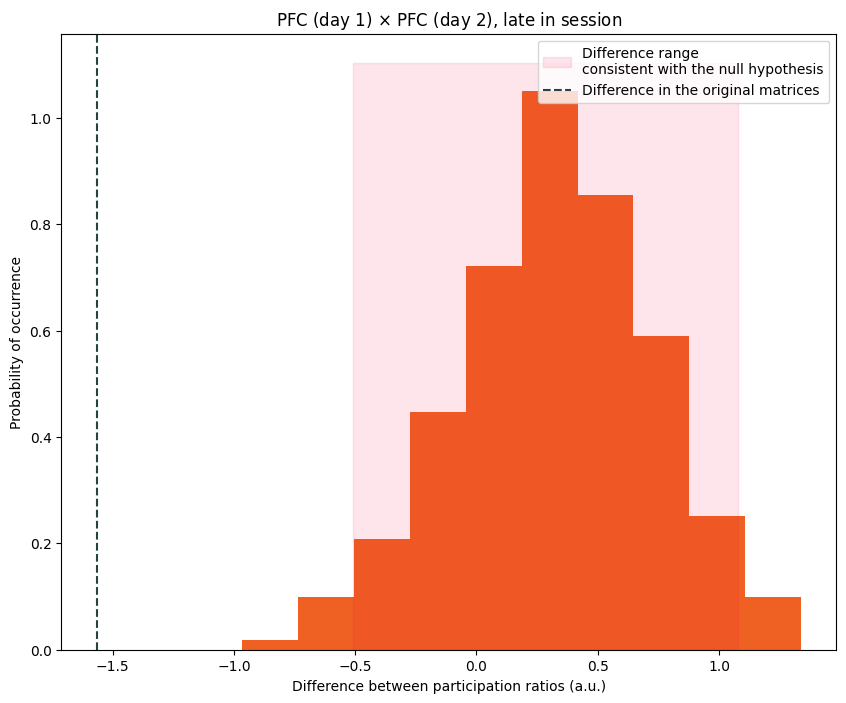

-0.7009018220572957 0.804125160644247


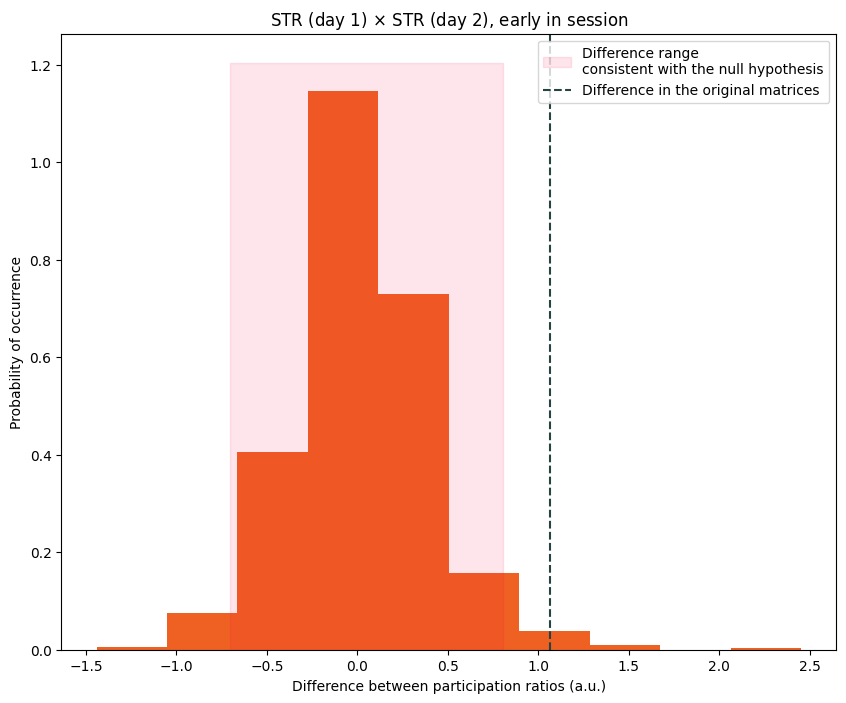

-0.7846740429400647 0.9064897316203038


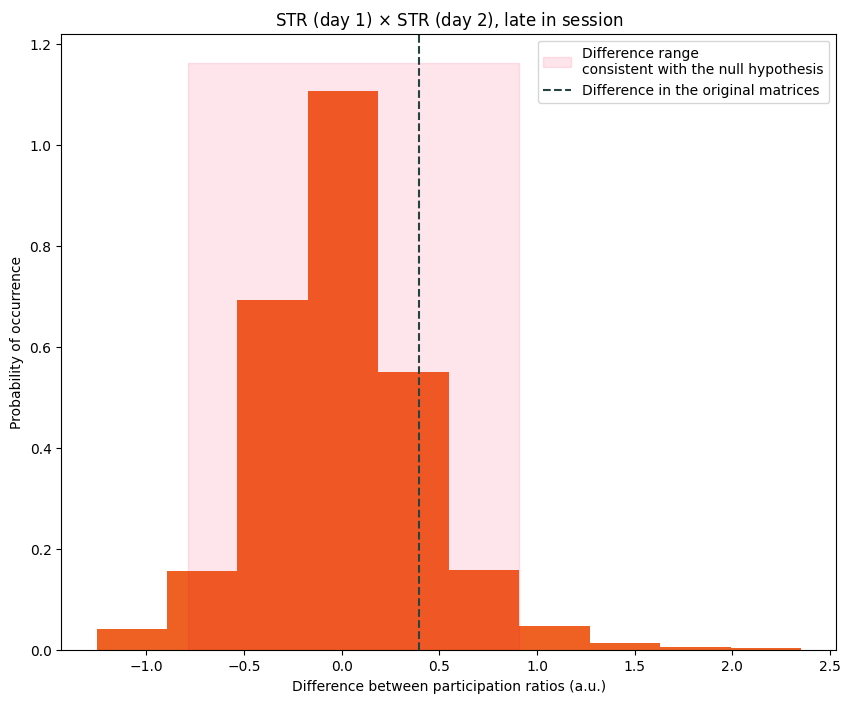

In [ ]:
#Within region comparison between days (in the same session period)
pfc_d1_d2_early = bootstrapped_pools_participation_ratio_comparison(early_PFC_g2d1,early_PFC_g2d2,nruns=1000,two_tailed=True,figlabel=r'PFC (day 1) $\times$ PFC (day 2), early in session')
pfc_d1_d2_early = bootstrapped_pools_participation_ratio_comparison(late_PFC_g2d1,late_PFC_g2d2,nruns=1000,two_tailed=True,figlabel=r'PFC (day 1) $\times$ PFC (day 2), late in session')

str_d1_d2_early = bootstrapped_pools_participation_ratio_comparison(early_STR_g2d1,early_STR_g2d2,nruns=1000,two_tailed=True,figlabel=r'STR (day 1) $\times$ STR (day 2), early in session')
str_d1_d2_late = bootstrapped_pools_participation_ratio_comparison(late_STR_g2d1,late_STR_g2d2,nruns=1000,two_tailed=True,figlabel=r'STR (day 1) $\times$ STR (day 2), late in session')

# PCA

Text(0.5, 0, 'Time (s)')

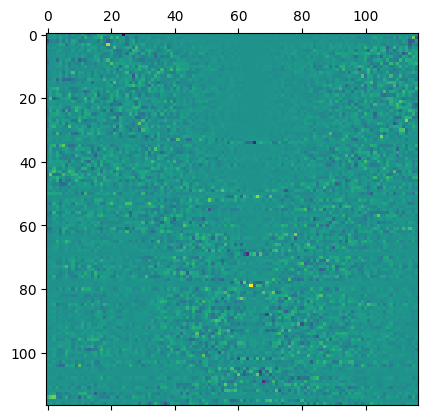

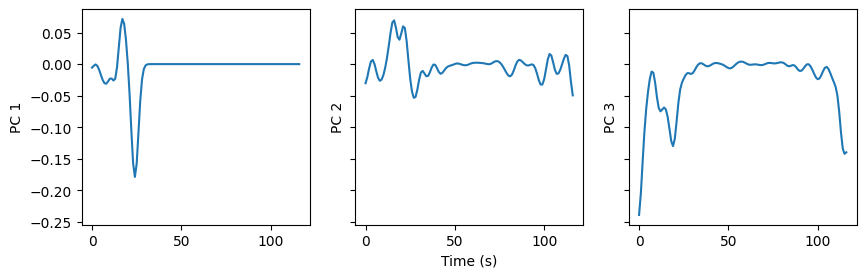

In [ ]:
spike_activity_matrix = early_PFC_g2d1
#spike_activity_matrix = early_PFC_g2d2

#Estimate the covariance
cov = np.cov(spike_activity_matrix)

(L, P) = np.linalg.eigh(cov) #(eigenvalues, eigenvectors) of the covariance matrix yield the directions of most variance (e.g. firing patterns encompassing multiple neurons)

idx = L.argsort()[::-1]
L = L[idx]
P = P[:,idx]

plt.matshow(P)

from scipy.ndimage import gaussian_filter1d

fig, axes = plt.subplots(1, 3, figsize=[10, 2.8], sharey='row')
for comp in range(3):
    ax = axes[comp]
    ax.plot(gaussian_filter1d(P[comp,:],sigma=2))
    ax.set_ylabel('PC {}'.format(comp+1))

axes[1].set_xlabel('Time (s)')

In [ ]:
def plotPCAsComponentsIn2D(Pvec,figsize=(3,3)):
    fig, ax = plt.subplots(2,2,figsize=figsize,sharey='row',sharex='col')

    for P in Pvec:
        ax[0][0].plot(P[:,0],P[:,1])
        ax[0][1].plot(P[:,2],P[:,1])
        ax[1][0].plot(P[:,0],P[:,2])

    ax[0][0].set_xlabel('pc1')
    ax[0][0].set_ylabel('pc2')

    ax[0][1].set_xlabel('pc3')
    ax[0][1].set_ylabel('pc2')

    ax[1][0].set_xlabel('pc1')
    ax[1][0].set_ylabel('pc3')
    return(ax)

Text(0, 0.5, 'pc2')

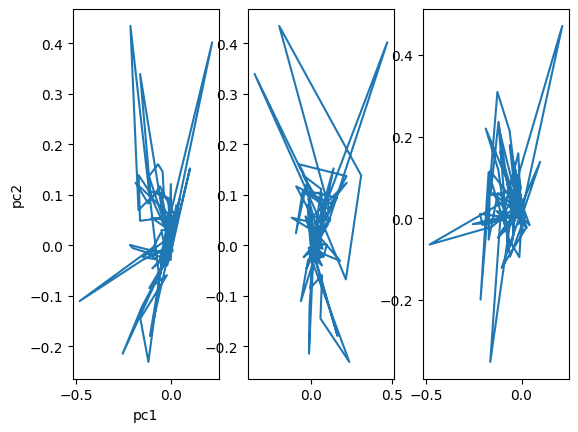

In [ ]:
fig, ax = plt.subplots(1,3)

ax[0].plot(P[:,0],P[:,1])
ax[1].plot(P[:,2],P[:,1])
ax[2].plot(P[:,0],P[:,2])

ax[0].set_xlabel('pc1')
ax[0].set_ylabel('pc2')

#ax[0][1].set_xlabel('pc3')
#ax[0][1].set_ylabel('pc2')

#ax[1][0].set_xlabel('pc1')
#ax[1][0].set_ylabel('pc3')

Text(0, 0.5, 'PC2')

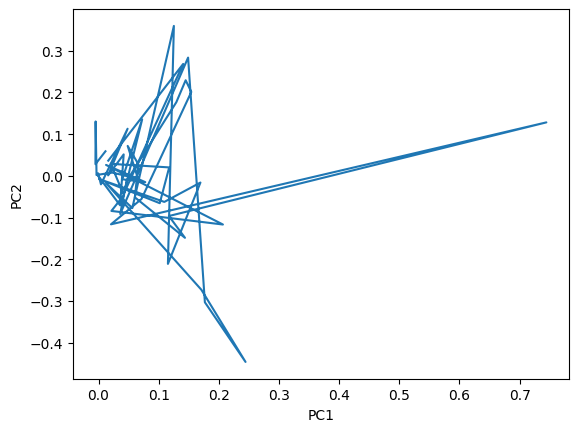

In [ ]:
plt.plot(P[:,0],P[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')

Text(0, 0.5, 'PC3')

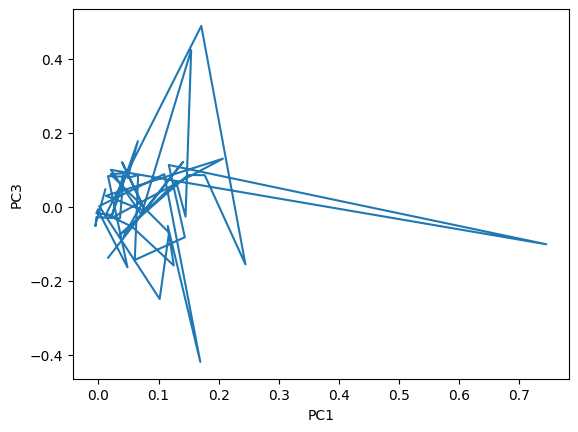

In [ ]:
plt.plot(P[:,0],P[:,2])
plt.xlabel('PC1')
plt.ylabel('PC3')

In [ ]:
plt.plot(P[:,0],P[:,2])
plt.xlabel('PC1')
plt.ylabel('PC3')

IndexError: ignored

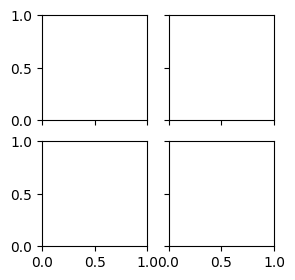

In [ ]:
ax = plotPCAsComponentsIn2D(P)

In [ ]:
n_components = 15
Xa_p = P

fig, axes = plt.subplots(1, 3, figsize=[10, 2.8], sharey='row')
for comp in range(3):
    ax = axes[comp]
    for kk, type in enumerate(trial_types):
        x = Xa_p[comp, kk * trial_size :(kk+1) * trial_size]
        x = gaussian_filter1d(x, sigma=3)
        ax.plot(time, x, c=pal[kk])
    #add_stim_to_plot(ax)
    #ax.set_ylabel('PC {}'.format(comp+1))
add_orientation_legend(axes[2])
axes[1].set_xlabel('Time (s)')
sns.despine(fig=fig, right=True, top=True)
plt.tight_layout(rect=[0, 0, 0.9, 1])

In [ ]:
#original_diff (0),diffs (1),upper (2),lower (3),significant (4),abs (5)
pfc_d1_d2_early[0],pfc_d1_d2_early[2],pfc_d1_d2_early[3],pfc_d1_d2_early[4]

(-1.5666285520600671, 1.0562848373704623, -0.5130920868404659, True)

In [ ]:
str_d1_d2_early

In [ ]:
print(participation_ratio(early_PFC_g2d1),participation_ratio(early_STR_g2d1))

3.052926741951719 2.6401809058607575


In [ ]:
np.mean(vars[-1])

3.0869738374341127

In [ ]:
vars

In [ ]:
(1-alpha)/2

0.025000000000000022

In [ ]:
np.shape(new_matrix)[0]

172

In [ ]:
print(np.random.choice(np.shape(new_matrix)[0],min([np.shape(early_PFC_g2d1)[0],np.shape(early_STR_g2d1)[0]]),replace=True))

[171  11 158  97  99  48 122  29  19  44 151   2  69  54  87  82 119 153
  91 161  99  74 149 138  39  99  19  81 128  68  17  40 138 130  37 100
  41  66 169 133  74  42 111  51 130 160 169 114  93  23   0  26  80  52
  78]


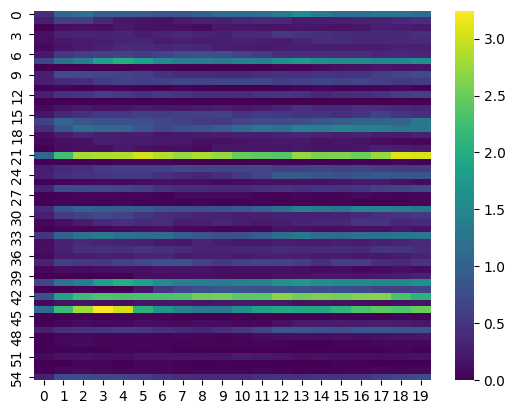

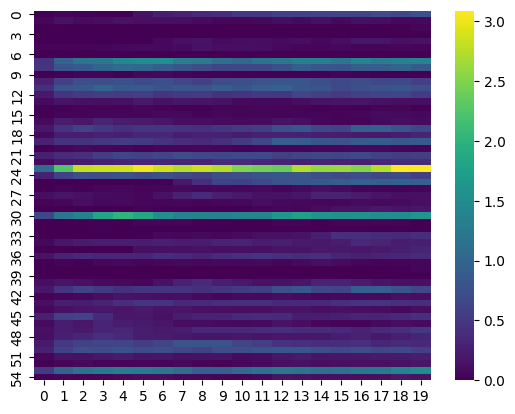

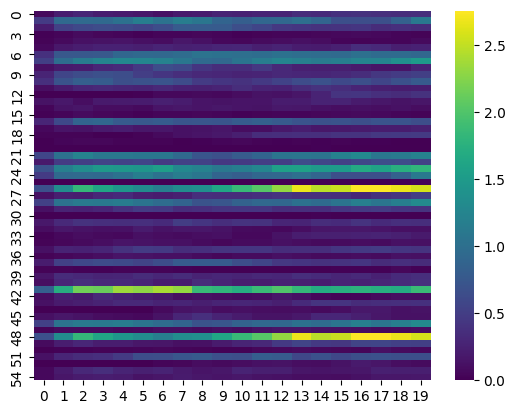

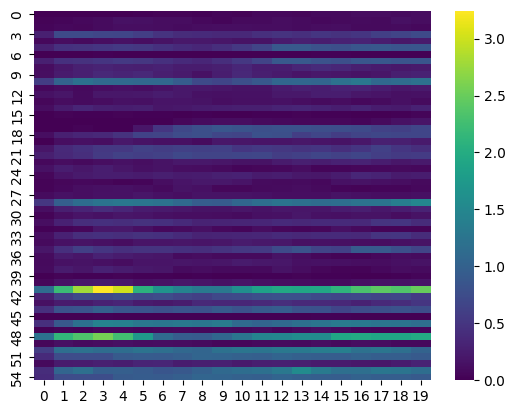

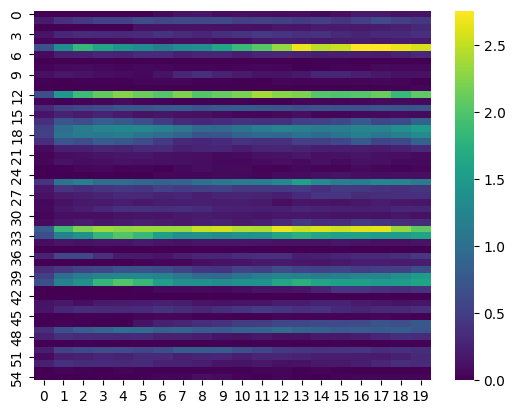

In [ ]:
for _ in range(5):
  sampled_neurons = np.random.choice(np.shape(new_matrix)[0],min([np.shape(early_PFC_g2d1)[0],np.shape(early_STR_g2d1)[0]]),replace=True)

  sns.heatmap(new_matrix[sampled_neurons,:],cmap='viridis')
  plt.show()

In [ ]:
diffs = []
for _ in range(10_000):
  sample1 = np.random.choice(np.shape(new_matrix)[0],min([np.shape(early_PFC_g2d1)[0],np.shape(early_STR_g2d1)[0]]),replace=True)
  sample2 = np.random.choice(np.shape(new_matrix)[0],min([np.shape(early_PFC_g2d1)[0],np.shape(early_STR_g2d1)[0]]),replace=True)

  diffs.append(participation_ratio(new_matrix[sample1,:]) - participation_ratio(new_matrix[sample2,:]))

  #sns.heatmap(new_matrix[sampled_neurons,:],cmap='viridis')
  #plt.show()

In [ ]:
original_diff = participation_ratio(early_PFC_g2d1) - participation_ratio(early_STR_g2d1)

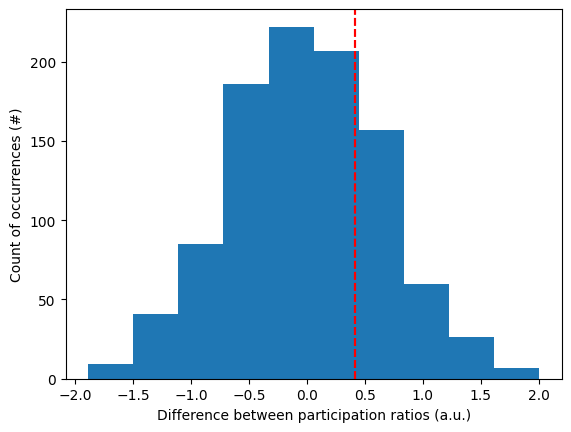

In [ ]:
plt.hist(diffs)
plt.xlabel('Difference between participation ratios (a.u.)')
plt.ylabel('Count of occurrences (#)')
plt.axvline(original_diff, color='red', linestyle='--',label='Difference in the original matrices')
plt.axvline(original_diff, color='red', linestyle='--',label='Difference in the original matrices')

In [ ]:
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  np.percentile(diffs, p)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  np.percentile(diffs, p)

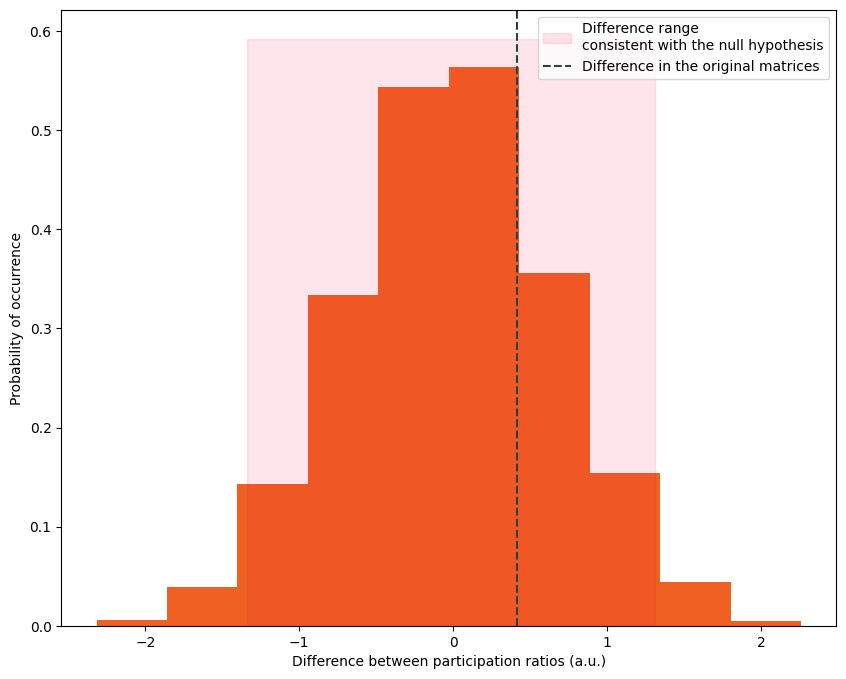

In [ ]:
plt.figure(figsize=(10,8))
counts,bins,patches = plt.hist(diffs,color='#EE6123',density=True)#,histtype='step')
plt.xlabel('Difference between participation ratios (a.u.)')
plt.ylabel('Probability of occurrence')
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], lower, upper, color='#FA003F', alpha=0.1, label='Difference range\nconsistent with the null hypothesis')
plt.axvline(original_diff, color='#254441', linestyle='--',label='Difference in the original matrices')

plt.legend()
#plt.axvline([lower,upper], color='orange', linestyle='--',label=r'95\% range')
#plt.axvline(lower, color='orange', linestyle='--',label=r'95\% range')

In [ ]:
print(f"\n{alpha*100} confidence interval {lower} and {upper}")


95.0 confidence interval -1.332650452338973 and 1.2924594682405364


In [ ]:
least_amount_of_trials = min([animal.trial.nunique() for animal in separated_rats])
trials_in_thirds = int(least_amount_of_trials/3)
print(least_amount_of_trials,trials_in_thirds)

147 49


In [ ]:
#the number of unique neurons is less than the total number of neurons because some of different rat's neurons have the same numeric value corresponding to them:
neurons_count = 0

rats_dfs = []
for rat in separated_rats:
  #pruned_df = least_amount_spikes(rat,10)

  print('rat',rat.rat.unique()[0],' has ', rat.neuron.nunique(),' different neurons')
  neurons_count+= rat.neuron.nunique()

  rats_dfs.append(rat)

print('number of "unique" neurons according to pandas: ',data_subset.neuron.nunique(),' \n actual count of unique neurons: ',neurons_count)

rat 7  has  17  different neurons
rat 8  has  35  different neurons
rat 9  has  10  different neurons
rat 10  has  9  different neurons
rat 3  has  4  different neurons
rat 4  has  33  different neurons
rat 5  has  5  different neurons
rat 6  has  4  different neurons
number of "unique" neurons according to pandas:  52  
 actual count of unique neurons:  117


In [ ]:
#make a recipient for all of a region's neurons
num_timebins = 15 #after convolving and taking the mean, this will be the number of bins we will reduce our series to

first_trials_activty_matrix = np.empty([neurons_count,num_timebins])
last_trials_activty_matrix = np.empty([neurons_count,num_timebins])

In [ ]:
session_slice = trials_in_thirds #number of trials we avereage over

neuron_count = 0

for current_rat_df in rats_dfs:
  current_num_neurons = current_rat_df.neuron.nunique()

  #bin in time
  binned = time_binning(current_rat_df,timespan = [-0.5,1.5])
  #convolve and trim the matrix up to the maximum number of trials in the rat with least trials
  convolved = convolve_raster(binned)[0:least_amount_of_trials,:,:]
  #print(np.shape(convolved))

  norm_first_mean_convolved = np.expand_dims(np.mean(convolved[0:session_slice,:,:],axis=0),axis=0)
  norm_last_mean_convolved = np.expand_dims(np.mean(convolved[-session_slice:,:,:],axis=0),axis=0)


  for i in range(15):
    #print(np.mean(norm_first_40[0,:,i*100:(i+1)*100],axis=1))
    first_trials_activty_matrix[neuron_count:neuron_count+current_num_neurons,i] = np.mean(norm_first_mean_convolved[0,:,i*100:(i+1)*100],axis=1)
    last_trials_activty_matrix[neuron_count:neuron_count+current_num_neurons,i] = np.mean(norm_last_mean_convolved[0,:,i*100:(i+1)*100],axis=1)

  neuron_count+= current_num_neurons

(604, 17, 2000)
(407, 35, 2000)
(362, 10, 2000)
(907, 9, 2000)
(262, 4, 2000)
(182, 33, 2000)
(147, 5, 2000)
(385, 4, 2000)


Text(83.22222222222221, 0.5, 'Neuron (#)')

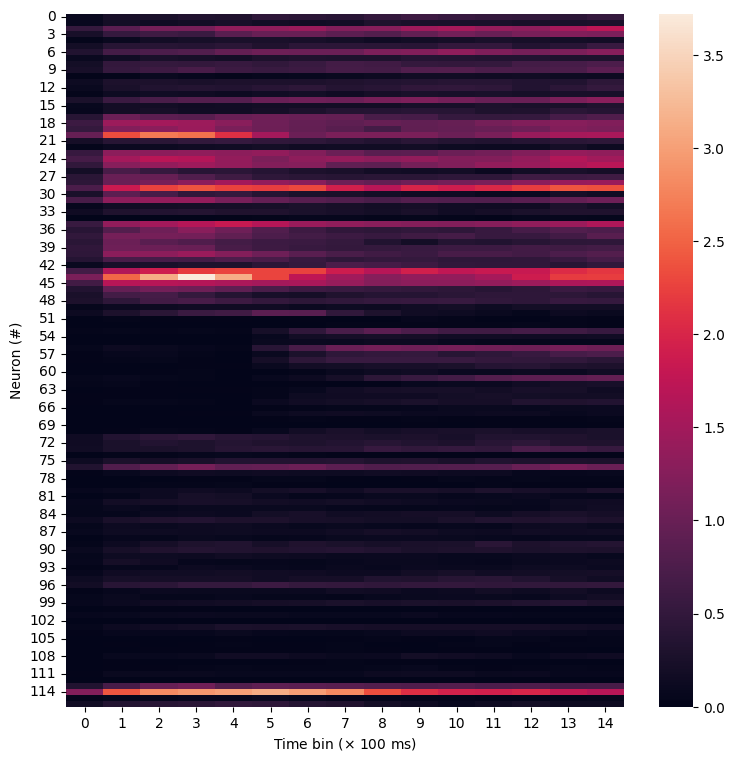

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

num_neurons,timebins = np.shape(first_trials_activty_matrix)

rates = sns.heatmap(last_trials_activty_matrix[:,:])
ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(r'Time bin ($\times$ 100 ms)')
ax.set_ylabel('Neuron (#)')

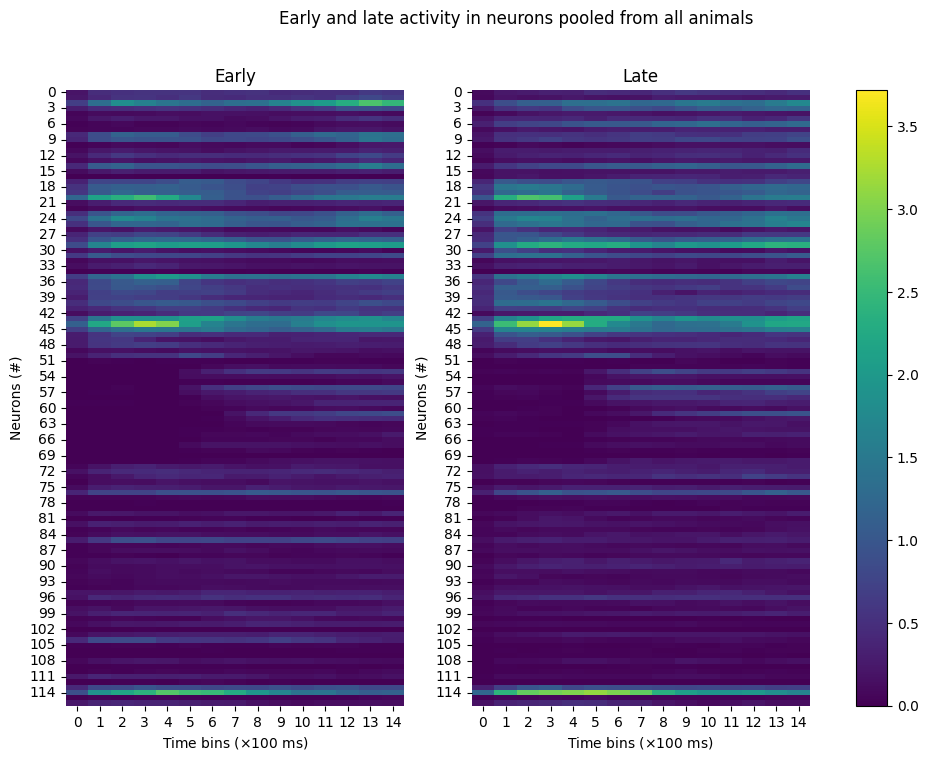

In [ ]:
import matplotlib
from matplotlib.colors import Normalize
import matplotlib.cm as cm

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,8))

cmap = matplotlib.colormaps['viridis']
normalizer=Normalize(0,max(first_trials_activty_matrix.max(),last_trials_activty_matrix.max()))
im = cm.ScalarMappable(norm=normalizer)

sns.heatmap(first_trials_activty_matrix[:,:],cmap='viridis',norm=normalizer,ax=axes[0],cbar=False)
sns.heatmap(last_trials_activty_matrix[:,:],cmap='viridis',norm=normalizer,ax=axes[1],cbar=False)

fig.colorbar(im, ax=axes.ravel().tolist())

fig.suptitle('Early and late activity in neurons pooled from all animals')
axes[0].set_title('Early')
axes[1].set_title('Late')

axes[0].set_ylabel('Neurons (#)')
axes[1].set_ylabel('Neurons (#)')

axes[0].set_xlabel(r'Time bins ($\times 100$ ms)')
axes[1].set_xlabel(r'Time bins ($\times 100$ ms)')

plt.show()

In [ ]:
max(first_trials_activty_matrix.max(),last_trials_activty_matrix.max())

3.7212702330941068

In [ ]:
pr_early = participation_ratio(first_trials_activty_matrix)
pr_late = participation_ratio(last_trials_activty_matrix)

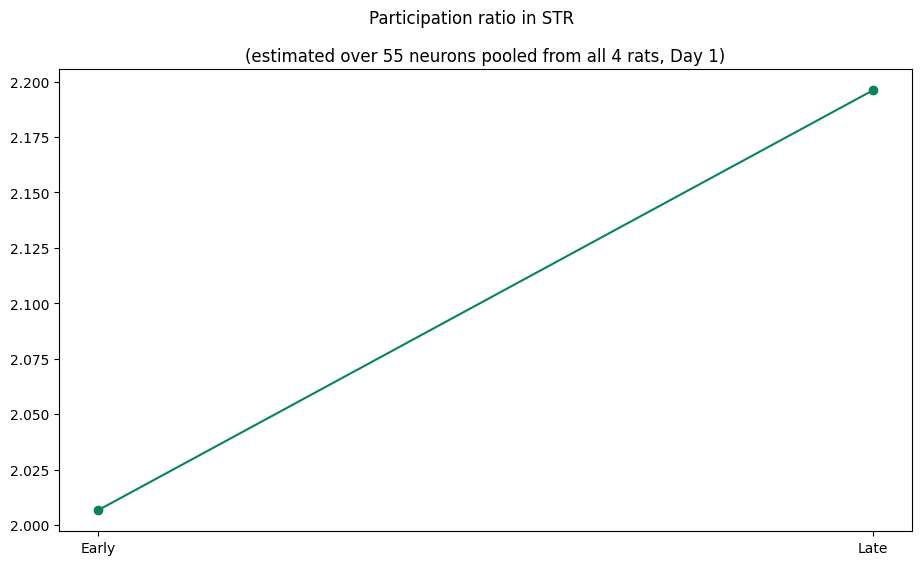

In [ ]:
region = 'STR'
day_id = 1

pr_early = participation_ratio(first_trials_activty_matrix)
pr_late = participation_ratio(last_trials_activty_matrix)

plt.figure(figsize=(11,6))
plt.plot(['Early','Late'],[pr_early,pr_late],marker='o',color='#09835A')
plt.suptitle(f'Participation ratio in {region}')
plt.title(f'(estimated over {neurons_count} neurons pooled from all {len(separated_rats)} rats, Day {day_id})');

# To do:
*    pooling and participation ratio (with jackknife) for each session
*    pooled neurons' heatmap plot
*    average PR in awake/asleep periods prior to training and after it

In [14]:
def p_value_from_t_statistic(t_statistic,degrees_of_freedom,two_tailed = True):
  '''
  Estimate the p-value from a t-score (statistic from either a one-sided or two-sided Student's t-test) using the survival function for the t distribution

  INPUT:
  - t_statistic [float]: t-statistic estimated from the Student's t-test comparing two samples' means
  - degrees_of_freedom [int]: number of observations (i.e. degrees of freedom) in the samples
  - two_tailed [bool]: whether the test yielding the t-score was one- (False) or two-sided (True). (default: True)

  OUTPUT:
  - p_value [float]: the probability of finding a t-score as extreme as the one given, under the null hypothesis
  '''
  if not two_tailed:
    return scipy.stats.t.sf(t_statistic,df=degrees_of_freedom)
  else:
    return scipy.stats.t.sf(t_statistic,df=degrees_of_freedom)*2 #a two-tailed test has half the power, hence a twofold increase in the area comprising the critical region

In [15]:
def pooled_neurons_participation_ratio_comparison(early_pooled_activity,late_pooled_activity,jackknife_corretion=True):
  #jackknife procedure
  jack_resamples_early = []
  jack_resamples_late = []

  N = np.shape(first_trials_activty_matrix)[0] #number of samples

  for line in range(N):
    def resample(matrix,line):
      return np.delete(matrix,(line),axis=0)

    jack_resamples_early.append(participation_ratio(resample(first_trials_activty_matrix,line)))
    jack_resamples_late.append(participation_ratio(resample(last_trials_activty_matrix,line)))

In [ ]:
#jackknife procedure
jack_resamples_early = []
jack_resamples_late = []

N = np.shape(first_trials_activty_matrix)[0] #number of samples

for line in range(N):
  def resample(matrix,line):
    return np.delete(matrix,(line),axis=0)

  jack_resamples_early.append(participation_ratio(resample(first_trials_activty_matrix,line)))
  jack_resamples_late.append(participation_ratio(resample(last_trials_activty_matrix,line)))

NameError: ignored

In [ ]:
t_statistic,p_value=scipy.stats.ttest_rel(jack_resamples_early,jack_resamples_late)
t_statistic

205.19301520490237

In [ ]:
t_statistic/(N-1)
p_value_from_t = scipy.stats.t.sf(abs(t_statistic/(N-1)),df=(N-1))

In [ ]:
p_value_from_t

0.07953794978318615

In [ ]:
from scipy.stats import t

#sf(x, df, loc=0, scale=1)
t.sf()

2.1269877179142037e-150


In [ ]:
t_statistic/(N-1)

1.7689053034905375

In [ ]:
(N-1)

116

In [ ]:
print(statistic_on_data,estimate)

2.8861131684311876 3.140674809906145


In [ ]:
jackknife_samples

TypeError: ignored

Text(83.22222222222221, 0.5, 'Neuron (#)')

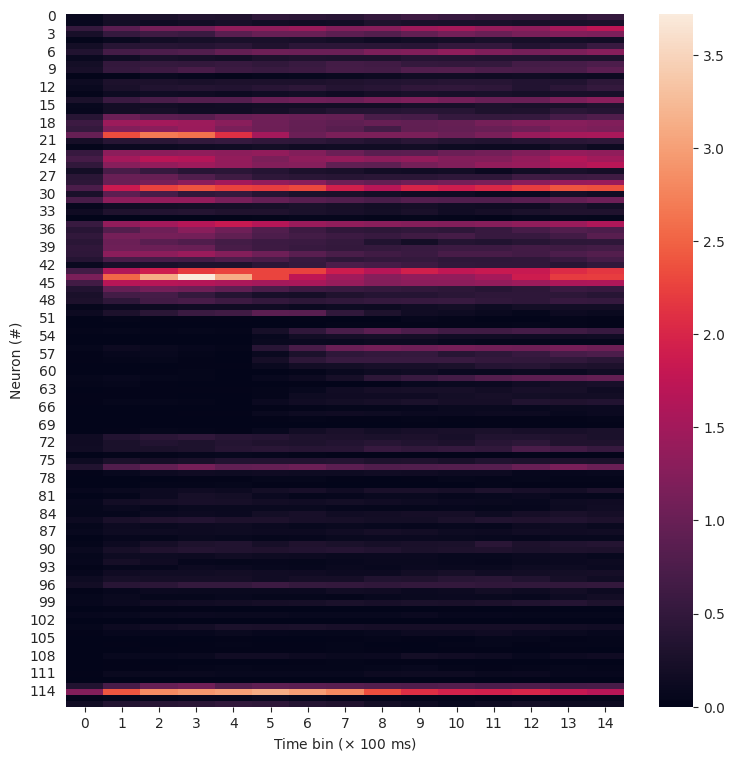

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

num_neurons,timebins = np.shape(first_trials_activty_matrix)

rates = sns.heatmap(last_trials_activty_matrix[:,:])
ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(r'Time bin ($\times$ 100 ms)')
ax.set_ylabel('Neuron (#)')

Text(0, 0.5, 'Neuron (#)')

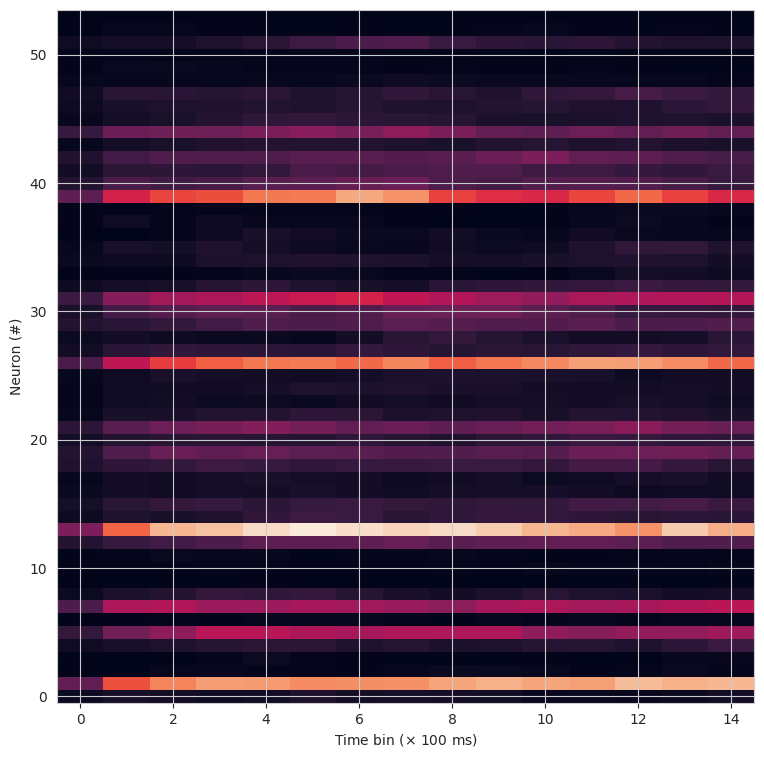

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

num_neurons,timebins = np.shape(first_trials_activty_matrix)

rates = ax.matshow(first_trials_activty_matrix[:,:],aspect="auto",origin='lower')
ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(r'Time bin ($\times$ 100 ms)')
ax.set_ylabel('Neuron (#)')

# Average participation ratio in random freely moving segments

In [16]:
def time_binning_stages(spikes_df,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('stage_id').copy()

  num_stages = dataset.stage_id.nunique()
  num_neurons = dataset.neuron.nunique()

  duration = timespan[1] - timespan[0]
  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_stages,num_neurons,num_timebins])

  for stage_id,stage in enumerate(dataset.stage_id.unique()):
    stage_beginning = dataset.loc[dataset['stage_id'] == stage].timestamp.min()
    for neuron_id,neuron in enumerate(dataset.neuron.unique()):
      spike_train = dataset.loc[(dataset['stage_id'] == stage) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.timestamp - stage_beginning,bins = np.linspace(timespan[0],timespan[1],num_timebins+1,endpoint=True))
      binned_spikes_matrix[stage_id,neuron_id,:] = discretized_spike_train

  return binned_spikes_matrix

In [17]:
def random_stage_clipping(single_rat_df,clipped_duration=2):

  segment_length = 0

  while segment_length == 0:
    #guaranteed to run at least once, but run until we find a segment with at least 2 s in duration with spikes recorded within its time boundaries
    random_stage = np.random.choice(single_rat_df.stage_id.unique())

    stage_session = single_rat_df.query(f'stage_id == {random_stage}')

    import random
    window_left = random.uniform(stage_session.timestamp.min(),stage_session.timestamp.max()-clipped_duration) #left end of the time window to be selected

    session_segment = stage_session.query(f'timestamp > {window_left} and timestamp < {window_left + clipped_duration}')
    segment_length = len(session_segment)

  lowres_segment_spikes = lower_firing_rate_resolution(convolve_raster(time_binning_stages(session_segment,[0,clipped_duration]))[0,:,:])

  return lowres_segment_spikes

In [20]:
def loc_and_separate(data,day_id,region_id,trial_duration_criteria,spike_time_criteria,check_num_neurons=False):
  data_subset = data.loc[(data['day']== day_id) & (data['region']== region_id)
                    & (data['duration']>=trial_duration_criteria[0]) & (data['duration']<=trial_duration_criteria[1])
                    & (data['time']>=spike_time_criteria[0]) & (data['time']<=spike_time_criteria[1])]
  return separate_rats(data_subset,check_num_neurons)

PFC_d1 = loc_and_separate(data,day_id = 1, region_id = 'PFC', trial_duration_criteria=[1.5,3.5], spike_time_criteria = [-0.5,1.5])
PFC_d2 = loc_and_separate(data,day_id = 2, region_id = 'PFC', trial_duration_criteria=[1.5,3.5], spike_time_criteria = [-0.5,1.5])

STR_d1 = loc_and_separate(data,day_id = 1, region_id = 'STR', trial_duration_criteria=[1.5,3.5], spike_time_criteria = [-0.5,1.5])
STR_d2 = loc_and_separate(data,day_id = 2, region_id = 'STR', trial_duration_criteria=[1.5,3.5], spike_time_criteria = [-0.5,1.5])

In [21]:
def participation_ratio_distribution(separated_rats_dfs,num_reps=1000):
  pr_dist = []

  for _ in range(num_reps):
    neuron_pool = np.vstack([matrix for matrix in map(random_stage_clipping,separated_rats_dfs)])
    pr_dist.append(participation_ratio(neuron_pool))

  return pr_dist

In [22]:
num_reps = 1000

pr_dist_PFC_d1 = participation_ratio_distribution(separate_rats(all_scored_states.query(f'day == 1 and stage == "WAKEstate" and region == "PFC"'),check_num_neurons=False),num_reps)
pr_dist_PFC_d2 = participation_ratio_distribution(separate_rats(all_scored_states.query(f'day == 2 and stage == "WAKEstate" and region == "PFC"'),check_num_neurons=False),num_reps)
pr_dist_STR_d1 = participation_ratio_distribution(separate_rats(all_scored_states.query(f'day == 1 and stage == "WAKEstate" and region == "STR"'),check_num_neurons=False),num_reps)
pr_dist_STR_d2 = participation_ratio_distribution(separate_rats(all_scored_states.query(f'day == 2 and stage == "WAKEstate" and region == "STR"'),check_num_neurons=False),num_reps)

A saída de streaming foi truncada nas últimas 5000 linhas.
(1, 9, 2000)
(1, 14, 2000)
(1, 14, 2000)
(1, 1, 2000)
(1, 9, 2000)
(1, 14, 2000)
(1, 13, 2000)
(1, 1, 2000)
(1, 7, 2000)
(1, 14, 2000)
(1, 12, 2000)
(1, 1, 2000)
(1, 7, 2000)
(1, 14, 2000)
(1, 14, 2000)
(1, 1, 2000)
(1, 10, 2000)
(1, 12, 2000)
(1, 11, 2000)
(1, 1, 2000)
(1, 7, 2000)
(1, 12, 2000)
(1, 11, 2000)
(1, 1, 2000)
(1, 9, 2000)
(1, 14, 2000)
(1, 12, 2000)
(1, 1, 2000)
(1, 9, 2000)
(1, 13, 2000)
(1, 13, 2000)
(1, 1, 2000)
(1, 6, 2000)
(1, 15, 2000)
(1, 14, 2000)
(1, 1, 2000)
(1, 10, 2000)
(1, 15, 2000)
(1, 14, 2000)
(1, 1, 2000)
(1, 6, 2000)
(1, 13, 2000)
(1, 9, 2000)
(1, 1, 2000)
(1, 7, 2000)
(1, 14, 2000)
(1, 12, 2000)
(1, 1, 2000)
(1, 8, 2000)
(1, 14, 2000)
(1, 12, 2000)
(1, 1, 2000)
(1, 7, 2000)
(1, 14, 2000)
(1, 13, 2000)
(1, 1, 2000)
(1, 10, 2000)
(1, 15, 2000)
(1, 14, 2000)
(1, 1, 2000)
(1, 8, 2000)
(1, 14, 2000)
(1, 12, 2000)
(1, 1, 2000)
(1, 7, 2000)
(1, 14, 2000)
(1, 14, 2000)
(1, 1, 2000)
(1, 9, 2000)
(1, 14, 

Text(0, 0.5, 'Counts (#)')

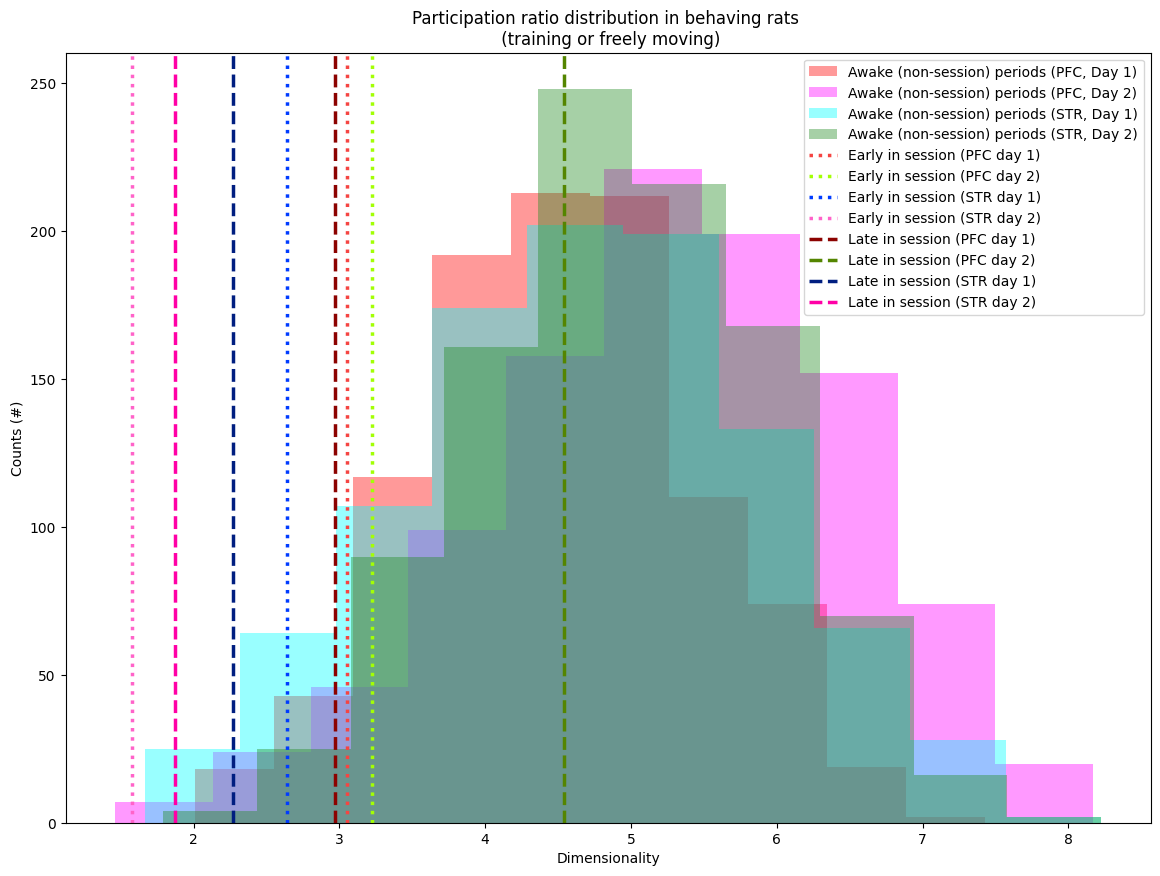

In [59]:
plt.figure(figsize=(14,10))

#PFC, day 1 distribution
plt.hist(pr_dist_PFC_d1,color='red',alpha=0.4,label='Awake (non-session) periods (PFC, Day 1)')
#plt.hist(pr_dist_PFC_d1,histtype='step',color='grey')

#PFC, day 2 distribution
plt.hist(pr_dist_PFC_d2,color='fuchsia',alpha=0.4,label='Awake (non-session) periods (PFC, Day 2)')
#plt.hist(pr_dist_PFC_d2,histtype='step',color='sienna')

#STR, day 1 distribution
plt.hist(pr_dist_STR_d1,color='cyan',alpha=0.4,label='Awake (non-session) periods (STR, Day 1)')
#plt.hist(pr_dist_STR_d1,histtype='step',color='crimson')

#STR, day 1 distribution
plt.hist(pr_dist_STR_d2,color='forestgreen',alpha=0.4,label='Awake (non-session) periods (STR, Day 2)')
#plt.hist(pr_dist_STR_d2,histtype='step',color='royalblue')

plt.axvline(x=participation_ratio(early_PFC_g2d1),label='Early in session (PFC day 1)',linestyle='dotted',color='#f54542',linewidth=2.5)
plt.axvline(x=participation_ratio(early_PFC_g2d2),label='Early in session (PFC day 2)',linestyle='dotted',color='#a3ff05',linewidth=2.5)
plt.axvline(x=participation_ratio(early_STR_g2d1),label='Early in session (STR day 1)',linestyle='dotted',color='#003cff',linewidth=2.5)
plt.axvline(x=participation_ratio(early_STR_g2d2),label='Early in session (STR day 2)',linestyle='dotted',color='#ff63c9',linewidth=2.5)

plt.axvline(x=participation_ratio(late_PFC_g2d1),label='Late in session (PFC day 1)',linestyle='dashed',color='#8c0200',linewidth=2.5)
plt.axvline(x=participation_ratio(late_PFC_g2d2),label='Late in session (PFC day 2)',linestyle='dashed',color='#548500',linewidth=2.5)
plt.axvline(x=participation_ratio(late_STR_g2d1),label='Late in session (STR day 1)',linestyle='dashed',color='#001e80',linewidth=2.5)
plt.axvline(x=participation_ratio(late_STR_g2d2),label='Late in session (STR day 2)',linestyle='dashed',color='#ff00a6',linewidth=2.5)

plt.legend()

plt.title('Participation ratio distribution in behaving rats \n (training or freely moving)')
plt.xlabel('Dimensionality')
plt.ylabel('Counts (#)')

In [48]:
all_dists = np.hstack([np.squeeze(pr_dist_PFC_d1),np.squeeze(pr_dist_PFC_d2),np.squeeze(pr_dist_STR_d1),np.squeeze(pr_dist_STR_d2)])
print(np.std(all_dists),np.mean(all_dists),np.mean(all_dists) - 3*np.std(all_dists))

1.1223405242921816 4.849484622546084 1.4824630496695397


In [56]:
def confidence_interval(distribution,alpha=0.95):
  # confidence intervals
  lower = np.percentile(distribution,((1-alpha)/2)*100) #e.g. at 95% confidence: 0.05/2 * 100 => 2.5%
  upper = np.percentile(distribution,((alpha+(1-alpha)/2))*100) #e.g. at 95% confidence: (0.95 + 0.025) * 100 => 97.5%
  print(lower,upper)
  return lower,upper

In [58]:
confidence_interval(pr_dist_PFC_d1)
print('early:',participation_ratio(early_PFC_g2d1))
print('late:',participation_ratio(late_PFC_g2d1))

confidence_interval(pr_dist_PFC_d2)
print('early:',participation_ratio(early_PFC_g2d2))
print('late:',participation_ratio(late_PFC_g2d2))

confidence_interval(pr_dist_STR_d1)
print('early:',participation_ratio(early_STR_g2d1))
print('late:',participation_ratio(late_STR_g2d1))

confidence_interval(pr_dist_STR_d2)
print('early:',participation_ratio(early_STR_g2d2))
print('late:',participation_ratio(late_STR_g2d2))

2.6407162100263193 6.281264813773728
early: 3.052926741951719
late: 2.9735793138002182
2.7525745027043897 7.42790338966707
early: 3.224055297347996
late: 4.540207865860285
2.3296404097034302 6.963470496243527
early: 2.6401809058607575
late: 2.2731317114850538
3.0141657566641387 6.823576381135674
early: 1.5785265719954569
late: 1.8756285190585291


In [55]:
np.mean(pr_dist_STR_d2)

4.947372989810766

In [ ]:
num_reps = 1000

region = 'PFC'

participation_ratio_distribution_day1 = []
participation_ratio_distribution_day2 = []

rats_dfs_day1 = separate_rats(all_scored_states.query(f'day == 1 and stage == "WAKEstate" and region == "{region}"'),check_num_neurons=False)
rats_dfs_day2 = separate_rats(all_scored_states.query(f'day == 2 and stage == "WAKEstate" and region == "{region}"'),check_num_neurons=False)

for _ in range(num_reps):
  neuron_pool_day1 = np.vstack([matrix for matrix in map(random_stage_clipping,rats_dfs_day1)])
  neuron_pool_day2 = np.vstack([matrix for matrix in map(random_stage_clipping,rats_dfs_day2)])
  participation_ratio_distribution_day1.append(participation_ratio(neuron_pool_day1))
  participation_ratio_distribution_day2.append(participation_ratio(neuron_pool_day2))

A saída de streaming foi truncada nas últimas 5000 linhas.
(1, 4, 2000)
(1, 17, 2000)
(1, 4, 2000)
(1, 4, 2000)
(1, 10, 2000)
(1, 18, 2000)
(1, 4, 2000)
(1, 1, 2000)
(1, 4, 2000)
(1, 20, 2000)
(1, 3, 2000)
(1, 4, 2000)
(1, 9, 2000)
(1, 20, 2000)
(1, 5, 2000)
(1, 2, 2000)
(1, 4, 2000)
(1, 20, 2000)
(1, 2, 2000)
(1, 4, 2000)
(1, 9, 2000)
(1, 21, 2000)
(1, 5, 2000)
(1, 3, 2000)
(1, 3, 2000)
(1, 17, 2000)
(1, 5, 2000)
(1, 4, 2000)
(1, 9, 2000)
(1, 22, 2000)
(1, 2, 2000)
(1, 3, 2000)
(1, 4, 2000)
(1, 16, 2000)
(1, 3, 2000)
(1, 4, 2000)
(1, 9, 2000)
(1, 22, 2000)
(1, 3, 2000)
(1, 2, 2000)
(1, 4, 2000)
(1, 15, 2000)
(1, 2, 2000)
(1, 4, 2000)
(1, 6, 2000)
(1, 22, 2000)
(1, 3, 2000)
(1, 2, 2000)
(1, 4, 2000)
(1, 18, 2000)
(1, 3, 2000)
(1, 4, 2000)
(1, 8, 2000)
(1, 23, 2000)
(1, 5, 2000)
(1, 2, 2000)
(1, 4, 2000)
(1, 17, 2000)
(1, 4, 2000)
(1, 4, 2000)
(1, 6, 2000)
(1, 23, 2000)
(1, 3, 2000)
(1, 1, 2000)
(1, 4, 2000)
(1, 18, 2000)
(1, 2, 2000)
(1, 4, 2000)
(1, 10, 2000)
(1, 25, 2000)
(1, 4, 2000

Text(0, 0.5, 'Counts (#)')

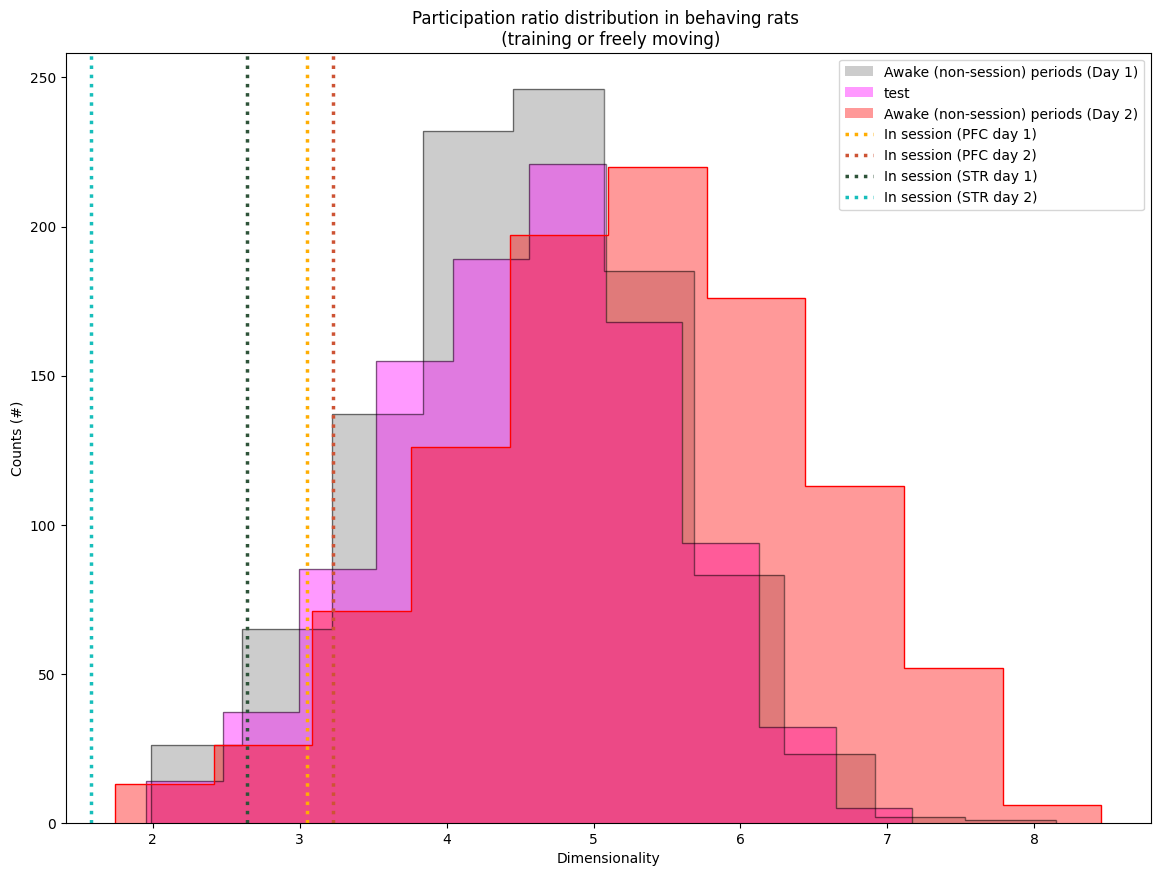

In [ ]:
plt.figure(figsize=(14,10))
plt.hist(participation_ratio_distribution_day1,color='grey',alpha=0.4,label='Awake (non-session) periods (Day 1)')
plt.hist(participation_ratio_distribution_day1,histtype='step',color='black',alpha=0.5)

plt.hist(test_dist,color='fuchsia',alpha=0.4,label='test')
plt.hist(test_dist,histtype='step',color='black',alpha=0.5)


plt.hist(participation_ratio_distribution_day2,color='red',alpha=0.4,label='Awake (non-session) periods (Day 2)')
plt.hist(participation_ratio_distribution_day2,histtype='step',color='red')

plt.axvline(x=participation_ratio(early_PFC_g2d1),label='In session (PFC day 1)',linestyle='dotted',color='#FFAE03',linewidth=2.5)
plt.axvline(x=participation_ratio(early_PFC_g2d2),label='In session (PFC day 2)',linestyle='dotted',color='#CD5334',linewidth=2.5)
plt.axvline(x=participation_ratio(early_STR_g2d1),label='In session (STR day 1)',linestyle='dotted',color='#2E5339',linewidth=2.5)
plt.axvline(x=participation_ratio(early_STR_g2d2),label='In session (STR day 2)',linestyle='dotted',color='#17BEBB',linewidth=2.5)


#plt.axvline(x=np.mean(participation_ratio_distribution_day1),label='Average in awake (non-session) periods (day 1)',linestyle='dashed',color='grey')
#plt.axvline(x=np.mean(participation_ratio_distribution_day2),label='Average in awake (non-session) periods (day 2)',linestyle='-.',color='red')
plt.legend()

plt.title('Participation ratio distribution in behaving rats \n (training or freely moving)')
plt.xlabel('Dimensionality')
plt.ylabel('Counts (#)')

In [ ]:
print('Participation ratio: ')
print('Dia 1:\n','PFC: ',participation_ratio(early_PFC_g2d1),'STR: ',participation_ratio(early_STR_g2d1))
print('Dia 2:\n','PFC: ',participation_ratio(early_PFC_g2d2),'STR: ',participation_ratio(early_STR_g2d2))

Participation ratio: 
Dia 1:
 PFC:  3.052926741951719 STR:  2.6401809058607575
Dia 2:
 PFC:  3.224055297347996 STR:  1.5785265719954569


In [ ]:
neuron_pool = np.vstack([matrix for matrix in map(random_stage_clipping,rats_dfs)])

(1, 9, 2000)
(1, 31, 2000)
(1, 16, 2000)
(1, 4, 2000)


In [ ]:
participation_ratio(neuron_pool),z_scored_participation_ratio(neuron_pool)

(4.949460270657618, 4.952733105952868)

<Axes: >

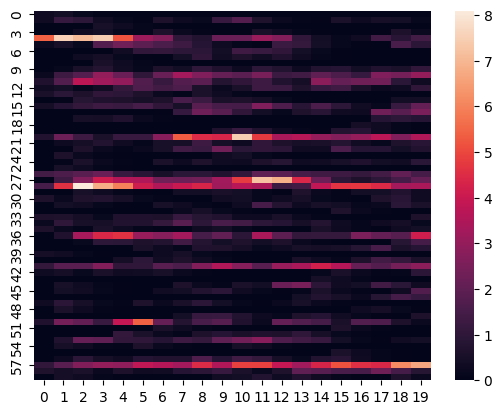

In [ ]:
sns.heatmap(neuron_pool)

In [ ]:
rat1 = rats_dfs[0]
clipped_duration = 2 #seconds


random_stage = np.random.choice(rat1.stage_id.unique())

stage_session = rat1.query(f'stage_id == {np.random.choice(rat1.stage_id.unique())}')

import random
window_left = random.uniform(stage_session.timestamp.min(),stage_session.timestamp.max()-2) #left end of the time window to be selected

session_segment = stage_session.query(f'timestamp > {window_left} and timestamp < {window_left + clipped_duration}')

lowres_segment_spikes = lower_firing_rate_resolution(convolve_raster(time_binning_stages(session_segment,[0,clipped_duration]))[0,:,:])


(1, 14, 2000)


In [ ]:
participation_ratio(lowres_segment_spikes)

2.6243929315443393

(1, 12, 2000)


<Axes: >

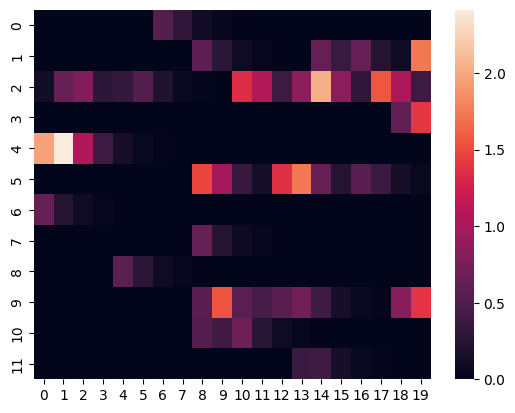

In [ ]:
sns.heatmap(lower_firing_rate_resolution(convolve_raster(time_binning_stages(session_segment,[0,clipped_duration]))[0,:,:]))

In [ ]:
def lower_firing_rate_resolution(spike_activity_matrix,time_window_size=100):

  '''
  Lower the resolution of a firing rate matrix with dimensions neurons x time bins by averaging over a window

  INPUT:
  - spike_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x time, in which each element (i,j) of the matrix represents the firing rate of neuron i at the j-th time bin
  - time_window_size [int]: time window over which the firing rates will be averaged (in ms)

  OUTPUT:
  - lowres_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x low_restime_bins, in which each element (i,j) of the matrix
                                            represents the firing rate of neuron i at the j-th low resolution time bin (by default of 100 ms width)
  '''

  (num_neurons,num_timebins) = np.shape(spike_activity_matrix)

  lowres_timebins = int(num_timebins/time_window_size)

  lowres_activity_matrix = np.zeros([num_neurons,lowres_timebins])

  for time_bin in range(lowres_timebins):
    lowres_activity_matrix[:,time_bin] = np.mean(spike_activity_matrix[:,time_bin*100:(time_bin+1)*100],axis=1)

  return lowres_activity_matrix

(1, 14, 2000)


<Axes: >

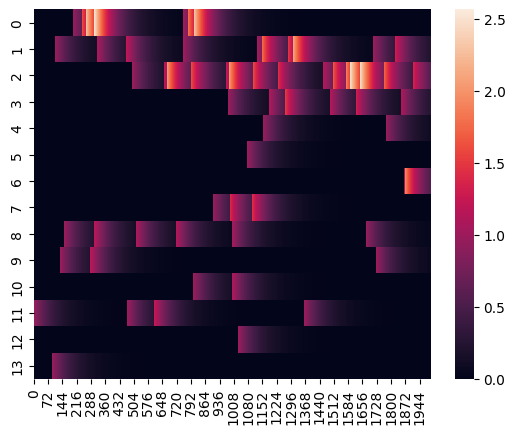

In [ ]:
sns.heatmap(convolve_raster(time_binning_stages(session_segmennt,[0,2]))[0,:,:])

<Axes: >

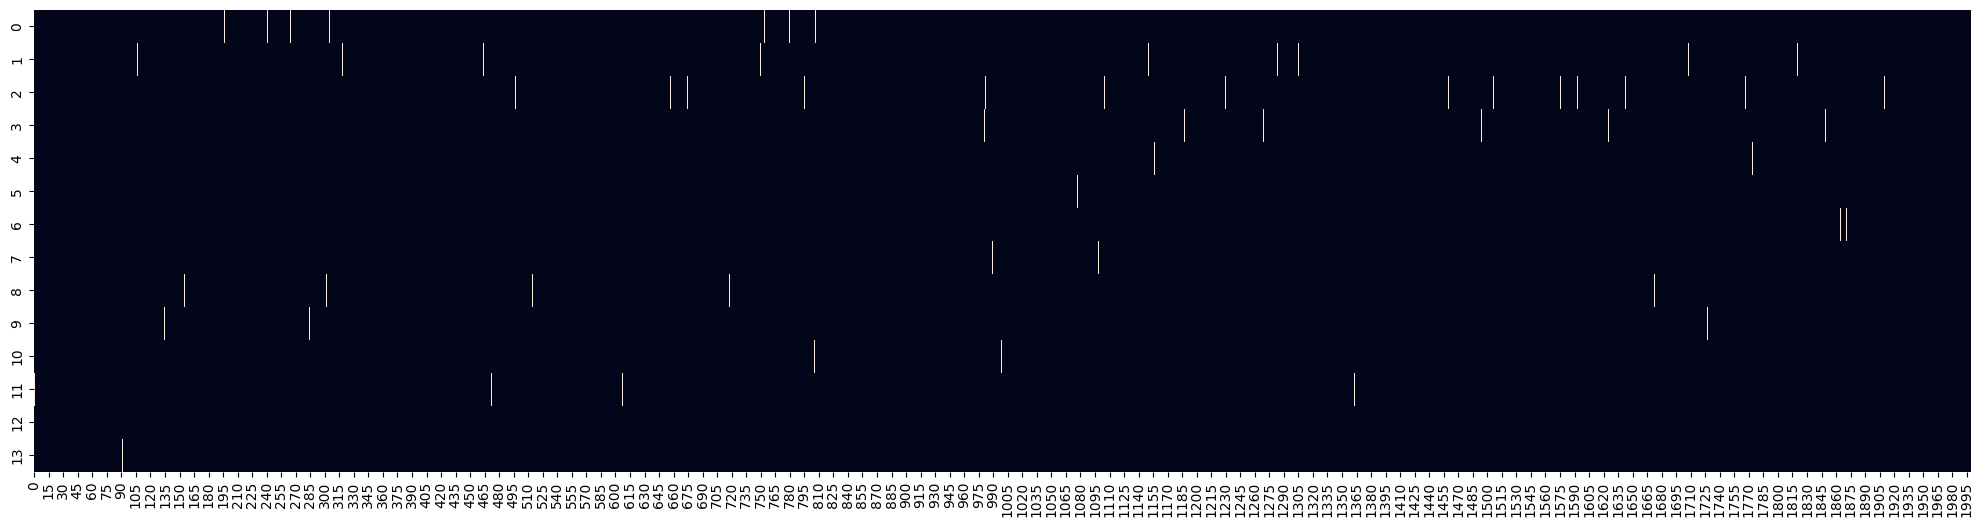

In [ ]:
fig, ax = plt.subplots(figsize=(25,6))
sns.heatmap(time_binning_stages(session_segmennt,[0,2])[0,:,:],cbar = False)

(1, 14, 2000)


<Axes: >

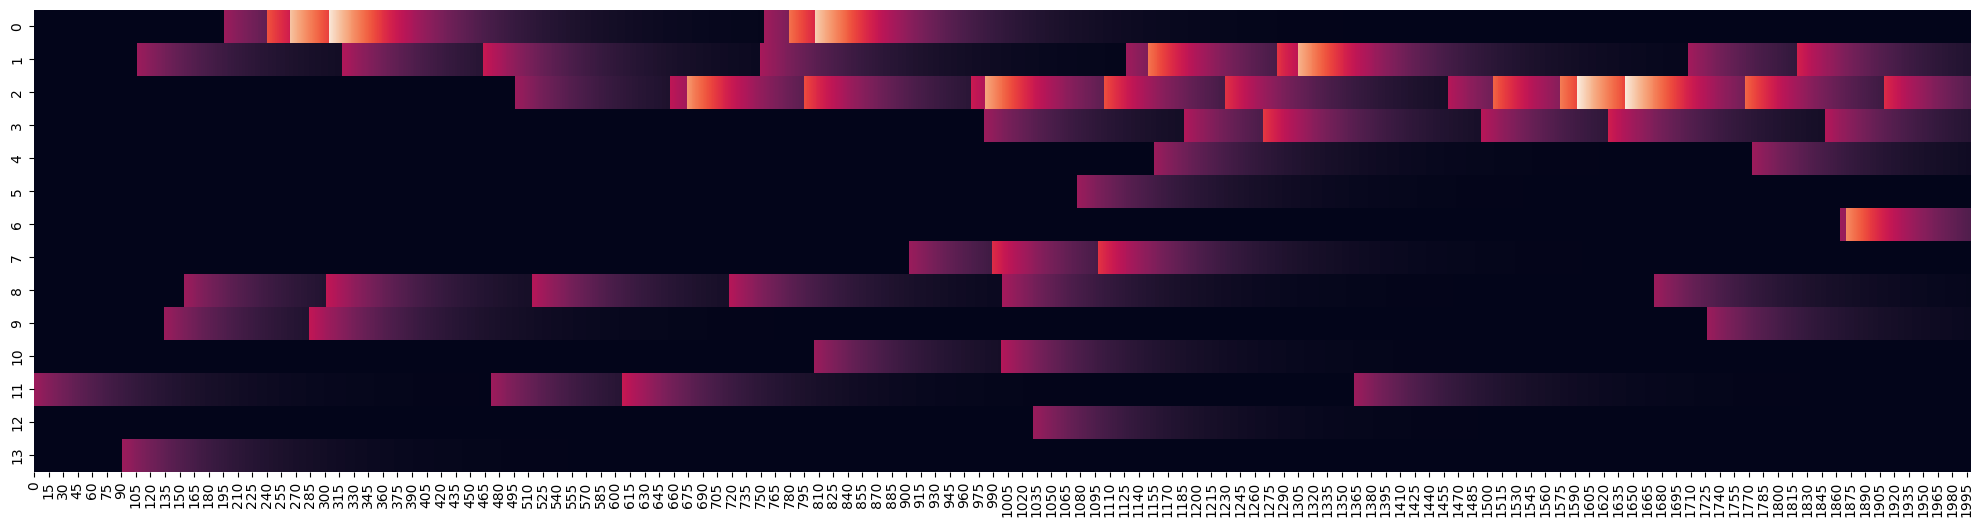

In [ ]:
fig, ax = plt.subplots(figsize=(25,6))
sns.heatmap(convolve_raster(time_binning_stages(session_segmennt,[0,2]))[0,:,:],cbar = False)

<Axes: >

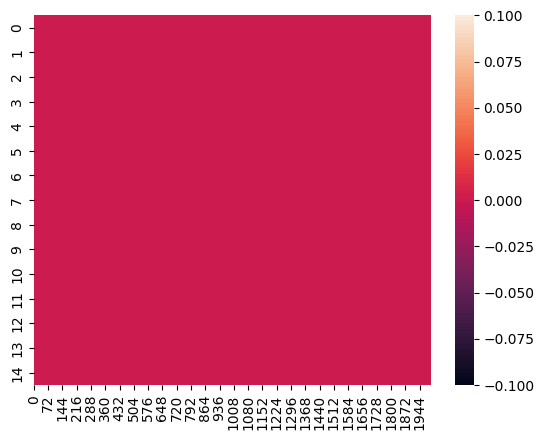

In [ ]:
stage_session = rat1.query(f'stage_id == {np.random.choice(rat1.stage_id.unique())} and timestamp > {window_left}')
stage_session

,timestamp,region,day,group,rat,neuron,stage,stage_id,stage_duration
0,3710.180767,PFC,1,2,3,0,WAKEstate,18,4776
1,3710.182933,PFC,1,2,3,0,WAKEstate,18,4776
2,3710.461000,PFC,1,2,3,0,WAKEstate,18,4776
3,3711.712600,PFC,1,2,3,0,WAKEstate,18,4776
4,3711.780600,PFC,1,2,3,0,WAKEstate,18,4776
...,...,...,...,...,...,...,...,...,...
1578,8433.551267,STR,1,2,3,15,WAKEstate,18,4776
1579,8440.579233,STR,1,2,3,15,WAKEstate,18,4776
1580,8465.874867,STR,1,2,3,15,WAKEstate,18,4776
1581,8477.809400,STR,1,2,3,15,WAKEstate,18,4776


In [ ]:
random.uniform(stage_session.timestamp.min(),stage_session.timestamp.max()-2)

146.76537435416566

In [ ]:
print(rat1.stage_id.unique())

stage = np.random.choice(rat1.stage_id.unique())
print(stage)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54]
6


In [ ]:
pr_distribution = []

#find the session beginning and end for each rat in that day

#before session only
for interval_id in current_session.query(f'timestamp < {session_beginning}').stage_id.unique():
  current_interval = current_session.query(f'stage_id == {interval_id}')

  binned_spikes = time_binning_stages(current_interval,timespan = [0,current_interval.timestamp.max() - current_interval.timestamp.min()])
  convolved_spikes = convolve_raster(binned_spikes)

  #lower the time resolution (from 1 ms resolution to 100 ms resolution by averaging over this 100 ms window)
  lowres_averaged = lower_firing_rate_resolution(convolved_spikes[0,:,:])

  """fig, ax = plt.subplots(figsize=(22, 9))

  rates = ax.matshow(lowres_averaged,aspect="auto",origin='lower')

  ax.xaxis.tick_bottom()
  ax.xaxis.set_label_position('bottom')
  ax.set_xlabel('Time (ms)')
  ax.set_ylabel('Neuron (#)')"""

  pr_in_stage = participation_ratio(lowres_averaged)

  #print(pr_in_stage)

  dimensionality_results.append(pr_in_stage)

mean_dimensionality = np.mean(dimensionality_results)

print(mean_dimensionality)

17

*   separate rats
*   for each rat: select 1000 random segments of 1.5s in duration, binarize each and store as a matrix with dimensions num_segments x num_neurons x timebins
*   


In [ ]:
def freely_moving_pooled_activity(day,event_type='WAKEstate'):

array(['PFC', 'STR'], dtype=object)

In [ ]:


#Select a session (rat,day) and type of period ('WAKEstate','REMstate','NREMstate')
rat_id = 3
day_id = 1
stage_type = 'WAKEstate'

session_beginning,session_end = [session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.min(),session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.max()]

current_session = all_scored_states.query(f'rat == {rat_id} and day == {day_id} and stage == "{stage_type}"')

# Average participation ratio in awake periods before and after training
Rats 3-6 only (Eliezyer's), for whom we have the data regarding these periods

In [ ]:
#Select a session (rat,day) and type of period ('WAKEstate','REMstate','NREMstate')
rat_id = 3
day_id = 1
stage_type = 'WAKEstate'

session_beginning,session_end = [session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.min(),session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.max()]

current_session = all_scored_states.query(f'rat == {rat_id} and day == {day_id} and stage == "{stage_type}"')

In [ ]:
current_session.query(f'timestamp < {session_beginning}').stage_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [ ]:
current_session.query(f'timestamp > {session_end}').stage_id.unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

In [ ]:
def time_binning_stages(spikes_df,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('stage_id').copy()

  num_stages = dataset.stage_id.nunique()
  num_neurons = dataset.neuron.nunique()

  duration = timespan[1] - timespan[0]
  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_stages,num_neurons,num_timebins])

  for stage_id,stage in enumerate(dataset.stage_id.unique()):
    stage_beginning = dataset.loc[dataset['stage_id'] == stage].timestamp.min()
    for neuron_id,neuron in enumerate(dataset.neuron.unique()):
      spike_train = dataset.loc[(dataset['stage_id'] == stage) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.timestamp - stage_beginning,bins = np.linspace(timespan[0],timespan[1],num_timebins+1,endpoint=True))
      binned_spikes_matrix[stage_id,neuron_id,:] = discretized_spike_train

  return binned_spikes_matrix

12794 begin: 966.0160333333332 end:  1153.9800333333333
(1, 16, 187964)


Text(0, 0.5, 'Neuron (#)')

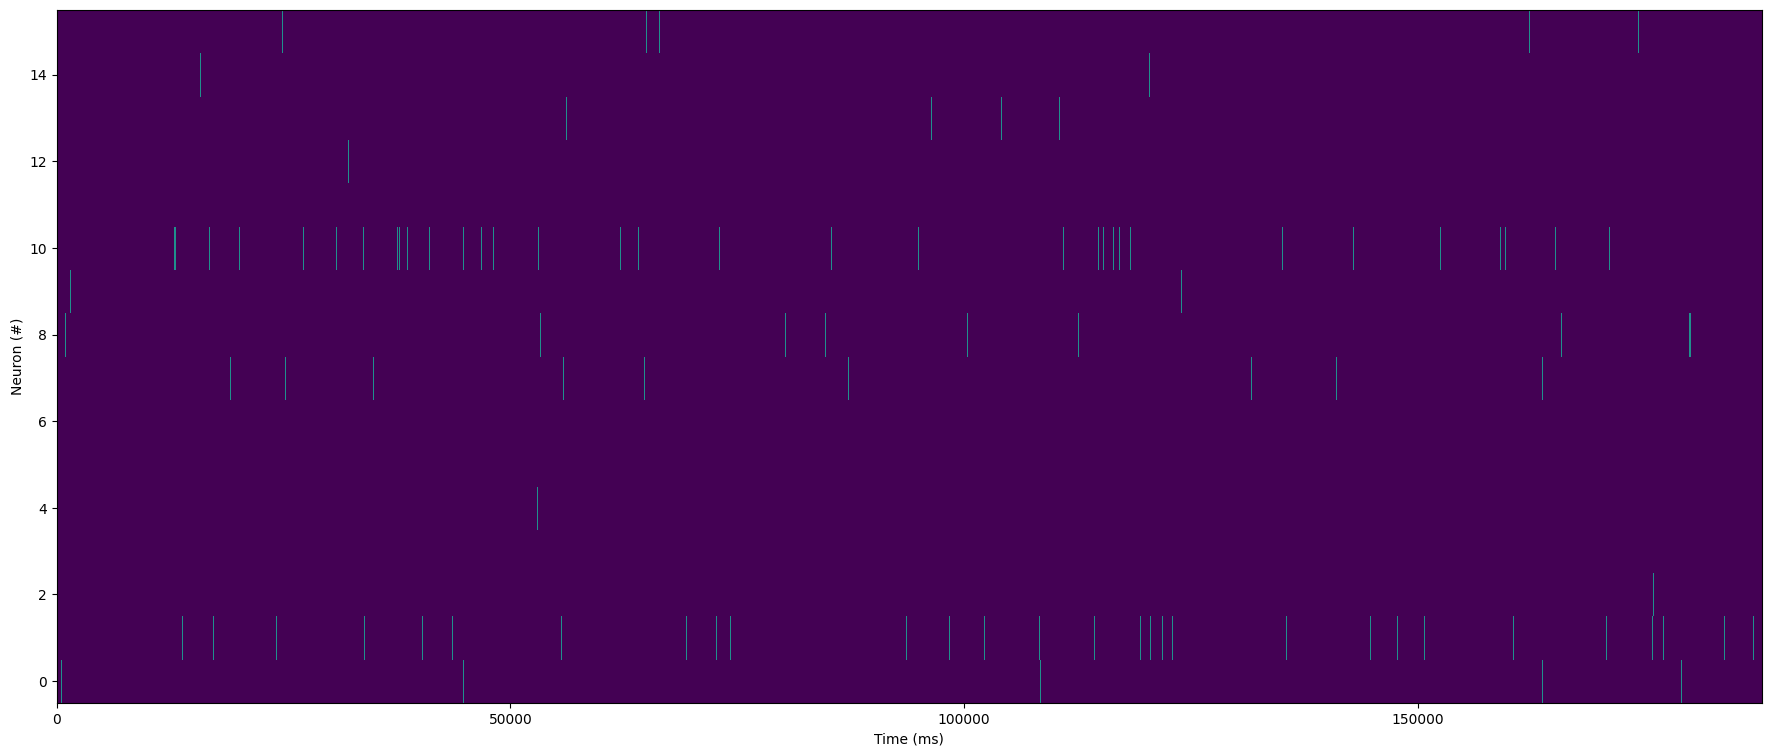

In [ ]:
current_interval = current_session.query('stage_id == 7')
print(len(current_interval),'begin:' ,current_interval.timestamp.min(),'end: ',current_interval.timestamp.max())
binned_spikes_test = time_binning_stages(current_interval,timespan = [0,current_interval.timestamp.max() - current_interval.timestamp.min()])

print(np.shape(binned_spikes_test))

fig, ax = plt.subplots(figsize=(22, 9))

rates = ax.matshow(binned_spikes_test[0,:,:],aspect="auto",origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron (#)')

In [ ]:
#participation_ratio	animal_id	session_part	group	day	region
#np.mean(dimensionality_results),animal_id,'before',2,1,region

In [ ]:
dimensionality_results = []

for interval_id in current_session.stage_id.unique():
  current_interval = current_session.query(f'stage_id == {interval_id}')

  binned_spikes = time_binning_stages(current_interval,timespan = [0,current_interval.timestamp.max() - current_interval.timestamp.min()])
  convolved_spikes = convolve_raster(binned_spikes)

  #lower the time resolution (from 1 ms resolution to 100 ms resolution by averaging over this 100 ms window)
  lowres_averaged = lower_firing_rate_resolution(convolved_spikes[0,:,:])

  """fig, ax = plt.subplots(figsize=(22, 9))

  rates = ax.matshow(lowres_averaged,aspect="auto",origin='lower')

  ax.xaxis.tick_bottom()
  ax.xaxis.set_label_position('bottom')
  ax.set_xlabel('Time (ms)')
  ax.set_ylabel('Neuron (#)')"""

  pr_in_stage = participation_ratio(lowres_averaged)

  #print(pr_in_stage)

  dimensionality_results.append(pr_in_stage)

mean_dimensionality = np.mean(dimensionality_results)

(1, 15, 13823)
(1, 15, 32991)
(1, 15, 6872)
(1, 16, 509843)
(1, 16, 28950)
(1, 14, 6885)
(1, 16, 14935)
(1, 16, 187964)
(1, 16, 243977)
(1, 15, 8957)
(1, 16, 107877)
(1, 15, 30949)
(1, 13, 10905)
(1, 15, 8981)
(1, 12, 6929)
(1, 16, 371981)
(1, 16, 40961)
(1, 12, 6987)
(1, 16, 4775980)
(1, 15, 11973)
(1, 16, 16992)
(1, 14, 10974)
(1, 16, 20892)
(1, 16, 15994)
(1, 15, 9980)
(1, 15, 8821)
(1, 14, 27977)
(1, 15, 7981)
(1, 15, 13949)
(1, 14, 13959)
(1, 14, 14983)
(1, 16, 224931)
(1, 16, 120963)
(1, 16, 302941)
(1, 16, 181997)
(1, 16, 6870)
(1, 14, 20978)
(1, 16, 50977)
(1, 16, 13985)
(1, 16, 82959)
(1, 16, 42990)
(1, 15, 29967)
(1, 16, 10955)
(1, 16, 242988)
(1, 16, 136965)
(1, 16, 171995)
(1, 16, 391970)
(1, 16, 59987)
(1, 16, 325958)
(1, 16, 61978)
(1, 15, 10934)
(1, 15, 8981)
(1, 15, 20966)
(1, 14, 9909)
(1, 16, 25982)


In [ ]:
dimensionality_results = []

#before session only
for interval_id in current_session.query(f'timestamp < {session_beginning}').stage_id.unique():
  current_interval = current_session.query(f'stage_id == {interval_id}')

  binned_spikes = time_binning_stages(current_interval,timespan = [0,current_interval.timestamp.max() - current_interval.timestamp.min()])
  convolved_spikes = convolve_raster(binned_spikes)

  #lower the time resolution (from 1 ms resolution to 100 ms resolution by averaging over this 100 ms window)
  lowres_averaged = lower_firing_rate_resolution(convolved_spikes[0,:,:])

  """fig, ax = plt.subplots(figsize=(22, 9))

  rates = ax.matshow(lowres_averaged,aspect="auto",origin='lower')

  ax.xaxis.tick_bottom()
  ax.xaxis.set_label_position('bottom')
  ax.set_xlabel('Time (ms)')
  ax.set_ylabel('Neuron (#)')"""

  pr_in_stage = participation_ratio(lowres_averaged)

  #print(pr_in_stage)

  dimensionality_results.append(pr_in_stage)

mean_dimensionality = np.mean(dimensionality_results)

print(mean_dimensionality)

(1, 15, 13823)
(1, 15, 32991)
(1, 15, 6872)
(1, 16, 509843)
(1, 16, 28950)
(1, 14, 6885)
(1, 16, 14935)
(1, 16, 187964)
(1, 16, 243977)
(1, 15, 8957)
(1, 16, 107877)
(1, 15, 30949)
(1, 13, 10905)
(1, 15, 8981)
(1, 12, 6929)
(1, 16, 371981)
(1, 16, 40961)
(1, 12, 6987)
(1, 16, 4775980)


In [ ]:
dimensionality_results = []

#after session only
for interval_id in current_session.query(f'timestamp > {session_end}').stage_id.unique():
  current_interval = current_session.query(f'stage_id == {interval_id}')

  binned_spikes = time_binning_stages(current_interval,timespan = [0,current_interval.timestamp.max() - current_interval.timestamp.min()])
  convolved_spikes = convolve_raster(binned_spikes)

  #lower the time resolution (from 1 ms resolution to 100 ms resolution by averaging over this 100 ms window)
  lowres_averaged = lower_firing_rate_resolution(convolved_spikes[0,:,:])

  """fig, ax = plt.subplots(figsize=(22, 9))

  rates = ax.matshow(lowres_averaged,aspect="auto",origin='lower')

  ax.xaxis.tick_bottom()
  ax.xaxis.set_label_position('bottom')
  ax.set_xlabel('Time (ms)')
  ax.set_ylabel('Neuron (#)')"""

  pr_in_stage = participation_ratio(lowres_averaged)

  #print(pr_in_stage)

  dimensionality_results.append(pr_in_stage)

mean_dimensionality = np.mean(dimensionality_results)

print(mean_dimensionality)

(1, 16, 4775980)
(1, 15, 11973)
(1, 16, 16992)
(1, 14, 10974)
(1, 16, 20892)
(1, 16, 15994)
(1, 15, 9980)
(1, 15, 8821)
(1, 14, 27977)
(1, 15, 7981)
(1, 15, 13949)
(1, 14, 13959)
(1, 14, 14983)
(1, 16, 224931)
(1, 16, 120963)
(1, 16, 302941)
(1, 16, 181997)
(1, 16, 6870)
(1, 14, 20978)
(1, 16, 50977)
(1, 16, 13985)
(1, 16, 82959)
(1, 16, 42990)
(1, 15, 29967)
(1, 16, 10955)
(1, 16, 242988)
(1, 16, 136965)
(1, 16, 171995)
(1, 16, 391970)
(1, 16, 59987)
(1, 16, 325958)
(1, 16, 61978)
(1, 15, 10934)
(1, 15, 8981)
(1, 15, 20966)
(1, 14, 9909)
(1, 16, 25982)
3.6647026188127585


# Scree plots from every session

In [ ]:
def scree_plot(spike_activity_matrix,plotting_axis,points_label=None,points_symbol='o'):
  '''
  Plot a scree plot from the eigenvalues of the covariance matrix from the spike activity

  INPUT:
  - spike_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x time, in which each element (i,j) of the matrix represents the firing rate of neuron i at the j-th time bin
  OUTPUT:
  None
  '''

  #if the matrix has been normalized (the sum over columns differ from zero) then normalize it by subtracting the average of each neuron from all of its time bins
  if not np.isclose(np.sum(spike_activity_matrix,axis=0),np.zeros(len(np.sum(spike_activity_matrix,axis=0)))).all():
    #Z-scoring so each column sums up to 0
    spike_activity_matrix = spike_activity_matrix - spike_activity_matrix.mean(axis=0, keepdims=True)

  #Estimate the covariance
  #cov = spike_activity_matrix @ spike_activity_matrix.T / len(spike_activity_matrix)
  cov = np.cov(spike_activity_matrix)

  (L, P) = np.linalg.eigh(cov) #(eigenvalues, eigenvectors) of the covariance matrix yield the directions of most variance (e.g. firing patterns encompassing multiple neurons)

  #Order the eigenvalues from greatest to lowest in magnitude
  idx = L.argsort()[::-1]
  L = L[idx]
  P = P[:,idx]

  plotting_axis.plot(np.cumsum(L)/np.sum(L), points_symbol,label=points_label)
  plotting_axis.set_xlabel('Eigenvalue index')
  plotting_axis.set_ylabel('Cumulative explained variance')

In [ ]:
def early_late_scree_plots_per_rat(separated_rats,group,day,region,num_bins = 15):
  dimensionality_results_early = []
  dimensionality_results_late = []
  rats_ids = []

  least_amount_of_trials = min([animal.trial.nunique() for animal in separated_rats])
  trials_in_thirds = int(least_amount_of_trials/3)

  for animal in separated_rats:
      #Get the animal's label to later identify it in the DataFrame
      animal_label = animal.rat.unique()[0]
      print('Beginning the analyses for the rat: ',animal_label)

      animal_pruned = least_amount_spikes(animal,num_spikes_threshold=5)
      current_num_neurons = animal_pruned.neuron.nunique()

      print(animal_pruned.trial.nunique())

      binned_spikes = time_binning(animal_pruned)
      convolved_spikes = convolve_raster(binned_spikes)

      #average over the first and last third of trials
      averaged_early = np.mean(convolved_spikes[0:trials_in_thirds,:,:],axis=0)
      averaged_late = np.mean(convolved_spikes[-trials_in_thirds:,:,:],axis=0)

      #lower the time resolution (from 1 ms resolution to 100 ms resolution by averaging over this 100 ms window)
      lowres_averaged_early = lower_firing_rate_resolution(averaged_early)
      lowres_averaged_late = lower_firing_rate_resolution(averaged_late)

      fig, ax = plt.subplots(figsize=(10,5))

      scree_plot(lowres_averaged_early,ax,points_label = 'Early trials',points_symbol='o')
      scree_plot(lowres_averaged_late,ax,points_label = 'Late trials',points_symbol='*')
      plt.legend()
      plt.show()

Beginning the analyses for the rat:  7
603
(603, 17, 1500)


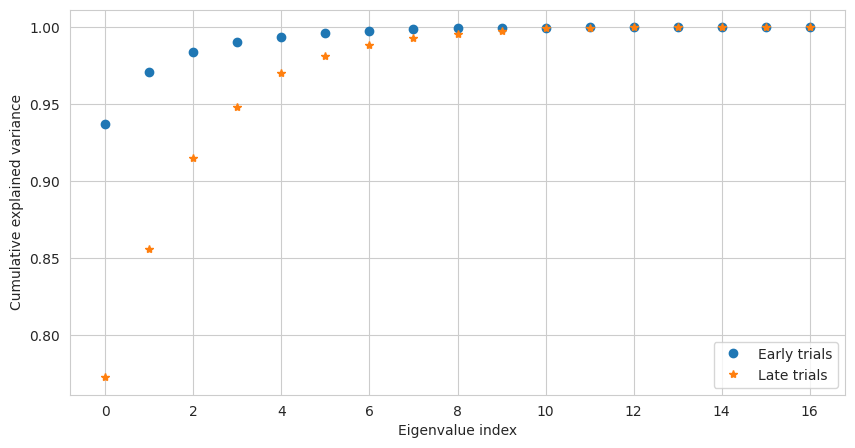

Beginning the analyses for the rat:  8
407
(407, 35, 1500)


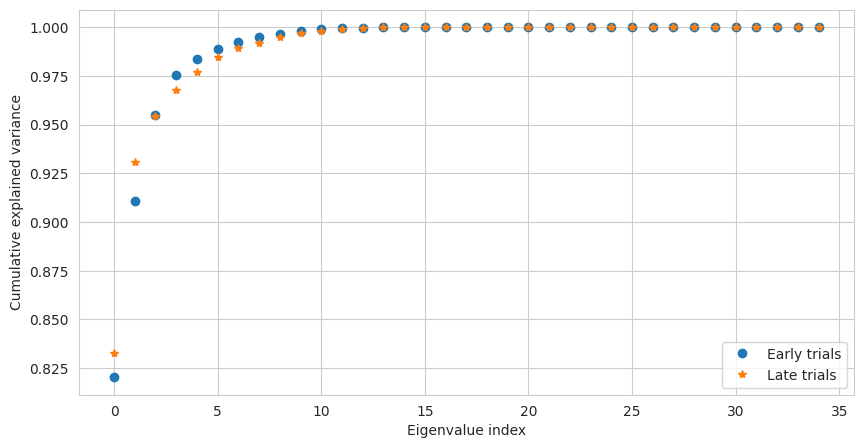

Beginning the analyses for the rat:  9
362
(362, 10, 1500)


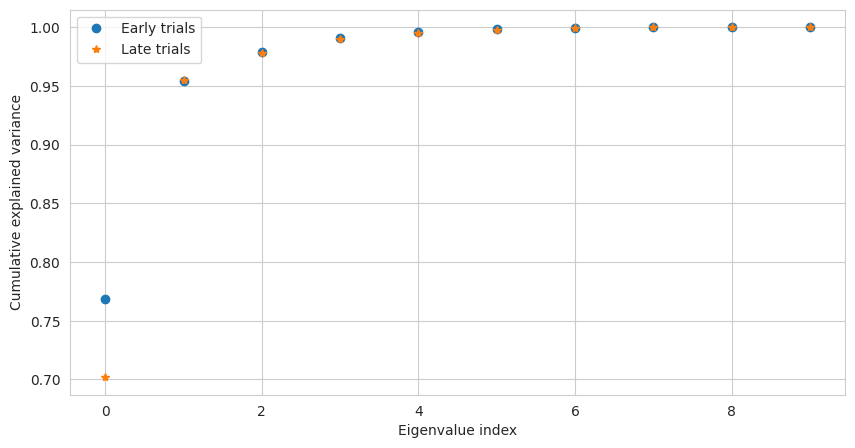

Beginning the analyses for the rat:  10
850
(850, 9, 1500)


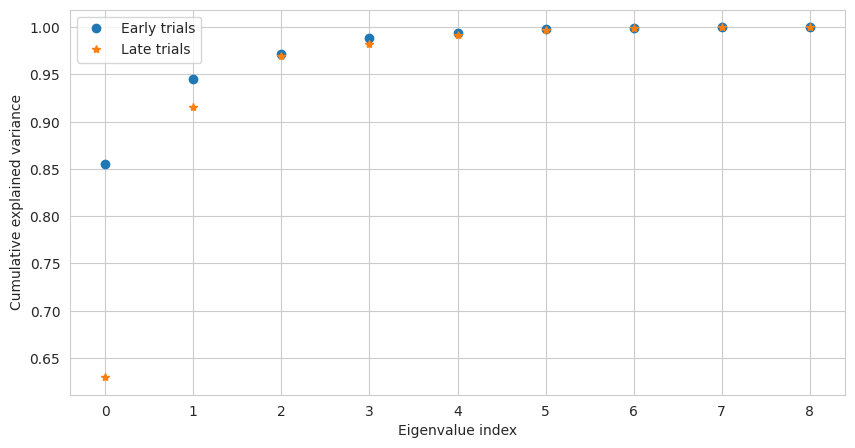

Beginning the analyses for the rat:  3
262
(262, 4, 1500)


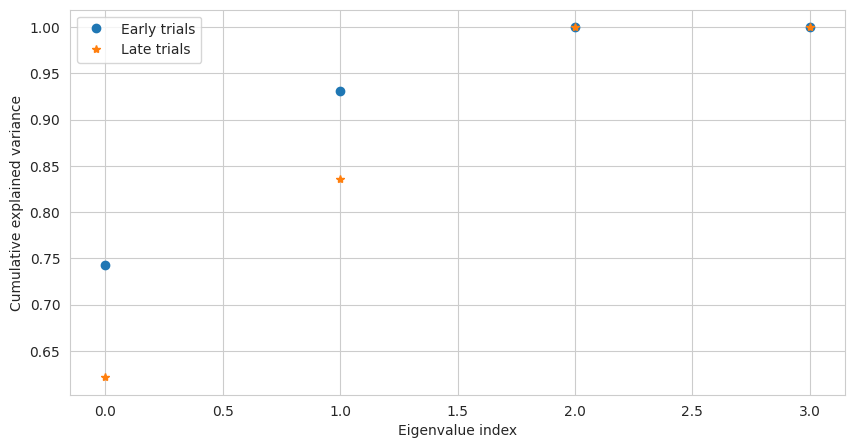

Beginning the analyses for the rat:  4
182
(182, 33, 1500)


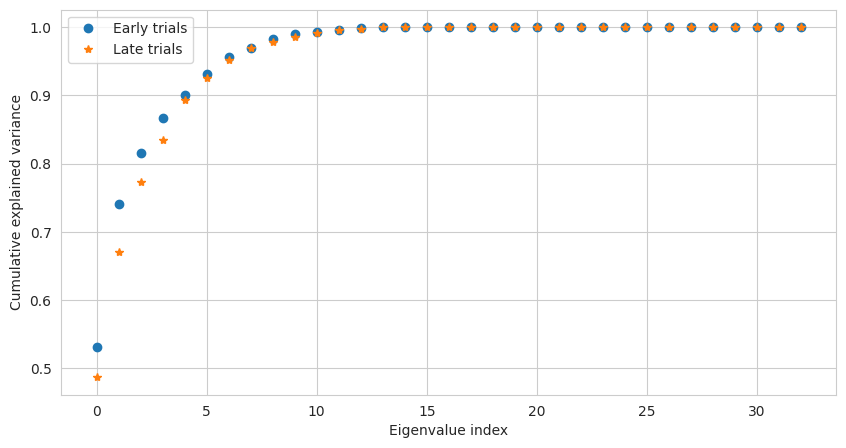

Beginning the analyses for the rat:  5
108
(108, 5, 1500)


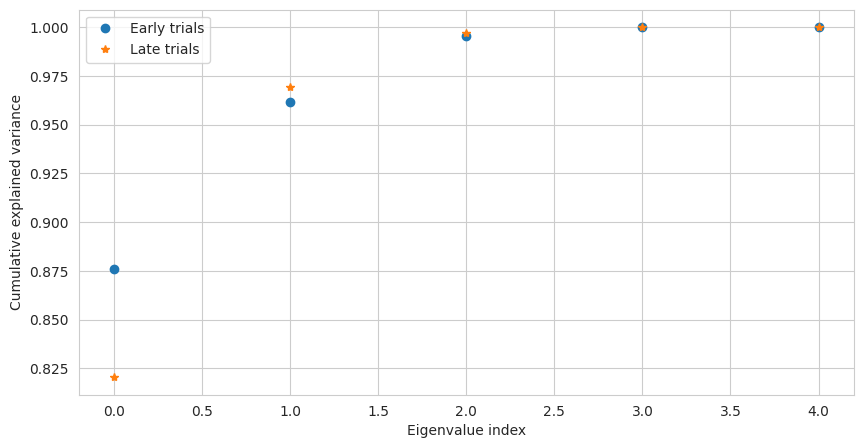

Beginning the analyses for the rat:  6
385
(385, 4, 1500)


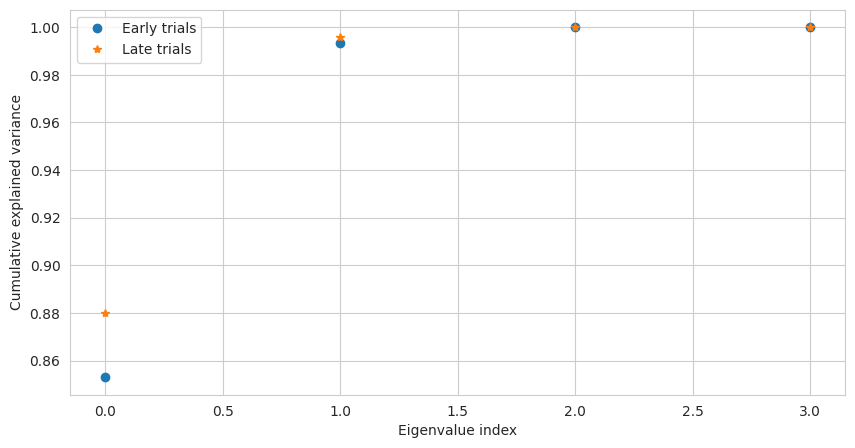

Beginning the analyses for the rat:  3
262
(262, 12, 1500)


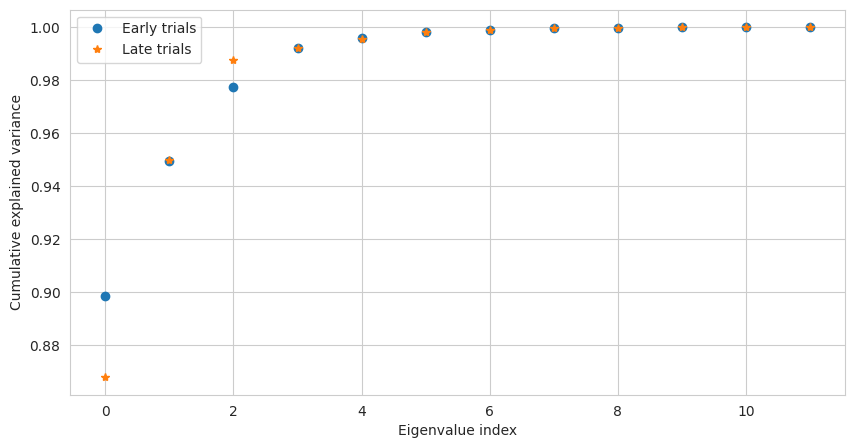

Beginning the analyses for the rat:  4
182
(182, 26, 1500)


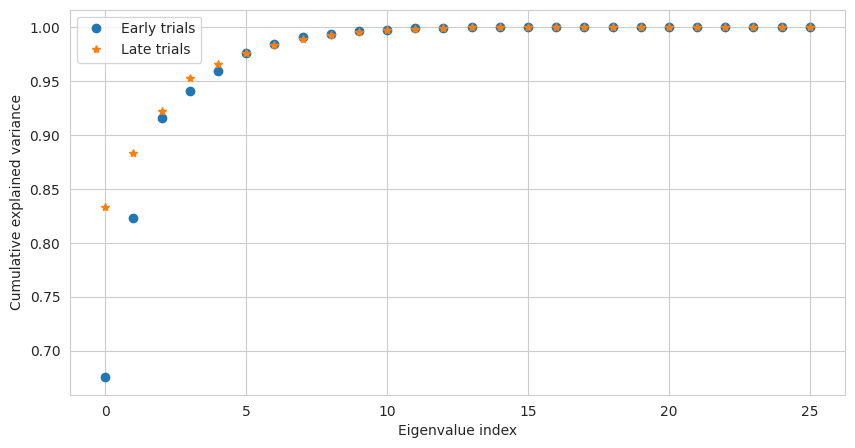

Beginning the analyses for the rat:  5
147
(147, 16, 1500)


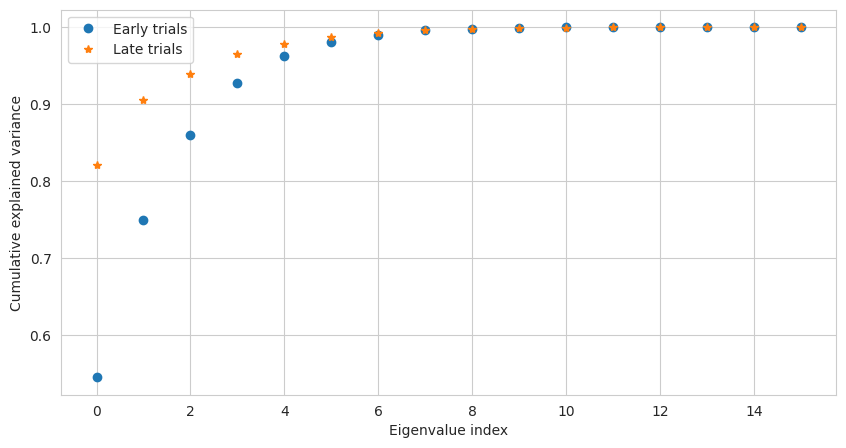

Beginning the analyses for the rat:  3
398
(398, 14, 1500)


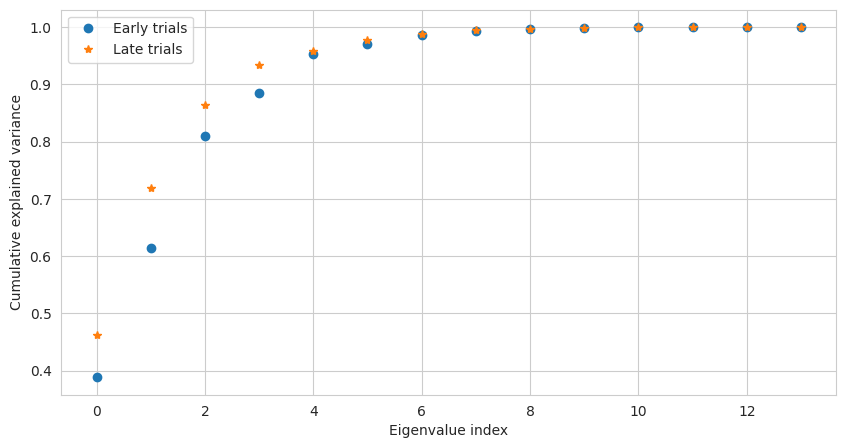

Beginning the analyses for the rat:  4
175
(175, 28, 1500)


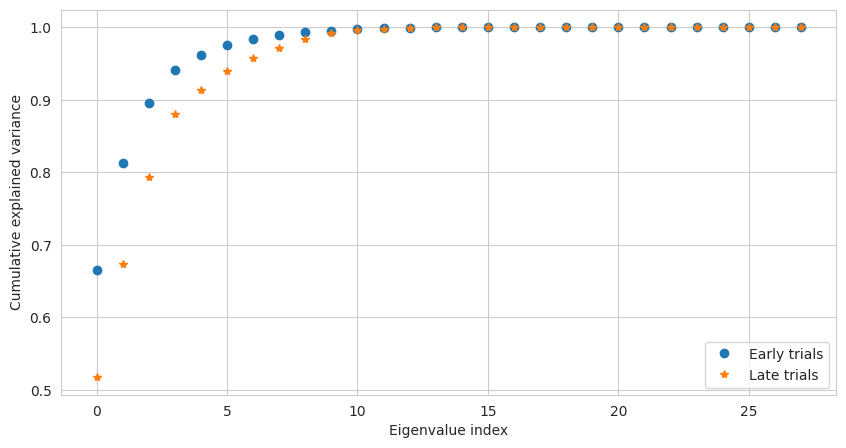

Beginning the analyses for the rat:  5
186
(186, 5, 1500)


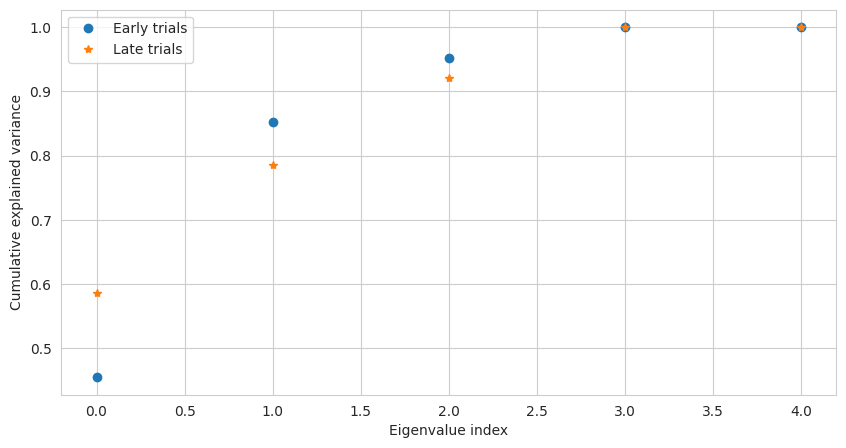

Beginning the analyses for the rat:  3
398
(398, 16, 1500)


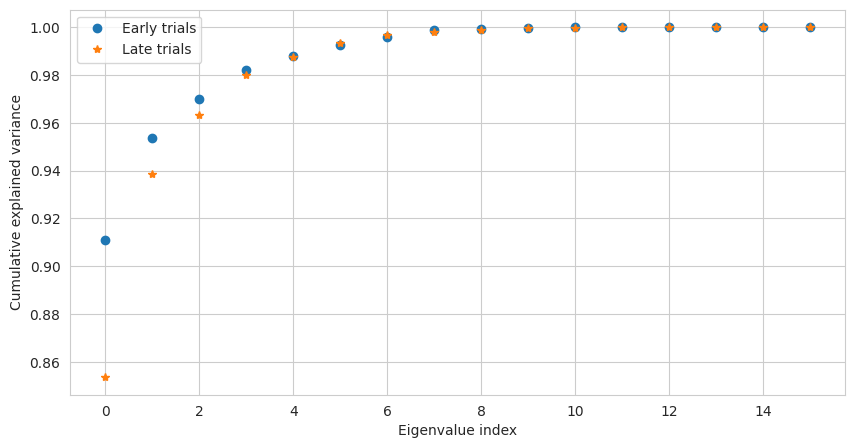

Beginning the analyses for the rat:  4
175
(175, 16, 1500)


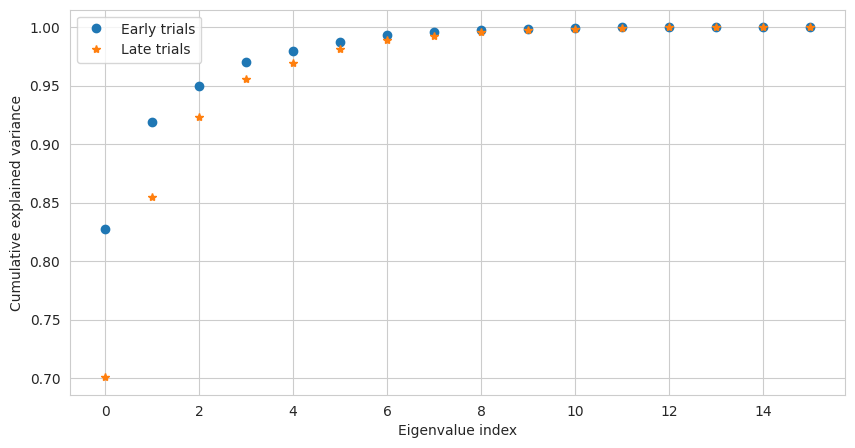

Beginning the analyses for the rat:  5
192
(192, 23, 1500)


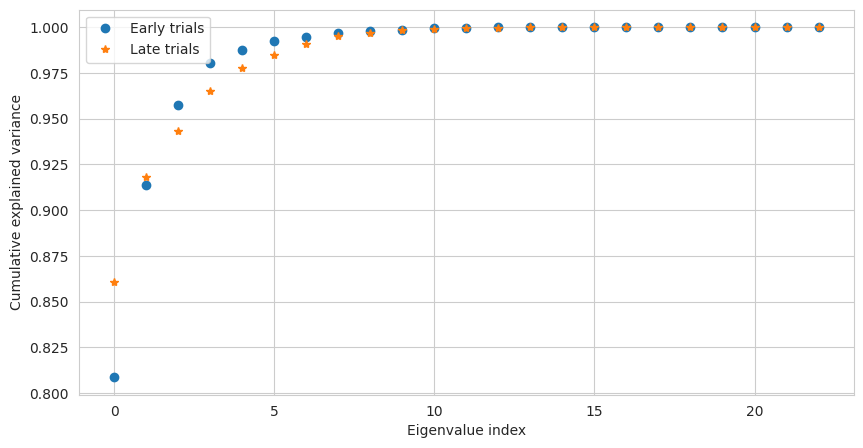

Beginning the analyses for the rat:  6
371
(371, 5, 1500)


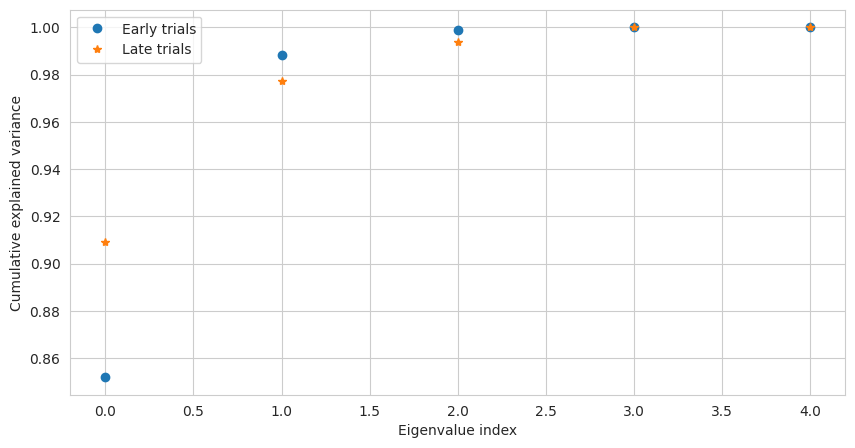

In [ ]:
def query_session(spikes_dataframe,group,day,region,filter_trials_between=[1.5,3.5],peri_trial_interval=-0.5):
  data_subset = spikes_dataframe.query(f'group == {group} and day == {day} and region == "{region}" and duration >= {filter_trials_between[0]} and duration <= {filter_trials_between[1]}' +
                                       f'and time >= {peri_trial_interval} and time <= {filter_trials_between[0]}').copy()

  return data_subset

data = session_data.copy()

######## Group 1, day 1 ###########

separated_rats = separate_rats(query_session(data,group=1,day=1,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g1d1_PFC = early_late_scree_plots_per_rat(separated_rats,group=1,region='PFC',day=1)

######## Group 2, day 1 ###########
separated_rats = separate_rats(query_session(data,group=2,day=1,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g2d1_PFC = early_late_scree_plots_per_rat(separated_rats,group=2,region='PFC',day=1)

separated_rats = separate_rats(query_session(data,group=2,day=1,region='STR'),check_num_neurons=True,min_num_neurons = 4)
g2d1_STR = early_late_scree_plots_per_rat(separated_rats,group=2,region='STR',day=1)


######## Group 2, day 2 ###########
separated_rats = separate_rats(query_session(data,group=2,day=2,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g2d2_PFC = early_late_scree_plots_per_rat(separated_rats,group=2,region='PFC',day=2)

separated_rats = separate_rats(query_session(data,group=2,day=2,region='STR'),check_num_neurons=True,min_num_neurons = 4)
g2d2_STR = early_late_scree_plots_per_rat(separated_rats,group=2,region='STR',day=2)

# cross correlation of spike trains (from convolved firing rates)

In [ ]:
def time_binning(spikes_df,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('stage_id').copy()

  num_stages = dataset.stage_id.nunique()
  num_neurons = dataset.neuron.nunique()

  duration = timespan[1] - timespan[0]

  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_stages,num_neurons,num_timebins])


  for stage_id,stage in enumerate(dataset.stage_id.unique()):
    stage_beginning = dataset.loc[dataset['stage_id'] == stage].timestamp.min()
    for neuron_id,neuron in enumerate(dataset.neuron.unique()):
      spike_train = dataset.loc[(dataset['stage_id'] == stage) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.timestamp - stage_beginning,bins = np.linspace(timespan[0] - stage_beginning,timespan[1] - stage_beginning,num_timebins+1,endpoint=True))
      binned_spikes_matrix[stage_id,neuron_id,:] = discretized_spike_train
  return binned_spikes_matrix

In [ ]:
#Load the spikes' dataframe
scored_states_spikes = pd.read_csv('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels//data/all_scored_states.csv')

In [ ]:
scored_states_spikes.sort_values('stage_duration')

,Unnamed: 0,timestamp,region,day,group,rat,neuron,stage,stage_id,stage_duration
50497,8,3513.942433,STR,1,2,3,6,NREMstate,16,2
26611,2,3513.182800,PFC,1,2,3,3,NREMstate,16,2
26610,1,3513.004633,PFC,1,2,3,3,NREMstate,16,2
26609,0,3512.291533,PFC,1,2,3,3,NREMstate,16,2
84626,0,3512.343167,PFC,1,2,3,8,NREMstate,16,2
...,...,...,...,...,...,...,...,...,...,...
10181194,331,3717.962867,STR,2,2,6,1,WAKEstate,6,4965
10181195,332,3718.684200,STR,2,2,6,1,WAKEstate,6,4965
10181196,333,3719.140533,STR,2,2,6,1,WAKEstate,6,4965
10181190,327,3715.120267,STR,2,2,6,1,WAKEstate,6,4965


In [ ]:
scored_states_spikes.query(f'rat == 3 and day == 1 and stage == "NREMstate"').sort_values('stage_duration').head(500)

,Unnamed: 0,timestamp,region,day,group,rat,neuron,stage,stage_id,stage_duration
121929,3,3512.671433,STR,1,2,3,13,NREMstate,16,2
26609,0,3512.291533,PFC,1,2,3,3,NREMstate,16,2
50498,9,3513.967633,STR,1,2,3,6,NREMstate,16,2
3277,0,3512.023500,PFC,1,2,3,0,NREMstate,16,2
103134,3,3512.619800,STR,1,2,3,12,NREMstate,16,2
...,...,...,...,...,...,...,...,...,...,...
17001,4,8488.878533,STR,1,2,3,2,NREMstate,18,6
17000,3,8488.825967,STR,1,2,3,2,NREMstate,18,6
16999,2,8488.772500,STR,1,2,3,2,NREMstate,18,6
16998,1,8488.705067,STR,1,2,3,2,NREMstate,18,6


In [ ]:
NREM_target_session = scored_states_spikes.query(f'rat == 3 and day == 1 and stage == "NREMstate"')
num_neurons = NREM_target_session.neuron.nunique()
num_periods = NREM_target_session.stage_id.nunique()

In [ ]:
correlation_matrices = np.zeros([num_periods,num_neurons,num_neurons])

In [ ]:
def time_binning2(spikes_df,num_neurons,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('stage_id').copy()

  num_stages = dataset.stage_id.nunique()

  duration = timespan[1] - timespan[0]

  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_stages,num_neurons,num_timebins])
  print(np.shape(binned_spikes_matrix))

  for stage_id,stage in enumerate(dataset.stage_id.unique()):
    stage_beginning = dataset.loc[dataset['stage_id'] == stage].timestamp.min()
    for neuron in dataset.neuron.unique():
      print(neuron)
      spike_train = dataset.loc[(dataset['stage_id'] == stage) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.timestamp - stage_beginning,bins = np.linspace(timespan[0] - stage_beginning,timespan[1] - stage_beginning,num_timebins+1,endpoint=True))
      binned_spikes_matrix[stage_id,neuron,:] = discretized_spike_train
  return binned_spikes_matrix

def symmetrize(a):
    """
    Return a symmetrized version of NumPy array a.

    Values 0 are replaced by the array value at the symmetric
    position (with respect to the diagonal), i.e. if a_ij = 0,
    then the returned array a' is such that a'_ij = a_ji.

    Diagonal values are left untouched.

    a -- square NumPy array, such that a_ij = 0 or a_ji = 0,
    for i != j.
    """
    return a + a.T - np.diag(a.diagonal())

In [ ]:
symmetrized_correlation_matrices = [symmetrize(correlation_matrices[i,:,:]) for i in range(np.shape(correlation_matrices)[0])]

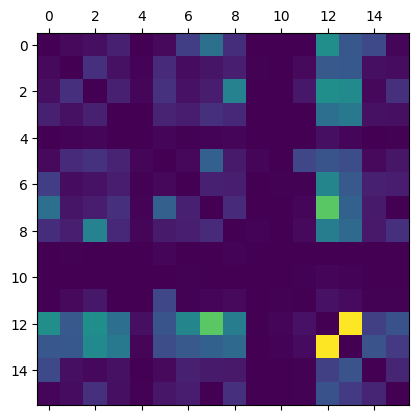

In [ ]:
plt.matshow(symmetrized_correlation_matrices[2])

In [ ]:
#shazam

from itertools import combinations

for period_id in NREM_target_session.stage_id.unique():
  period_spikes = NREM_target_session.query(f'stage_id == {period_id}')
  binned_period_spikes = time_binning2(spikes_df = period_spikes,num_neurons=num_neurons,timespan=[period_spikes.timestamp.min(),period_spikes.timestamp.max()])
  firing_rates = np.squeeze(convolve_raster(binned_period_spikes))

  for neuron1,neuron2 in combinations(range(num_neurons),2):
    correlation_between_pair = np.correlate(firing_rates[neuron1,:],firing_rates[neuron2,:])
    correlation_matrices[period_id,neuron1,neuron2] = correlation_between_pair

symmetrized_correlation_matrices = [symmetrize(correlation_matrices[i,:,:]) for i in range(np.shape(correlation_matrices)[0])]
average_correlation_over_periods = np.mean(symmetrized_correlation_matrices,axis=0)

(1, 16, 13780)
0
12
13
8
9
14
3
2
5
1
7
6
(1, 16, 13780)
(1, 16, 86885)
0
12
13
9
8
11
10
14
15
2
1
3
7
6
5
4
(1, 16, 86885)
(1, 16, 27951)
0
12
13
11
10
14
15
9
8
2
3
4
5
1
7
6
(1, 16, 27951)
(1, 16, 7986)
0
12
11
7
8
9
13
14
15
2
3
1
6
4
5
(1, 16, 7986)
(1, 16, 25901)
0
12
8
9
11
13
14
3
4
5
6
1
2
7
(1, 16, 25901)
(1, 16, 105989)
0
12
8
9
11
10
14
13
15
2
3
1
5
4
6
7
(1, 16, 105989)
(1, 16, 5932)
0
12
6
7
8
9
13
14
1
2
3
5
(1, 16, 5932)
(1, 16, 4973)
0
12
13
8
9
10
14
3
5
6
2
1
7
(1, 16, 4973)
(1, 16, 15848)
0
12
11
10
9
7
6
8
13
14
15
2
3
1
5
4
(1, 16, 15848)
(1, 16, 18964)
0
12
9
11
8
7
14
15
13
2
1
3
6
5
4
(1, 16, 18964)
(1, 16, 348904)
0
12
9
10
11
8
7
14
13
15
2
1
3
6
5
4
(1, 16, 348904)
(1, 16, 14956)
0
12
13
11
8
7
10
9
14
15
5
4
3
2
6
1
(1, 16, 14956)
(1, 16, 149982)
0
9
8
12
11
10
7
6
14
13
15
2
3
1
5
4
(1, 16, 149982)
(1, 16, 322980)
0
9
10
11
12
8
7
6
14
13
15
2
3
1
5
4
(1, 16, 322980)
(1, 16, 199925)
0
11
10
9
12
8
7
13
14
15
3
2
5
4
1
6
(1, 16, 199925)
(1, 16, 122923)
0


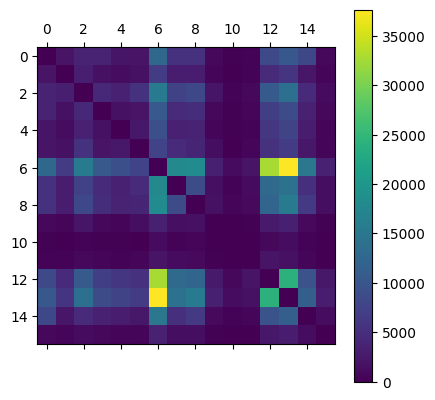

In [ ]:
razz = plt.matshow(average_correlation_over_periods)
plt.colorbar(razz)

In [ ]:
max(average_correlation_over_periods.flatten())

37663.263285081746

In [ ]:
max(symmetrized_correlation_matrices[0].flatten())

3029.7535210082233

In [ ]:
num_neurons

16

In [ ]:
np.shape(np.squeeze(firing_rates))

(16, 111971)

In [ ]:
binned_spikes_matrix_test = time_binning(longest_sleep_period,[longest_sleep_period.timestamp.min(),longest_sleep_period.timestamp.max()])

1.9561000000003332
0 16
3512.0180666666665
58


In [ ]:
np.shape(binned_spikes_matrix_test)

(1, 10, 1956)

Text(0, 0.5, 'Neuron (#)')

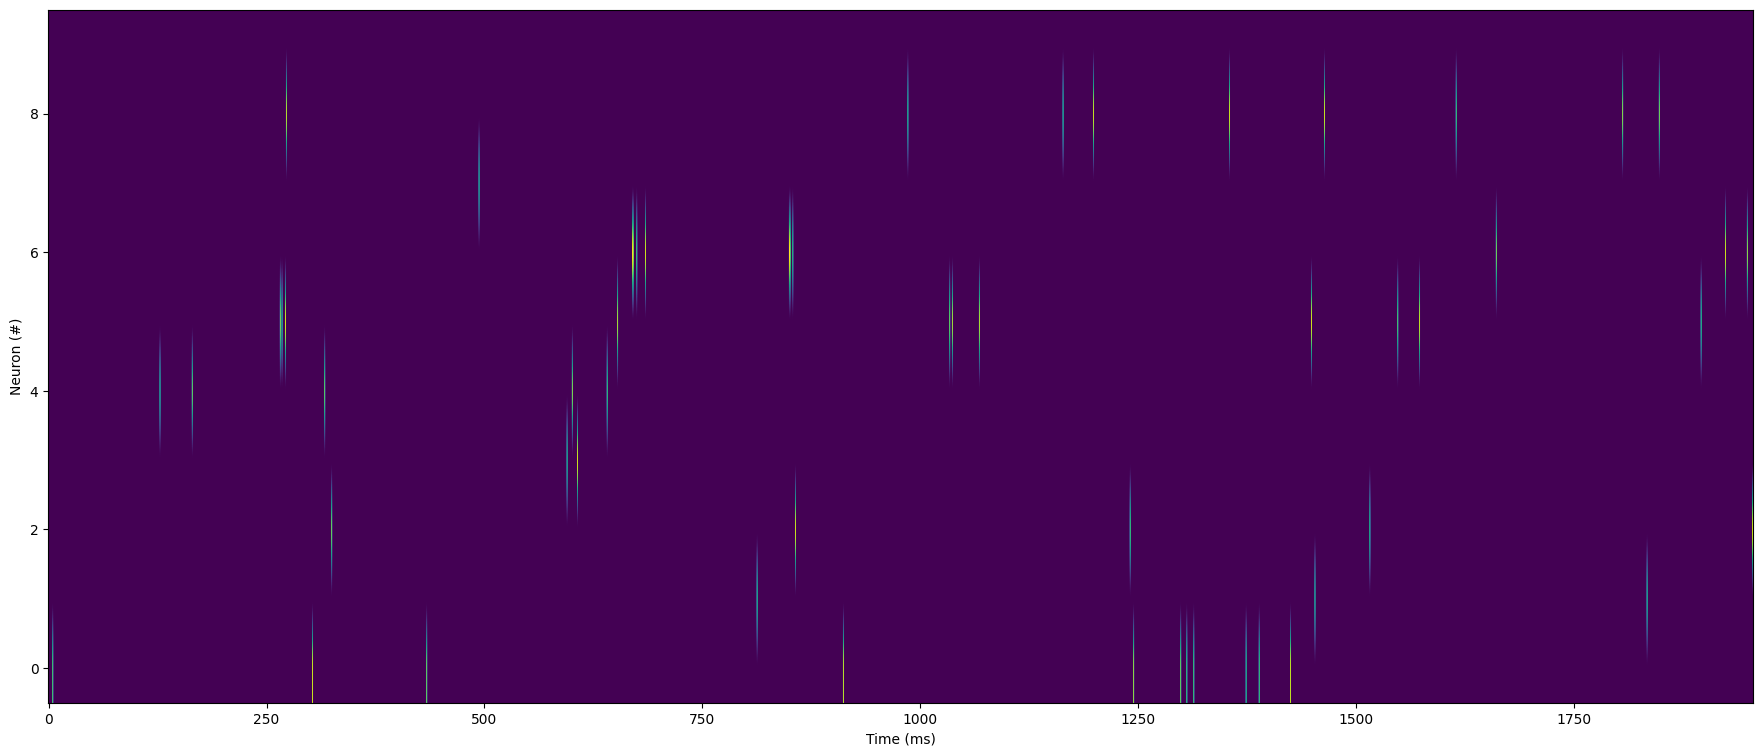

In [ ]:
fig, ax = plt.subplots(figsize=(22, 9))

rates = ax.imshow(binned_spikes_matrix_test[0,:,:],aspect='auto',origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron (#)')

In [ ]:
firing_rates = convolve_raster(binned_spikes_matrix_test)

(1, 10, 1956)


Text(0, 0.5, 'Neuron (#)')

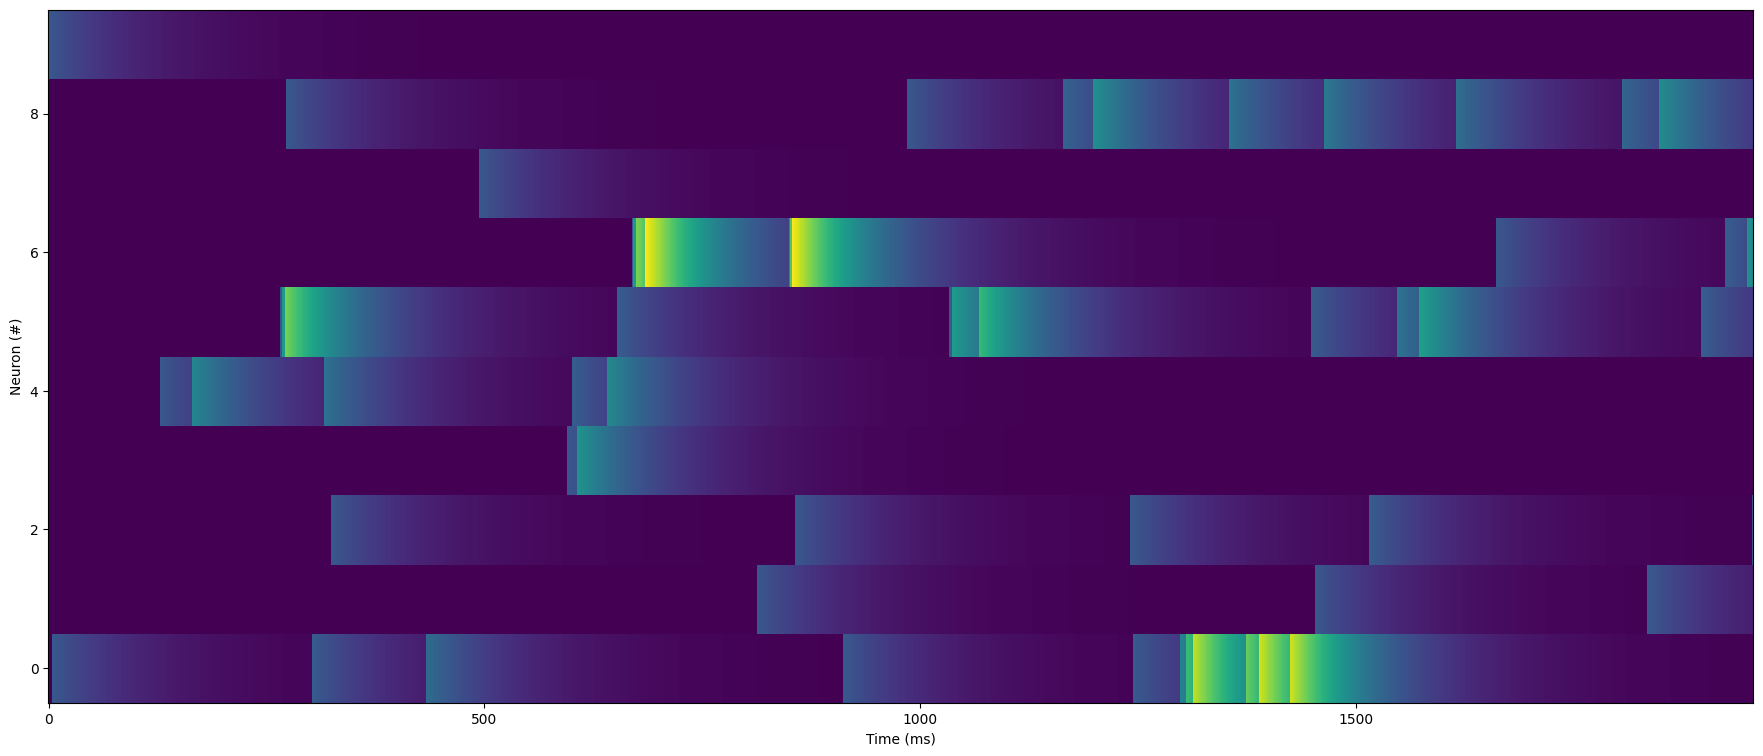

In [ ]:
fig, ax = plt.subplots(figsize=(22, 9))

rates = ax.matshow(firing_rates[0,:,:],aspect="auto",origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron (#)')

In [ ]:
np.shape(firing_rates[0,:,:])

(10, 1956)

In [ ]:
from itertools import combinations

for neuron1,neuron2 in combinations(range(10),2):
  print(neuron1,neuron2)

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9


In [ ]:
correlations_matrix = np.zeros([,10,10])

for neuron1,neuron2 in combinations(range(10),2):
  correlation_between_pair = np.correlate(firing_rates[0,neuron1,:],firing_rates[0,neuron2,:])
  correlations_matrix[neuron1,neuron2] = correlation_between_pair
  print(correlation_between_pair)

[153.86246851]
[323.49647795]
[29.12101912]
[140.15577906]
[491.75065994]
[155.80159119]
[36.24757877]
[633.39276969]
[51.05121869]
[68.8886672]
[12.09491308]
[15.50144063]
[137.72629806]
[180.42005473]
[2.06730949]
[175.85427102]
[0.]
[14.30460475]
[79.18375383]
[244.20167422]
[201.70899781]
[10.61715058]
[199.18738619]
[1.94671845]
[170.73463553]
[74.45178095]
[217.15372047]
[34.61216468]
[6.51684753]
[0.23356299]
[274.46506146]
[278.64575365]
[40.57992088]
[68.00412235]
[25.96216014]
[345.26924126]
[26.70917862]
[572.23487005]
[10.33313602]
[37.1208352]
[151.97866789]
[0.18156067]
[5.95482087]
[0.35634246]
[3.27713496]


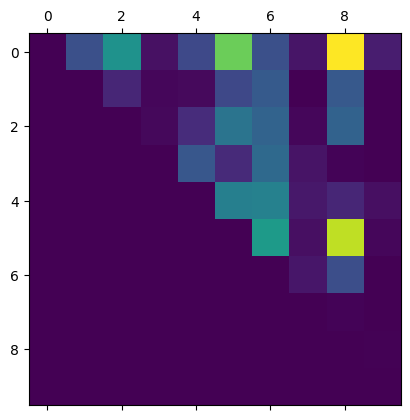

In [ ]:
plt.matshow(correlations_matrix)

In [ ]:
def symmetrize(a):
    """
    Return a symmetrized version of NumPy array a.

    Values 0 are replaced by the array value at the symmetric
    position (with respect to the diagonal), i.e. if a_ij = 0,
    then the returned array a' is such that a'_ij = a_ji.

    Diagonal values are left untouched.

    a -- square NumPy array, such that a_ij = 0 or a_ji = 0,
    for i != j.
    """
    return a + a.T - np.diag(a.diagonal())

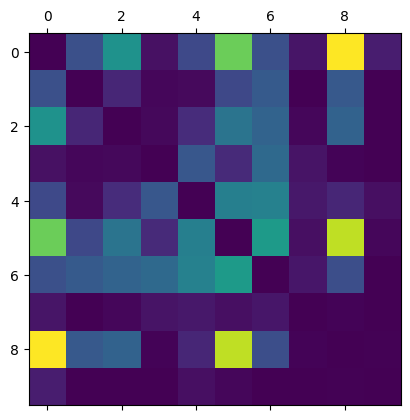

In [ ]:
plt.matshow(symmetrize(correlations_matrix))

# trying out

In [ ]:
def separate_rats(dataframe,check_num_neurons=True,min_num_neurons = 2):
    #Separate the dataframe by rat, and store each part as an entry in a list

    # INPUT:
    # - dataframe
    # - check_num_neurons: check whether a rat in this dataframe has less than min_num_neurons (default: True)
    # - min_num_neurons: the least amount of neurons an animal has to have in order to be included (default: 2)

    # OUTPUT:
    # - rats: a list of DataFrames, each entry being the subset of the main DataFrame with the spikes from one rat

    rats = []
    for rat in dataframe['rat'].unique():

        #Check whether a rat has only one registered neuron in the dataset
        if check_num_neurons:
            if dataframe.loc[dataframe['rat']==rat].neuron.nunique() < min_num_neurons:
                #If it's less than min_num_neurons, skip to the next animal
                continue
            #If one's not checking (check_num_neurons = False) or the animal has sufficient neurons, save it
        rats.append(dataframe.loc[dataframe['rat'] == rat])
    return rats #an array of dataframes (!)

def estimate_sqi(binned_spikes,num_entropic_bins=15,mean_over_trials=True):

    #Estimate the Sequentiality Index (SqI) as defined in [1] for N neurons over M trials

    #Python version of the code originally written in Matlab by Dean Buonomano and Shanglin Zhou in 9/14/2019
    #Original available at: github.com/ShanglinZhou/M2_DLS_2Intervals

    # INPUT:
    # - convolved_spikes [np.ndarray (int,int,int)]: a trials x neurons x timebins matrix with the normalised firing rate (convolved & normalised spike trains) for each neuron at each trial
    # - num_entropic_bins [int]: Number of timebins to estimate the Peak Entropy. For more details check the paper. (default: 15)
    # - mean_over_trials: whether the entropic estimates (SqI, PE, TS) should be averaged over all trials (default: True, as in the original paper)

    # OUTPUT:
    # - entropic_variables [list (tuples (float)) or tuple (float)]: if mean_over_trials, a tuple of floats representing respectively the SqI, PE and TS.
                                                                  #  else, a list of tuples with these variables at each trial

    #[1] Zhou et al., Neural Sequences as an Optimal Dynamical Regime for the Readout of Time, Neuron (2020), https:// doi.org/10.1016/j.neuron.2020.08.020

    trials,num_neurons,timebins = np.shape(binned_spikes)
    binsize = timebins/(num_entropic_bins - 1)

    #To store the results
    entropic_variables = np.zeros([trials,3])

    for current_trial in range(trials):
        #Calculating the Peak Entropy (PE):

        #peak times: the time bin in which each unit reaches its greatest value
        peaktimes = np.argmax(binned_spikes[current_trial],axis=1)

        #build the entropic bins in which the peaks will be counted
        centers_arange = np.arange(start=0-binsize/2,stop=timebins+binsize/2,step=binsize)
        '''The MATLAB hist() function bins the histogram around the centers. In order to implement a version of it
        in Python using numpy's histogram() function, I had to position the leftmost edge half a binsize before 0,
        and the last one half binsize after 1500, accounting for (N+1) edges, where N is the number of intended
        bins passed in MATLAB, so that upon calculating the histogram the number of bins of these two and the
        points within each timespan would be the same'''

        #how many neurons peak per entropic bin:
        n,edges = np.histogram(np.argmax(binned_spikes[current_trial],axis=1),centers_arange)

        #the probability of peak in each bin is the number of peaks in that bin (n)
        #divided by the total number of units
        probpeak = np.divide(n,num_neurons)

        #remove non-spiking bins from calculation (they'd contribute nothing for p_j = 0,
        #but computationally would yield problems upon feeding p_j = 0 into the np.log2() function)
        probpeak = probpeak[probpeak>0]

        #sum the entropic contributions
        pe = np.sum(-probpeak*np.log2(probpeak))

        #and normalise
        pe = pe/np.log2(num_entropic_bins) #normalised peak entropy for this trial

        #Calculating the Temporal Sparsity (TS):
        #normalise each neuron's activity by the spikes of all neurons in that timebin
        #(summed values for the column with sum())
        dn = np.divide(binned_spikes[current_trial],sum(binned_spikes[current_trial]))

        '''This accounts for a "probability distribution" of sorts, for it attends to all Kolmogorov axioms:
        - All entries are non-negative;
        - No entry exceeds 1;
        - The compound entry for disjoint events (say, different neurons' activities in a timebin) equals the
        sum of individual entries for each event'''

        #sum the entropic contribution of each neuron over time in the population
        ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)

        #mean in the time dimension
        ts = np.mean(ts)

        #normalise by the number of neurons and subtract from 1
        ts = 1 - ts/np.log2(num_neurons)

        #the sqi is the geometric mean of these values:
        sqi = np.sqrt(pe*ts)

        entropic_variables[current_trial] = [sqi,pe,ts]

    if mean_over_trials:
      #take the mean over all trials
      sqi = np.mean(entropic_variables,axis=0)[0]
      pe = np.mean(entropic_variables,axis=0)[1]
      ts = np.mean(entropic_variables,axis=0)[2]
      return sqi,pe,ts

    else:
      return entropic_variables

def time_binning(spikes_df,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('trial').copy()

  num_trials = dataset.trial.nunique()
  num_neurons = dataset.neuron.nunique()

  duration = timespan[1] - timespan[0]
  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_trials,num_neurons,num_timebins])

  for trial_id,trial in enumerate(dataset.trial.unique()):
    for neuron_id,neuron in enumerate(dataset.neuron.unique()):
      spike_train = dataset.loc[(dataset['trial'] == trial) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.time,bins = np.linspace(timespan[0],timespan[1],num_timebins+1,endpoint=True))
      binned_spikes_matrix[trial_id,neuron_id,:] = discretized_spike_train

  return binned_spikes_matrix

def convolve_raster(binned_spikes):
    #Convolve a matrix containing the raster plots (time histogram of spikes) for all neurons in all trials

    #INPUT:
    # - binned_spikes: a trials x neurons x timebins matrix
    # - width: the kernel width, in ms
    # - sd: I haven't figured it out exactly yet: lower values widen the kernel shape and larger ones sharpen it
    #the authors didn't call it SD, I am extrapolating from my knowledge on gaussian filtering (might be wrong)

    #OUTPUT:
    # - convolved [np.ndarray(int,int,float)]: a trials x neurons x timebins matrix of convolved spiking activity

    x = np.linspace(0,750,750) #750 ms in 750 points

    kernel = np.exp(-x/100)
    kernel = np.pad(kernel,(750,0),'constant') #center the kernel at 0

    #uncomment these to plot the kernel
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)

    #uncomment these to plot evidence that the kernel drops to 1/e over the course of 100ms
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)


    #create a matrix with the same dimensions as the binned rasters' to accommodate the convolved rasters
    all_neurons_convolved = np.zeros(np.shape(binned_spikes))
    print(np.shape(all_neurons_convolved))

    #the # of trials, neurons and timebins are given by:
    trials,neurons,timebins = np.shape(binned_spikes)

    for trial in range(trials):
        for neuron in range(neurons):
            all_neurons_convolved[trial,neuron,:] = np.convolve(kernel,binned_spikes[trial,neuron,:]
                                                            ,mode='full')[750:-749]

    return all_neurons_convolved

def normalise_data(rasters):
    # Normalise the firing rates of each neuron by its maximum firing rate

    #INPUT:
    # - rasters: a convolved trials x neurons x timebins matrix

    #OUTPUT:
    # - normalised: the normalised (post-convolution) spike trains in the raster [all firing rates between 0 and 1]

    #######################################################################################################

    trials,neurons,timebins = np.shape(rasters)
    normalised = np.zeros([trials,neurons,timebins])

    for neuron in range(neurons):
        #select the neuron of interest
        current_cell = rasters[:,neuron,:]

        #get the largest and smallest firing rates this neuron has throughout the session
        minimum_fr = current_cell.min()
        maximum_fr = current_cell.max()

        #subtract the mininum fr from all cells and normalised by the greatest difference between firing rates
        normalised_cell = (current_cell - minimum_fr)/(maximum_fr - minimum_fr)

        #just in case of the firing rate being always the same and we try to divide by zero:
        normalised_cell[np.isnan(normalised_cell)] = 0

        #save it onto the matrix
        normalised[:,neuron,:] = normalised_cell

    return normalised

def least_amount_neurons(dataset,num_cells_threshold = 4):
    #Drop trials with less than a given amount of neurons out of the dataset and find the least amount of units among all remaining trials that is not below this threshold

    #INPUT:
    # - dataset: pandas DataFrame [pd.df] (for columns and descriptions: see _specifications_)
    # - num_cells_threshold: the least amount of neurons required for inclusion of that trial

    #OUTPUT:
    # - pruned_dataset: the dataset (pd.df) cleared of the data pertaining to trials with less neurons than needed
    # - min_num_units: the minimum number of neurons all the remaining cells possess

    #Make a copy, so it'll not alter the given dataset
    pruned_dataset = dataset.copy()

    #Set the minimum amount of neurons to a high initial value
    min_num_units = 10_000 #a ludicrous amount of neurons

    #Check each trial for their number of neurons
    for trial in dataset.trial.unique():
        #if it falls below the threshold, remove it from the pruned_dataset
        if dataset.loc[dataset['trial'] == trial].neuron.nunique() < num_cells_threshold:
            pruned_dataset.drop(pruned_dataset.loc[pruned_dataset['trial']==trial].index,inplace=True)
            pass #skip to the next trial, so not to alter min_num_units with this trial

        #if it is not lower than this least amount, check if it is less than what was set to be the minimum so far
        elif dataset.loc[dataset['trial'] == trial].neuron.nunique() < min_num_units:
            min_num_units = dataset.loc[dataset['trial'] == trial].neuron.nunique()

    return pruned_dataset,min_num_units

def least_amount_spikes(dataset,num_spikes_threshold = 4):
    #Drop trials with less than a given amount of spikes out of the dataset

    #INPUT:
    # - dataset: pandas DataFrame [pd.df] (for columns and descriptions: see _specifications_)
    # - num_spikes_threshold: the least amount of neurons required for inclusion of that trial

    #OUTPUT:
    # - pruned_dataset: the dataset (pd.df) cleared of the data pertaining to trials with less spikes than required

    #Make a copy, so it'll not alter the given dataset
    pruned_dataset = dataset.copy()

    #Check each trial for their number of neurons
    for trial in dataset.trial.unique():
        #if it falls below the threshold, remove it from the pruned_dataset
        if len(dataset.loc[dataset['trial'] == trial]) < num_spikes_threshold:
            pruned_dataset.drop(pruned_dataset.loc[pruned_dataset['trial']==trial].index,inplace=True)

    return pruned_dataset

In [ ]:
def early_late_entropic_vars_per_rat(separated_rats,group,day,region,num_bins = 15,interest_variable = 'all'):
  if interest_variable == 'sqi':
    position = 0
  elif interest_variable == 'pe':
    position = 1
  elif interest_variable == 'ts':
    position = 2
  elif interest_variable == 'all':
    position = None
  else:
    raise ValueError('Choose a SqI variable out of the following three: "sqi", "pe" or "ts". If all three, pass in "all"')

  entropic_results_early = []
  entropic_results_late = []
  rats_ids = []

  least_amount_of_trials = min([animal.trial.nunique() for animal in separated_rats])
  trials_in_thirds = int(least_amount_of_trials/3)

  for animal in separated_rats:
      #Get the animal's label to later identify it in the DataFrame
      animal_label = animal.rat.unique()[0]
      print('Beginning the analyses for the rat: ',animal_label)

      animal_pruned = least_amount_spikes(animal,num_spikes_threshold=5)
      current_num_neurons = animal_pruned.neuron.nunique()

      print(animal_pruned.trial.nunique())

      binned_spikes = time_binning(animal_pruned)
      convolved_spikes = convolve_raster(binned_spikes)

      #here, change the normalization for a z-scoring
      norm_first_mean_convolved = normalise_data(np.expand_dims(np.mean(convolved_spikes[0:trials_in_thirds,:,:],axis=0),axis=0))
      norm_last_mean_convolved = normalise_data(np.expand_dims(np.mean(convolved_spikes[-trials_in_thirds:,:,:],axis=0),axis=0))

      #here, define a new function that takes in a matrix and return the eigenvalues of its covariance matrix
      entropic_vars_early = estimate_sqi(norm_first_mean_convolved,num_entropic_bins = num_bins,mean_over_trials = False)[0][position]
      entropic_vars_late = estimate_sqi(norm_last_mean_convolved,num_entropic_bins = num_bins,mean_over_trials = False)[0][position]

      print(estimate_sqi(norm_first_mean_convolved))
      print(estimate_sqi(norm_last_mean_convolved))

      entropic_results_early.append(entropic_vars_early)
      entropic_results_late.append(entropic_vars_late)

      rats_ids.append(animal_label)

  early_tags = ['early' for i in range(len(separated_rats))]
  late_tags = ['late' for i in range(len(separated_rats))]

  all_tags = early_tags+late_tags

  if interest_variable == "all":
    print(entropic_results_early)
    sqis = ([element[0][0] for element in entropic_results_early] + [element[0][0] for element in entropic_results_late])
    pes = ([element[0][1] for element in entropic_results_early] + [element[0][1] for element in entropic_results_late])
    tss = ([element[0][2] for element in entropic_results_early] + [element[0][2] for element in entropic_results_late])

    df = pd.DataFrame({'sqi':sqis,'pe':pes,'ts':tss,'animal_id':rats_ids*2,'session_part':all_tags,'group':group,'day':day,'region':region})

  else:
    df = pd.DataFrame({interest_variable:entropic_results_early+entropic_results_late,'animal_id':rats_ids*2,'session_part':all_tags,'group':group,'day':day,'region':region})

  return df

In [ ]:
def query_session(spikes_dataframe,group,day,region,filter_trials_between=[1.5,3.5],peri_trial_interval=-0.5):
  data_subset = spikes_dataframe.query(f'group == {group} and day == {day} and region == "{region}" and duration >= {filter_trials_between[0]} and duration <= {filter_trials_between[1]}' +
                                       f'and time >= {peri_trial_interval} and time <= {filter_trials_between[0]}').copy()

  return data_subset

######## Group 1, day 1 ###########

separated_rats = separate_rats(query_session(data,group=1,day=1,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g1d1_PFC = early_late_entropic_vars_per_rat(separated_rats,group=1,region='PFC',day=1,interest_variable='all')

######## Group 2, day 1 ###########
separated_rats = separate_rats(query_session(data,group=2,day=1,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g2d1_PFC = early_late_entropic_vars_per_rat(separated_rats,group=2,region='PFC',day=1,interest_variable='all')

separated_rats = separate_rats(query_session(data,group=2,day=1,region='STR'),check_num_neurons=True,min_num_neurons = 4)
g2d1_STR = early_late_entropic_vars_per_rat(separated_rats,group=2,region='STR',day=1,interest_variable='all')


######## Group 2, day 2 ###########
separated_rats = separate_rats(query_session(data,group=2,day=2,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g2d2_PFC = early_late_entropic_vars_per_rat(separated_rats,group=2,region='PFC',day=2,interest_variable='all')

separated_rats = separate_rats(query_session(data,group=2,day=2,region='STR'),check_num_neurons=True,min_num_neurons = 4)
g2d2_STR = early_late_entropic_vars_per_rat(separated_rats,group=2,region='STR',day=2,interest_variable='all')

Beginning the analyses for the rat:  7
603
(603, 17, 1500)


<ipython-input-35-283a9c279659>:91: RuntimeWarning: divide by zero encountered in log2
  ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)
<ipython-input-35-283a9c279659>:91: RuntimeWarning: invalid value encountered in multiply
  ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)


(0.06037742539092347, 0.4431554933063703, 0.008226082158291792)
(0.06320563668114085, 0.6621347021858165, 0.006033443791845339)
Beginning the analyses for the rat:  8
407


KeyboardInterrupt: ignored

In [ ]:
both_days_both_regions_df = pd.concat([g1d1_PFC,g2d1_PFC,g2d1_STR,g2d2_PFC,g2d2_STR])

# autocorrelation function and NTC calculation: how does the dimensionality findings compare?